# Step 0.0. Install LightAutoML

Uncomment if doesn't clone repository by git. (ex.: colab, kaggle version)

In [1]:
#! pip install -U lightautoml

# Step 0.1. Import necessary libraries 

In [2]:
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

[2021-07-06 11:17:17,346] (WARNING): /usr/local/lib/python3.6/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)



# Step 0.2. Parameters 

In [3]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 1200 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name

# Step 0.3. Fix torch number of threads and numpy seed 

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Example data load 

Load a dataset from the repository if doesn't clone repository by git.

In [5]:
DATASET_DIR = './example_data/test_data_files'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/example_data/test_data_files/sampled_app_train.csv'

In [6]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

CPU times: user 57 µs, sys: 0 ns, total: 57 µs
Wall time: 119 µs


In [7]:
%%time

data = pd.read_csv(DATASET_FULLNAME)
data.head()

CPU times: user 85.1 ms, sys: 0 ns, total: 85.1 ms
Wall time: 84.5 ms


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


# Step 0.5. (Optional) Some user feature preparation 

Cell below shows some user feature preparations to create task more difficult (this block can be omitted if you don't want to change the initial data):

In [8]:
%%time

data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

data['constant'] = 1
data['allnan'] = np.nan

data['report_dt'] = np.datetime64('2018-01-01')

data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

[2021-07-06 11:17:18,999] (INFO): Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[2021-07-06 11:17:19,000] (INFO): Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2021-07-06 11:17:19,000] (INFO): NumExpr defaulting to 8 threads.


CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 118 ms


# Step 0.6. (Optional) Data splitting for train-test 

Block below can be omitted if you are going to train model only or you have specific train and test files:

In [9]:
%%time

train_data, test_data = train_test_split(data, 
                                         test_size=TEST_SIZE, 
                                         stratify=data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)
logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

[2021-07-06 11:17:19,080] (INFO): Data splitted. Parts sizes: train_data = (8000, 125), test_data = (2000, 125)


CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 13.7 ms


In [10]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0.0,0.0,0.0,1.0,0.0,1985-06-28,2012-06-21,1,NaN,2018-01-01
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0.0,0.0,0.0,0.0,3.0,1953-12-27,2018-01-01,1,NaN,2018-01-01
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0.0,0.0,0.0,0.0,2.0,1975-06-21,2016-06-17,1,NaN,2018-01-01
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,NaN,NaN,NaN,NaN,NaN,1988-04-27,2009-06-05,1,NaN,2018-01-01
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0.0,0.0,0.0,0.0,2.0,1975-06-13,1997-01-22,1,NaN,2018-01-01


# ========= AutoML preset usage =========


## Step 1. Create Task

In [11]:
%%time

task = Task('binary', )

CPU times: user 4.1 ms, sys: 0 ns, total: 4.1 ms
Wall time: 3.39 ms


## Step 2. Setup columns roles

Roles setup here set target column and base date, which is used to calculate date differences:

In [12]:
%%time

roles = {'target': TARGET_NAME,
         DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt',
         }

CPU times: user 41 µs, sys: 0 ns, total: 41 µs
Wall time: 46.5 µs


## Step 3. Create AutoML from preset

To create AutoML model here we use `TabularAutoML` preset, which looks like:

![TabularAutoML preset pipeline](imgs/tutorial_blackbox_pipeline.png)

All params we set above can be send inside preset to change its configuration:

In [13]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 1200 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (8000, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1195.4605014324188 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6866376937098748
Linear model: C = 5e-05 score = 0.7063254058619455
Linear model: C = 0.0001 score = 0.7209562144854094
Linear model: C = 0.0005 score = 0.7547722522464733
Linear model: C = 0.001 score = 0.761700103169385
Linear model: C = 0.005 score = 0.7632877356725523
Linear model: C = 0.01 score = 0.7602942198416645
Linear model: C = 0.05 score = 0.7482346274943737

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7089472231657609
Linear model: C = 5e-05 score = 0.7209260360054348
Linear model: C = 0.0001 score = 0.726859714673913


[2021-07-06 11:17:51,345] (INFO): A new study created in memory with name: no-name-b003e761-5cdc-44ef-91ec-a33c7a873009


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.753725
[200]	valid's auc: 0.757044
[300]	valid's auc: 0.758493
[400]	valid's auc: 0.759182
Early stopping, best iteration is:
[273]	valid's auc: 0.760658
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:17:55,875] (INFO): Trial 0 finished with value: 0.760657718192558 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.760657718192558.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748187
[200]	valid's auc: 0.744193
[300]	valid's auc: 0.746177
Early stopping, best iteration is:
[112]	valid's auc: 0.751709
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:00,266] (INFO): Trial 1 finished with value: 0.7517092440837971 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.760657718192558.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.724875
[200]	valid's auc: 0.730958
[300]	valid's auc: 0.731278
[400]	valid's auc: 0.733005
[500]	valid's auc: 0.733973
[600]	valid's auc: 0.735117
[700]	valid's auc: 0.735207
[800]	valid's auc: 0.734213
Early stopping, best iteration is:
[638]	valid's auc: 0.735844
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:05,462] (INFO): Trial 2 finished with value: 0.735843610180092 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 0 with value: 0.760657718192558.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.745418
[200]	valid's auc: 0.754633
[300]	valid's auc: 0.756226
[400]	valid's auc: 0.758493
[500]	valid's auc: 0.759204
[600]	valid's auc: 0.758199
[700]	valid's auc: 0.758418
Early stopping, best iteration is:
[527]	valid's auc: 0.760973
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:13,218] (INFO): Trial 3 finished with value: 0.7609731064675979 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 3 with value: 0.7609731064675979.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.753527
[200]	valid's auc: 0.76209
[300]	valid's auc: 0.763705
[400]	valid's auc: 0.763042
Early stopping, best iteration is:
[268]	valid's auc: 0.765624
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:15,376] (INFO): Trial 4 finished with value: 0.7656237471334414 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.73625
[200]	valid's auc: 0.746749
[300]	valid's auc: 0.746326
[400]	valid's auc: 0.748726
[500]	valid's auc: 0.750891
[600]	valid's auc: 0.752361
[700]	valid's auc: 0.752645
[800]	valid's auc: 0.753457
[900]	valid's auc: 0.753254
[1000]	valid's auc: 0.753896
[1100]	valid's auc: 0.754163
[1200]	valid's auc: 0.75357
[1300]	valid's auc: 0.753227
Early stopping, best iteration is:
[1100]	valid's auc: 0.754163
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:30,819] (INFO): Trial 5 finished with value: 0.7541628579523283 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755911
[200]	valid's auc: 0.761449
[300]	valid's auc: 0.762844
[400]	valid's auc: 0.761887
Early stopping, best iteration is:
[261]	valid's auc: 0.764988
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:33,062] (INFO): Trial 6 finished with value: 0.7649876250193777 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.758338
[200]	valid's auc: 0.755317
[300]	valid's auc: 0.755098
Early stopping, best iteration is:
[152]	valid's auc: 0.759279
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:37,320] (INFO): Trial 7 finished with value: 0.7592785626847561 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752928
[200]	valid's auc: 0.757696
[300]	valid's auc: 0.760513
[400]	valid's auc: 0.759332
[500]	valid's auc: 0.758493
Early stopping, best iteration is:
[356]	valid's auc: 0.762064
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:43,567] (INFO): Trial 8 finished with value: 0.7620636015202783 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.744397
[200]	valid's auc: 0.751399
[300]	valid's auc: 0.751816
[400]	valid's auc: 0.750635
Early stopping, best iteration is:
[264]	valid's auc: 0.753869
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:48,161] (INFO): Trial 9 finished with value: 0.7538688519332231 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750608
[200]	valid's auc: 0.756964
[300]	valid's auc: 0.760348
[400]	valid's auc: 0.761438
[500]	valid's auc: 0.761508
Early stopping, best iteration is:
[380]	valid's auc: 0.762176
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:50,133] (INFO): Trial 10 finished with value: 0.7621758583639368 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8117835630346862, 'min_sum_hessian_in_leaf': 6.083603329305881, 'reg_alpha': 1.8436338969381074e-06, 'reg_lambda': 1.475649304728376}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.7477
[200]	valid's auc: 0.755243
[300]	valid's auc: 0.759316
[400]	valid's auc: 0.761663
[500]	valid's auc: 0.763143
[600]	valid's auc: 0.764234
[700]	valid's auc: 0.764084
[800]	valid's auc: 0.764672
Early stopping, best iteration is:
[631]	valid's auc: 0.765565
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:52,905] (INFO): Trial 11 finished with value: 0.7655649459296202 and parameters: {'feature_fraction': 0.9089045144841772, 'num_leaves': 16, 'bagging_fraction': 0.8606314140875392, 'min_sum_hessian_in_leaf': 0.0069679971052406635, 'reg_alpha': 1.775084613702474e-08, 'reg_lambda': 0.13904968505069668}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752281
[200]	valid's auc: 0.748267
Early stopping, best iteration is:
[98]	valid's auc: 0.753158
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:55,850] (INFO): Trial 12 finished with value: 0.7531578919233874 and parameters: {'feature_fraction': 0.9003284784537029, 'num_leaves': 67, 'bagging_fraction': 0.8323751501552543, 'min_sum_hessian_in_leaf': 0.0023237735201851266, 'reg_alpha': 1.247591229419692e-08, 'reg_lambda': 0.5855213887055131}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755077
[200]	valid's auc: 0.759626
[300]	valid's auc: 0.764041
[400]	valid's auc: 0.763154
[500]	valid's auc: 0.761684
Early stopping, best iteration is:
[342]	valid's auc: 0.765303
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:18:59,838] (INFO): Trial 13 finished with value: 0.7653030132944176 and parameters: {'feature_fraction': 0.9039757416031456, 'num_leaves': 48, 'bagging_fraction': 0.7114369173562874, 'min_sum_hessian_in_leaf': 0.008881935108560769, 'reg_alpha': 3.943475752124876e-06, 'reg_lambda': 3.6195250065821476e-06}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749881
[200]	valid's auc: 0.75899
[300]	valid's auc: 0.762545
[400]	valid's auc: 0.763929
[500]	valid's auc: 0.762919
Early stopping, best iteration is:
[367]	valid's auc: 0.764993
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:02,729] (INFO): Trial 14 finished with value: 0.7649929705833614 and parameters: {'feature_fraction': 0.8365288929939112, 'num_leaves': 94, 'bagging_fraction': 0.8570855744116842, 'min_sum_hessian_in_leaf': 9.24601720289609, 'reg_alpha': 1.0899016913138241e-08, 'reg_lambda': 0.0004716204670422232}. Best is trial 4 with value: 0.7656237471334414.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.758557
[200]	valid's auc: 0.766201
[300]	valid's auc: 0.770189
[400]	valid's auc: 0.769457
[500]	valid's auc: 0.766896
Early stopping, best iteration is:
[347]	valid's auc: 0.770659
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:04,459] (INFO): Trial 15 finished with value: 0.7706592684061131 and parameters: {'feature_fraction': 0.9319519004459089, 'num_leaves': 16, 'bagging_fraction': 0.6519666656677487, 'min_sum_hessian_in_leaf': 0.004373290716660581, 'reg_alpha': 8.824588675058741e-08, 'reg_lambda': 0.1465217955813499}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748972
[200]	valid's auc: 0.751805
[300]	valid's auc: 0.757001
[400]	valid's auc: 0.755376
[500]	valid's auc: 0.757531
[600]	valid's auc: 0.756766
[700]	valid's auc: 0.75528
Early stopping, best iteration is:
[511]	valid's auc: 0.758359
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:10,706] (INFO): Trial 16 finished with value: 0.7583591256795549 and parameters: {'feature_fraction': 0.997521863264518, 'num_leaves': 65, 'bagging_fraction': 0.6195660272584662, 'min_sum_hessian_in_leaf': 0.04191109103496659, 'reg_alpha': 6.425997464281697e-06, 'reg_lambda': 6.243069797304175}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749833
[200]	valid's auc: 0.75767
[300]	valid's auc: 0.760337
[400]	valid's auc: 0.761192
[500]	valid's auc: 0.762769
[600]	valid's auc: 0.762251
[700]	valid's auc: 0.762999
[800]	valid's auc: 0.762791
[900]	valid's auc: 0.764587
Early stopping, best iteration is:
[742]	valid's auc: 0.76502
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:16,947] (INFO): Trial 17 finished with value: 0.7650196984032799 and parameters: {'feature_fraction': 0.9350610685954014, 'num_leaves': 169, 'bagging_fraction': 0.5257379362667363, 'min_sum_hessian_in_leaf': 2.426811247063631, 'reg_alpha': 2.702984406566215e-07, 'reg_lambda': 0.006071048319606325}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.756135
[200]	valid's auc: 0.757525
[300]	valid's auc: 0.758407
[400]	valid's auc: 0.7566
Early stopping, best iteration is:
[248]	valid's auc: 0.759637
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:19,388] (INFO): Trial 18 finished with value: 0.7596367154716658 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 42, 'bagging_fraction': 0.6587803767338746, 'min_sum_hessian_in_leaf': 0.0012100371771021545, 'reg_alpha': 1.387064530922479e-07, 'reg_lambda': 0.0008048003291292717}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75481
[200]	valid's auc: 0.756435
Early stopping, best iteration is:
[67]	valid's auc: 0.760182
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:22,123] (INFO): Trial 19 finished with value: 0.7601819629980061 and parameters: {'feature_fraction': 0.8243456674334777, 'num_leaves': 100, 'bagging_fraction': 0.5645250269582145, 'min_sum_hessian_in_leaf': 0.6225870210092818, 'reg_alpha': 1.968297944794154e-05, 'reg_lambda': 9.541697193116037e-06}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.744813
[200]	valid's auc: 0.751923
[300]	valid's auc: 0.756681
[400]	valid's auc: 0.756135
[500]	valid's auc: 0.75505
Early stopping, best iteration is:
[300]	valid's auc: 0.756681
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:26,379] (INFO): Trial 20 finished with value: 0.7566806185886642 and parameters: {'feature_fraction': 0.7613415185392693, 'num_leaves': 73, 'bagging_fraction': 0.7623330931321168, 'min_sum_hessian_in_leaf': 0.002541919350666571, 'reg_alpha': 7.678668217325406e-07, 'reg_lambda': 6.133496621180796}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751715
[200]	valid's auc: 0.761508
[300]	valid's auc: 0.760946
[400]	valid's auc: 0.761893
Early stopping, best iteration is:
[207]	valid's auc: 0.762529
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:28,037] (INFO): Trial 21 finished with value: 0.7625286655868628 and parameters: {'feature_fraction': 0.9386727507503695, 'num_leaves': 24, 'bagging_fraction': 0.6836261477447024, 'min_sum_hessian_in_leaf': 0.00568856633723174, 'reg_alpha': 1.1400901519462847e-08, 'reg_lambda': 0.07874775754378041}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.756606
[200]	valid's auc: 0.758915
[300]	valid's auc: 0.761588
[400]	valid's auc: 0.76232
[500]	valid's auc: 0.76325
[600]	valid's auc: 0.763352
Early stopping, best iteration is:
[445]	valid's auc: 0.763999
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:29,978] (INFO): Trial 22 finished with value: 0.7639986956823881 and parameters: {'feature_fraction': 0.8612316553035408, 'num_leaves': 16, 'bagging_fraction': 0.7658736246092007, 'min_sum_hessian_in_leaf': 0.019531905524932877, 'reg_alpha': 4.075169633714189e-08, 'reg_lambda': 0.3905597724158002}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755884
[200]	valid's auc: 0.757108
[300]	valid's auc: 0.759172
[400]	valid's auc: 0.758819
[500]	valid's auc: 0.758258
[600]	valid's auc: 0.758439
[700]	valid's auc: 0.759182
[800]	valid's auc: 0.759439
[900]	valid's auc: 0.759209
[1000]	valid's auc: 0.759418
Early stopping, best iteration is:
[857]	valid's auc: 0.760439
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:37,224] (INFO): Trial 23 finished with value: 0.760438550069225 and parameters: {'feature_fraction': 0.9437393798343504, 'num_leaves': 44, 'bagging_fraction': 0.8877836566095967, 'min_sum_hessian_in_leaf': 0.004455788374543619, 'reg_alpha': 3.4419691120232526e-08, 'reg_lambda': 0.14075005295752188}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.757418
[200]	valid's auc: 0.759551
[300]	valid's auc: 0.763229
[400]	valid's auc: 0.762309
Early stopping, best iteration is:
[282]	valid's auc: 0.76386
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:39,656] (INFO): Trial 24 finished with value: 0.763859711018811 and parameters: {'feature_fraction': 0.8673685768599502, 'num_leaves': 34, 'bagging_fraction': 0.7826935216691664, 'min_sum_hessian_in_leaf': 0.04546269663500659, 'reg_alpha': 8.73726785457371e-07, 'reg_lambda': 0.0030136991705059448}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74901
[200]	valid's auc: 0.756167
[300]	valid's auc: 0.760054
[400]	valid's auc: 0.760487
[500]	valid's auc: 0.75984
[600]	valid's auc: 0.759589
Early stopping, best iteration is:
[464]	valid's auc: 0.760882
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:41,845] (INFO): Trial 25 finished with value: 0.7608822318798745 and parameters: {'feature_fraction': 0.9357721806828667, 'num_leaves': 17, 'bagging_fraction': 0.7034540314746974, 'min_sum_hessian_in_leaf': 0.012806582667279529, 'reg_alpha': 8.429317491188917e-08, 'reg_lambda': 2.2020435842189454}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.754778
[200]	valid's auc: 0.756205
[300]	valid's auc: 0.754986
Early stopping, best iteration is:
[122]	valid's auc: 0.758658
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:44,235] (INFO): Trial 26 finished with value: 0.7586584772626436 and parameters: {'feature_fraction': 0.9954506164895901, 'num_leaves': 55, 'bagging_fraction': 0.631468322237908, 'min_sum_hessian_in_leaf': 0.001717241711821987, 'reg_alpha': 1.3185158204562958e-08, 'reg_lambda': 0.17241340929175047}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.744787
[200]	valid's auc: 0.749967
[300]	valid's auc: 0.753463
[400]	valid's auc: 0.753692
[500]	valid's auc: 0.753019
Early stopping, best iteration is:
[336]	valid's auc: 0.755125
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:19:50,149] (INFO): Trial 27 finished with value: 0.7551250594693992 and parameters: {'feature_fraction': 0.9648567361879739, 'num_leaves': 83, 'bagging_fraction': 0.7385079958141526, 'min_sum_hessian_in_leaf': 0.0045266736847594385, 'reg_alpha': 0.029736521610805842, 'reg_lambda': 0.021874852451136864}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.73788
[200]	valid's auc: 0.738907
[300]	valid's auc: 0.746872
[400]	valid's auc: 0.749031
[500]	valid's auc: 0.750929
[600]	valid's auc: 0.752468
[700]	valid's auc: 0.754419
[800]	valid's auc: 0.753917
[900]	valid's auc: 0.754574
[1000]	valid's auc: 0.754334
[1100]	valid's auc: 0.753275
Early stopping, best iteration is:
[923]	valid's auc: 0.754863
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:04,843] (INFO): Trial 28 finished with value: 0.7548631268341967 and parameters: {'feature_fraction': 0.9106322328676405, 'num_leaves': 120, 'bagging_fraction': 0.8558200980994688, 'min_sum_hessian_in_leaf': 0.31306967770749944, 'reg_alpha': 8.30023400703594e-06, 'reg_lambda': 0.0013047427428910655}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.757162
[200]	valid's auc: 0.757915
[300]	valid's auc: 0.758193
[400]	valid's auc: 0.761417
[500]	valid's auc: 0.760626
Early stopping, best iteration is:
[394]	valid's auc: 0.76216
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:07,938] (INFO): Trial 29 finished with value: 0.7621598216719855 and parameters: {'feature_fraction': 0.8483619397569243, 'num_leaves': 183, 'bagging_fraction': 0.5669490484996825, 'min_sum_hessian_in_leaf': 4.609995409550004, 'reg_alpha': 0.0001307619834040884, 'reg_lambda': 0.00011215826714556181}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.741248
[200]	valid's auc: 0.7484
[300]	valid's auc: 0.751613
[400]	valid's auc: 0.753725
[500]	valid's auc: 0.753067
[600]	valid's auc: 0.753607
[700]	valid's auc: 0.752116
[800]	valid's auc: 0.751191
Early stopping, best iteration is:
[633]	valid's auc: 0.754911
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:17,629] (INFO): Trial 30 finished with value: 0.7549112369100502 and parameters: {'feature_fraction': 0.7656573226947541, 'num_leaves': 117, 'bagging_fraction': 0.5993739597984162, 'min_sum_hessian_in_leaf': 0.027336467631668287, 'reg_alpha': 4.567835697324906e-07, 'reg_lambda': 0.00011165117884324526}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755884
[200]	valid's auc: 0.759482
[300]	valid's auc: 0.759364
[400]	valid's auc: 0.757327
Early stopping, best iteration is:
[244]	valid's auc: 0.762812
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:20,484] (INFO): Trial 31 finished with value: 0.7628119804780003 and parameters: {'feature_fraction': 0.893793699009406, 'num_leaves': 48, 'bagging_fraction': 0.7019885805278352, 'min_sum_hessian_in_leaf': 0.007829703919770748, 'reg_alpha': 2.8410614797202397e-06, 'reg_lambda': 2.8908276701376845e-06}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.758589
[200]	valid's auc: 0.760321
[300]	valid's auc: 0.76348
[400]	valid's auc: 0.75915
Early stopping, best iteration is:
[239]	valid's auc: 0.764923
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:22,471] (INFO): Trial 32 finished with value: 0.764923478251573 and parameters: {'feature_fraction': 0.903884067857201, 'num_leaves': 30, 'bagging_fraction': 0.6718484626775021, 'min_sum_hessian_in_leaf': 0.009360169494217023, 'reg_alpha': 2.740807207771816e-06, 'reg_lambda': 3.6747794532682995e-07}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752789
[200]	valid's auc: 0.761075
[300]	valid's auc: 0.764587
[400]	valid's auc: 0.762807
[500]	valid's auc: 0.763186
Early stopping, best iteration is:
[339]	valid's auc: 0.76556
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:26,877] (INFO): Trial 33 finished with value: 0.7655596003656366 and parameters: {'feature_fraction': 0.9544126825760668, 'num_leaves': 56, 'bagging_fraction': 0.7214879656769858, 'min_sum_hessian_in_leaf': 0.003279608651822399, 'reg_alpha': 1.7281175244990478e-07, 'reg_lambda': 1.8741315996975655e-06}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.756055
[200]	valid's auc: 0.762523
[300]	valid's auc: 0.767447
[400]	valid's auc: 0.767586
Early stopping, best iteration is:
[271]	valid's auc: 0.769088
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:28,424] (INFO): Trial 34 finished with value: 0.7690876725948971 and parameters: {'feature_fraction': 0.998906671521771, 'num_leaves': 16, 'bagging_fraction': 0.7495774352207661, 'min_sum_hessian_in_leaf': 0.003093120323939632, 'reg_alpha': 0.007985614889275936, 'reg_lambda': 8.897689403346024e-08}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.753735
[200]	valid's auc: 0.758429
[300]	valid's auc: 0.764667
[400]	valid's auc: 0.764956
[500]	valid's auc: 0.763614
Early stopping, best iteration is:
[338]	valid's auc: 0.766105
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:30,157] (INFO): Trial 35 finished with value: 0.7661048478919767 and parameters: {'feature_fraction': 0.9924176946460906, 'num_leaves': 17, 'bagging_fraction': 0.7948634430855419, 'min_sum_hessian_in_leaf': 0.001056282846295511, 'reg_alpha': 0.009849235056595072, 'reg_lambda': 3.466694359483127e-08}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752399
[200]	valid's auc: 0.762165
[300]	valid's auc: 0.764255
[400]	valid's auc: 0.764966
[500]	valid's auc: 0.765506
[600]	valid's auc: 0.765089
[700]	valid's auc: 0.76356
Early stopping, best iteration is:
[531]	valid's auc: 0.766757
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:34,124] (INFO): Trial 36 finished with value: 0.7667570066979916 and parameters: {'feature_fraction': 0.9998594154257952, 'num_leaves': 31, 'bagging_fraction': 0.7862886413743804, 'min_sum_hessian_in_leaf': 0.0010082041364168051, 'reg_alpha': 0.0068851011771966135, 'reg_lambda': 5.436484846433045e-08}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75219
[200]	valid's auc: 0.757889
[300]	valid's auc: 0.764421
[400]	valid's auc: 0.762753
[500]	valid's auc: 0.764603
Early stopping, best iteration is:
[360]	valid's auc: 0.765431
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:37,079] (INFO): Trial 37 finished with value: 0.7654313068300271 and parameters: {'feature_fraction': 0.5068250659078334, 'num_leaves': 36, 'bagging_fraction': 0.7914545748951045, 'min_sum_hessian_in_leaf': 0.0013762250648579047, 'reg_alpha': 0.011138830130485236, 'reg_lambda': 8.150602041579089e-08}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748122
[200]	valid's auc: 0.758813
[300]	valid's auc: 0.757103
[400]	valid's auc: 0.760032
[500]	valid's auc: 0.76054
[600]	valid's auc: 0.760877
Early stopping, best iteration is:
[482]	valid's auc: 0.762133
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:39,457] (INFO): Trial 38 finished with value: 0.762133093852067 and parameters: {'feature_fraction': 0.9889574403941006, 'num_leaves': 17, 'bagging_fraction': 0.9834309817339344, 'min_sum_hessian_in_leaf': 0.0010196868804068385, 'reg_alpha': 0.052543183539256744, 'reg_lambda': 5.345161403572897e-08}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750731
[200]	valid's auc: 0.754243
[300]	valid's auc: 0.7583
[400]	valid's auc: 0.764335
[500]	valid's auc: 0.765784
[600]	valid's auc: 0.765501
Early stopping, best iteration is:
[479]	valid's auc: 0.766987
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:47,390] (INFO): Trial 39 finished with value: 0.7669868659492919 and parameters: {'feature_fraction': 0.9689953522920616, 'num_leaves': 86, 'bagging_fraction': 0.8155059998312663, 'min_sum_hessian_in_leaf': 0.00202516020346599, 'reg_alpha': 0.005815557682049464, 'reg_lambda': 2.828038653637473e-07}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.73904
[200]	valid's auc: 0.74267
[300]	valid's auc: 0.745418
[400]	valid's auc: 0.747909
[500]	valid's auc: 0.747353
[600]	valid's auc: 0.748443
[700]	valid's auc: 0.748272
[800]	valid's auc: 0.747422
Early stopping, best iteration is:
[605]	valid's auc: 0.74862
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:20:56,393] (INFO): Trial 40 finished with value: 0.7486195081012021 and parameters: {'feature_fraction': 0.9558357648556661, 'num_leaves': 79, 'bagging_fraction': 0.8274324379406928, 'min_sum_hessian_in_leaf': 0.001823464851349612, 'reg_alpha': 0.32394931832456675, 'reg_lambda': 1.8082086724434317e-07}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747518
[200]	valid's auc: 0.753986
[300]	valid's auc: 0.759054
[400]	valid's auc: 0.75999
[500]	valid's auc: 0.760155
[600]	valid's auc: 0.760241
Early stopping, best iteration is:
[459]	valid's auc: 0.761898
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:21:04,348] (INFO): Trial 41 finished with value: 0.7618978890367829 and parameters: {'feature_fraction': 0.9990366635936094, 'num_leaves': 90, 'bagging_fraction': 0.7574347173123882, 'min_sum_hessian_in_leaf': 0.0034218646955972943, 'reg_alpha': 0.004453884543657608, 'reg_lambda': 1.1081406015589531e-08}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749405
[200]	valid's auc: 0.754617
[300]	valid's auc: 0.755382
[400]	valid's auc: 0.754772
Early stopping, best iteration is:
[211]	valid's auc: 0.756873
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:21:07,712] (INFO): Trial 42 finished with value: 0.7568730588920785 and parameters: {'feature_fraction': 0.9693030495970769, 'num_leaves': 57, 'bagging_fraction': 0.7834045869463816, 'min_sum_hessian_in_leaf': 0.0011188031124367932, 'reg_alpha': 0.0009796020136874, 'reg_lambda': 5.2510367119357186e-08}. Best is trial 15 with value: 0.7706592684061131.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.758744
[200]	valid's auc: 0.75296
Early stopping, best iteration is:
[163]	valid's auc: 0.762935

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.725804
[200]	valid's auc: 0.730782
[300]	valid's auc: 0.735442
[400]	valid's auc: 0.737655
[500]	valid's auc: 0.741397
[600]	valid's auc: 0.741816
Early stopping, best iteration is:
[523]	valid's auc: 0.743918

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.71116
Early stopping, best iteration is:
[73]	valid's auc: 0.715905

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't imp

[2021-07-06 11:21:18,458] (INFO): A new study created in memory with name: no-name-75cd6f56-3948-48e3-9ef7-a1890530bade


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5020928	best: 0.5020928 (0)	total: 5.4ms	remaining: 27s
100:	test: 0.7088645	best: 0.7181551 (83)	total: 459ms	remaining: 22.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.718155139
bestIteration = 83

Shrink model to first 84 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:19,417] (INFO): Trial 0 finished with value: 0.7181551389579357 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.7181551389579357.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4990645	best: 0.4990645 (0)	total: 6.36ms	remaining: 31.8s
100:	test: 0.6490798	best: 0.6597549 (70)	total: 562ms	remaining: 27.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6597548524
bestIteration = 70

Shrink model to first 71 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:20,486] (INFO): Trial 1 finished with value: 0.6597548524357062 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7181551389579357.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5279520	best: 0.5279520 (0)	total: 4.58ms	remaining: 22.9s
100:	test: 0.7478818	best: 0.7482934 (99)	total: 404ms	remaining: 19.6s
200:	test: 0.7561247	best: 0.7561247 (200)	total: 803ms	remaining: 19.2s
300:	test: 0.7488921	best: 0.7569212 (203)	total: 1.21s	remaining: 18.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.756921169
bestIteration = 203

Shrink model to first 204 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:21,826] (INFO): Trial 2 finished with value: 0.7569211689679319 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7569211689679319.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5381540	best: 0.5381540 (0)	total: 4.58ms	remaining: 22.9s
100:	test: 0.7224583	best: 0.7259810 (93)	total: 402ms	remaining: 19.5s
200:	test: 0.7126118	best: 0.7263339 (118)	total: 804ms	remaining: 19.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7263338519
bestIteration = 118

Shrink model to first 119 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:22,819] (INFO): Trial 3 finished with value: 0.7263338518530398 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7569211689679319.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5322044	best: 0.5322044 (0)	total: 4.15ms	remaining: 20.7s
100:	test: 0.7468341	best: 0.7468341 (100)	total: 351ms	remaining: 17s
200:	test: 0.7487852	best: 0.7488119 (124)	total: 702ms	remaining: 16.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7488119484
bestIteration = 124

Shrink model to first 125 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:23,880] (INFO): Trial 4 finished with value: 0.7488119484046164 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7569211689679319.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5096220	best: 0.5096220 (0)	total: 5.22ms	remaining: 26.1s
100:	test: 0.7285416	best: 0.7285416 (100)	total: 468ms	remaining: 22.7s
200:	test: 0.7196466	best: 0.7313052 (135)	total: 933ms	remaining: 22.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7313052264
bestIteration = 135

Shrink model to first 136 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:25,098] (INFO): Trial 5 finished with value: 0.7313052263579068 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7569211689679319.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7504958	best: 0.7504958 (100)	total: 300ms	remaining: 14.6s
200:	test: 0.7515863	best: 0.7558627 (157)	total: 598ms	remaining: 14.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7558627473
bestIteration = 157

Shrink model to first 158 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:25,984] (INFO): Trial 6 finished with value: 0.7558627472991539 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.7569211689679319.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5096220	best: 0.5096220 (0)	total: 5ms	remaining: 25s
100:	test: 0.7049035	best: 0.7129165 (88)	total: 465ms	remaining: 22.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7129164863
bestIteration = 88

Shrink model to first 89 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:26,978] (INFO): Trial 7 finished with value: 0.7129164862538822 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.7569211689679319.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5381540	best: 0.5381540 (0)	total: 4.58ms	remaining: 22.9s
100:	test: 0.7153220	best: 0.7153220 (100)	total: 404ms	remaining: 19.6s
200:	test: 0.7313052	best: 0.7313052 (200)	total: 810ms	remaining: 19.3s
300:	test: 0.7298299	best: 0.7360200 (236)	total: 1.21s	remaining: 18.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7360200138
bestIteration = 236

Shrink model to first 237 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:28,461] (INFO): Trial 8 finished with value: 0.7360200137915551 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7569211689679319.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4990592	best: 0.4990592 (0)	total: 5.84ms	remaining: 29.2s
100:	test: 0.7183369	best: 0.7217153 (96)	total: 563ms	remaining: 27.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7217152846
bestIteration = 96

Shrink model to first 97 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:29,682] (INFO): Trial 9 finished with value: 0.7217152845710988 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.7569211689679319.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.57ms	remaining: 17.9s
100:	test: 0.7387516	best: 0.7392808 (99)	total: 308ms	remaining: 14.9s
200:	test: 0.7579368	best: 0.7579422 (199)	total: 609ms	remaining: 14.5s
300:	test: 0.7604279	best: 0.7610319 (297)	total: 913ms	remaining: 14.2s
400:	test: 0.7630632	best: 0.7634748 (395)	total: 1.22s	remaining: 14s
500:	test: 0.7629510	best: 0.7638116 (474)	total: 1.52s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7638116009
bestIteration = 474

Shrink model to first 475 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:31,565] (INFO): Trial 10 finished with value: 0.7638116009429575 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.7638116009429575.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5334258	best: 0.5334258 (0)	total: 3.42ms	remaining: 17.1s
100:	test: 0.7485073	best: 0.7485928 (97)	total: 307ms	remaining: 14.9s
200:	test: 0.7474862	best: 0.7499131 (152)	total: 614ms	remaining: 14.7s
300:	test: 0.7522705	best: 0.7526608 (270)	total: 916ms	remaining: 14.3s
400:	test: 0.7596848	best: 0.7596848 (400)	total: 1.22s	remaining: 13.9s
500:	test: 0.7612725	best: 0.7618979 (485)	total: 1.52s	remaining: 13.7s
600:	test: 0.7609357	best: 0.7628441 (511)	total: 1.83s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7628440539
bestIteration = 511

Shrink model to first 512 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:33,567] (INFO): Trial 11 finished with value: 0.7628440538619027 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.342473958319908, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.7638116009429575.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5334258	best: 0.5334258 (0)	total: 4.06ms	remaining: 20.3s
100:	test: 0.7541789	best: 0.7547402 (91)	total: 309ms	remaining: 15s
200:	test: 0.7631488	best: 0.7631488 (200)	total: 611ms	remaining: 14.6s
300:	test: 0.7639666	best: 0.7649021 (291)	total: 919ms	remaining: 14.3s
400:	test: 0.7653672	best: 0.7656237 (390)	total: 1.23s	remaining: 14.1s
500:	test: 0.7676070	best: 0.7682163 (489)	total: 1.53s	remaining: 13.8s
600:	test: 0.7684516	best: 0.7698735 (555)	total: 1.84s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7698734705
bestIteration = 555

Shrink model to first 556 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:35,715] (INFO): Trial 12 finished with value: 0.7698734705005051 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148104197729127, 'min_data_in_leaf': 6}. Best is trial 12 with value: 0.7698734705005051.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.59ms	remaining: 17.9s
100:	test: 0.7459681	best: 0.7488173 (90)	total: 308ms	remaining: 15s
200:	test: 0.7580384	best: 0.7580384 (200)	total: 597ms	remaining: 14.3s
300:	test: 0.7627746	best: 0.7629135 (297)	total: 886ms	remaining: 13.8s
400:	test: 0.7660407	best: 0.7663668 (379)	total: 1.18s	remaining: 13.5s
500:	test: 0.7685692	best: 0.7696596 (492)	total: 1.47s	remaining: 13.2s
600:	test: 0.7692641	best: 0.7708303 (533)	total: 1.77s	remaining: 12.9s
700:	test: 0.7720064	best: 0.7729739 (685)	total: 2.07s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7729738976
bestIteration = 685

Shrink model to first 686 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:38,187] (INFO): Trial 13 finished with value: 0.7729738976110675 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.15776482302546466, 'min_data_in_leaf': 6}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248034	best: 0.5248034 (0)	total: 3.73ms	remaining: 18.6s
100:	test: 0.7372655	best: 0.7383507 (98)	total: 355ms	remaining: 17.2s
200:	test: 0.7488601	best: 0.7527035 (165)	total: 708ms	remaining: 16.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.752703519
bestIteration = 165

Shrink model to first 166 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:39,259] (INFO): Trial 14 finished with value: 0.7527035189847705 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07041538089548817, 'min_data_in_leaf': 1}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248034	best: 0.5248034 (0)	total: 3.77ms	remaining: 18.8s
100:	test: 0.7512068	best: 0.7514527 (97)	total: 334ms	remaining: 16.2s
200:	test: 0.7570495	best: 0.7601178 (192)	total: 666ms	remaining: 15.9s
300:	test: 0.7648647	best: 0.7653511 (298)	total: 1s	remaining: 15.6s
400:	test: 0.7610212	best: 0.7656131 (357)	total: 1.34s	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.765613056
bestIteration = 357

Shrink model to first 358 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:40,931] (INFO): Trial 15 finished with value: 0.7656130560054738 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.08857600965028004, 'min_data_in_leaf': 7}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.42ms	remaining: 17.1s
100:	test: 0.7474649	best: 0.7482453 (96)	total: 298ms	remaining: 14.5s
200:	test: 0.7540934	best: 0.7568731 (159)	total: 585ms	remaining: 14s
300:	test: 0.7551037	best: 0.7578566 (241)	total: 872ms	remaining: 13.6s
400:	test: 0.7602033	best: 0.7604065 (398)	total: 1.16s	remaining: 13.3s
500:	test: 0.7664202	best: 0.7664202 (500)	total: 1.45s	remaining: 13.1s
600:	test: 0.7664202	best: 0.7682431 (552)	total: 1.74s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7682430735
bestIteration = 552

Shrink model to first 553 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:42,960] (INFO): Trial 16 finished with value: 0.768243073485468 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008539418806322028, 'min_data_in_leaf': 7}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5247981	best: 0.5247981 (0)	total: 3.87ms	remaining: 19.3s
100:	test: 0.7407295	best: 0.7407295 (100)	total: 342ms	remaining: 16.6s
200:	test: 0.7555153	best: 0.7565416 (196)	total: 681ms	remaining: 16.3s
300:	test: 0.7560766	best: 0.7588776 (232)	total: 1.02s	remaining: 15.9s
400:	test: 0.7588776	best: 0.7630953 (381)	total: 1.36s	remaining: 15.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7630952954
bestIteration = 381

Shrink model to first 382 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:44,727] (INFO): Trial 17 finished with value: 0.763095295369138 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.28432950636181836, 'min_data_in_leaf': 2}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5334258	best: 0.5334258 (0)	total: 3.27ms	remaining: 16.3s
100:	test: 0.7510143	best: 0.7510143 (100)	total: 305ms	remaining: 14.8s
200:	test: 0.7575680	best: 0.7586157 (186)	total: 602ms	remaining: 14.4s
300:	test: 0.7620208	best: 0.7620208 (300)	total: 901ms	remaining: 14.1s
400:	test: 0.7581988	best: 0.7632503 (324)	total: 1.2s	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7632503167
bestIteration = 324

Shrink model to first 325 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:46,133] (INFO): Trial 18 finished with value: 0.7632503167246661 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.096945472833312, 'min_data_in_leaf': 15}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248007	best: 0.5248007 (0)	total: 3.99ms	remaining: 20s
100:	test: 0.7595298	best: 0.7610052 (93)	total: 341ms	remaining: 16.5s
200:	test: 0.7599468	best: 0.7639880 (155)	total: 680ms	remaining: 16.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7639880046
bestIteration = 155

Shrink model to first 156 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:47,124] (INFO): Trial 19 finished with value: 0.7639880045544205 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00524443755111448, 'min_data_in_leaf': 6}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.49ms	remaining: 17.5s
100:	test: 0.7475290	best: 0.7475290 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7607486	best: 0.7607486 (200)	total: 582ms	remaining: 13.9s
300:	test: 0.7640575	best: 0.7678475 (290)	total: 874ms	remaining: 13.7s
400:	test: 0.7663614	best: 0.7696864 (387)	total: 1.17s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7696863758
bestIteration = 387

Shrink model to first 388 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:48,679] (INFO): Trial 20 finished with value: 0.7696863757610747 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.942266198988879e-05, 'min_data_in_leaf': 12}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.2ms	remaining: 16s
100:	test: 0.7486035	best: 0.7501483 (75)	total: 294ms	remaining: 14.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7501483394
bestIteration = 75

Shrink model to first 76 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:49,316] (INFO): Trial 21 finished with value: 0.7501483394005484 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 9.091294844555283e-06, 'min_data_in_leaf': 12}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.21ms	remaining: 16.1s
100:	test: 0.7438459	best: 0.7438459 (100)	total: 296ms	remaining: 14.4s
200:	test: 0.7514847	best: 0.7541201 (174)	total: 586ms	remaining: 14s
300:	test: 0.7566218	best: 0.7566218 (300)	total: 878ms	remaining: 13.7s
400:	test: 0.7534840	best: 0.7575252 (349)	total: 1.16s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7575252177
bestIteration = 349

Shrink model to first 350 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:50,758] (INFO): Trial 22 finished with value: 0.7575252176980932 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1698469673759237e-05, 'min_data_in_leaf': 15}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5247981	best: 0.5247981 (0)	total: 3.66ms	remaining: 18.3s
100:	test: 0.7438085	best: 0.7440597 (98)	total: 334ms	remaining: 16.2s
200:	test: 0.7422155	best: 0.7453694 (122)	total: 677ms	remaining: 16.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7453694052
bestIteration = 122

Shrink model to first 123 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:51,638] (INFO): Trial 23 finished with value: 0.7453694051990956 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6028966176252543e-06, 'min_data_in_leaf': 10}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.43ms	remaining: 17.2s
100:	test: 0.7359719	best: 0.7359719 (100)	total: 305ms	remaining: 14.8s
200:	test: 0.7432633	best: 0.7446371 (181)	total: 603ms	remaining: 14.4s
300:	test: 0.7544408	best: 0.7546974 (297)	total: 898ms	remaining: 14s
400:	test: 0.7513083	best: 0.7565096 (311)	total: 1.19s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7565095605
bestIteration = 311

Shrink model to first 312 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:52,997] (INFO): Trial 24 finished with value: 0.7565095605411849 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.586886271704547e-05, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248034	best: 0.5248034 (0)	total: 3.76ms	remaining: 18.8s
100:	test: 0.7504584	best: 0.7504584 (100)	total: 357ms	remaining: 17.3s
200:	test: 0.7554672	best: 0.7588242 (164)	total: 708ms	remaining: 16.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7588241897
bestIteration = 164

Shrink model to first 165 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:54,059] (INFO): Trial 25 finished with value: 0.7588241897461391 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0482358082697627, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.47ms	remaining: 17.4s
100:	test: 0.7447440	best: 0.7451021 (98)	total: 303ms	remaining: 14.7s
200:	test: 0.7500949	best: 0.7500949 (200)	total: 602ms	remaining: 14.4s
300:	test: 0.7529067	best: 0.7529067 (300)	total: 903ms	remaining: 14.1s
400:	test: 0.7564561	best: 0.7575413 (389)	total: 1.2s	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7575412544
bestIteration = 389

Shrink model to first 390 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:55,662] (INFO): Trial 26 finished with value: 0.7575412543900444 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002809979551347361, 'min_data_in_leaf': 8}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.41ms	remaining: 17s
100:	test: 0.7506669	best: 0.7506669 (100)	total: 305ms	remaining: 14.8s
200:	test: 0.7572526	best: 0.7579636 (180)	total: 602ms	remaining: 14.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7579635539
bestIteration = 180

Shrink model to first 181 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:56,626] (INFO): Trial 27 finished with value: 0.757963553944759 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.4580008165845447e-06, 'min_data_in_leaf': 4}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5247981	best: 0.5247981 (0)	total: 3.9ms	remaining: 19.5s
100:	test: 0.7498009	best: 0.7528425 (87)	total: 330ms	remaining: 16s
200:	test: 0.7568731	best: 0.7587494 (190)	total: 628ms	remaining: 15s
300:	test: 0.7530724	best: 0.7610479 (270)	total: 931ms	remaining: 14.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7610479444
bestIteration = 270

Shrink model to first 271 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:57,906] (INFO): Trial 28 finished with value: 0.7610479443633701 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12716496851015593, 'min_data_in_leaf': 9}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 2.95ms	remaining: 14.7s
100:	test: 0.7386500	best: 0.7386500 (100)	total: 269ms	remaining: 13s
200:	test: 0.7493625	best: 0.7496191 (198)	total: 528ms	remaining: 12.6s
300:	test: 0.7558146	best: 0.7568143 (271)	total: 795ms	remaining: 12.4s
400:	test: 0.7580063	best: 0.7594175 (388)	total: 1.07s	remaining: 12.3s
500:	test: 0.7598505	best: 0.7611549 (472)	total: 1.36s	remaining: 12.2s
600:	test: 0.7615932	best: 0.7631488 (541)	total: 1.63s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.763148751
bestIteration = 541

Shrink model to first 542 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:21:59,797] (INFO): Trial 29 finished with value: 0.7631487510089752 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010826478836301237, 'min_data_in_leaf': 7}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5247981	best: 0.5247981 (0)	total: 4.47ms	remaining: 22.3s
100:	test: 0.7525111	best: 0.7565256 (97)	total: 302ms	remaining: 14.7s
200:	test: 0.7359184	best: 0.7640628 (186)	total: 601ms	remaining: 14.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7640628425
bestIteration = 186

Shrink model to first 187 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:00,795] (INFO): Trial 30 finished with value: 0.7640628424501927 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.4589857555025766e-07, 'min_data_in_leaf': 11}. Best is trial 13 with value: 0.7729738976110675.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.24ms	remaining: 16.2s
100:	test: 0.7411464	best: 0.7438620 (73)	total: 285ms	remaining: 13.8s
200:	test: 0.7515970	best: 0.7522385 (195)	total: 560ms	remaining: 13.4s
300:	test: 0.7625982	best: 0.7627585 (297)	total: 841ms	remaining: 13.1s
400:	test: 0.7682751	best: 0.7687937 (398)	total: 1.12s	remaining: 12.9s
500:	test: 0.7718032	best: 0.7721186 (496)	total: 1.42s	remaining: 12.8s
600:	test: 0.7716696	best: 0.7735459 (551)	total: 1.71s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.773545873
bestIteration = 551

Shrink model to first 552 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:02,798] (INFO): Trial 31 finished with value: 0.7735458729573264 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01719614356736387, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.04ms	remaining: 15.2s
100:	test: 0.7519605	best: 0.7520407 (93)	total: 274ms	remaining: 13.3s
200:	test: 0.7548364	best: 0.7578246 (182)	total: 544ms	remaining: 13s
300:	test: 0.7597543	best: 0.7597543 (300)	total: 816ms	remaining: 12.7s
400:	test: 0.7611067	best: 0.7624111 (352)	total: 1.1s	remaining: 12.6s
500:	test: 0.7641003	best: 0.7645867 (498)	total: 1.39s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7645867077
bestIteration = 498

Shrink model to first 499 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:04,609] (INFO): Trial 32 finished with value: 0.764586707720598 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.024033062306479325, 'min_data_in_leaf': 8}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.37ms	remaining: 16.9s
100:	test: 0.7370410	best: 0.7372067 (92)	total: 285ms	remaining: 13.8s
200:	test: 0.7455939	best: 0.7466684 (194)	total: 564ms	remaining: 13.5s
300:	test: 0.7519124	best: 0.7526233 (271)	total: 847ms	remaining: 13.2s
400:	test: 0.7550075	best: 0.7557558 (375)	total: 1.13s	remaining: 13s
500:	test: 0.7544515	best: 0.7564347 (435)	total: 1.43s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7564347226
bestIteration = 435

Shrink model to first 436 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:06,275] (INFO): Trial 33 finished with value: 0.7564347226454128 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0016932837314540766, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.29ms	remaining: 16.5s
100:	test: 0.7454389	best: 0.7454389 (100)	total: 294ms	remaining: 14.2s
200:	test: 0.7538207	best: 0.7554298 (168)	total: 590ms	remaining: 14.1s
300:	test: 0.7597917	best: 0.7615237 (281)	total: 895ms	remaining: 14s
400:	test: 0.7614435	best: 0.7615558 (363)	total: 1.2s	remaining: 13.7s
500:	test: 0.7636512	best: 0.7638811 (491)	total: 1.5s	remaining: 13.5s
600:	test: 0.7605615	best: 0.7642018 (520)	total: 1.81s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7642018271
bestIteration = 520

Shrink model to first 521 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:08,277] (INFO): Trial 34 finished with value: 0.7642018271137696 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.837871448854174, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248034	best: 0.5248034 (0)	total: 4.65ms	remaining: 23.2s
100:	test: 0.7465080	best: 0.7478177 (92)	total: 345ms	remaining: 16.7s
200:	test: 0.7562476	best: 0.7578673 (175)	total: 688ms	remaining: 16.4s
300:	test: 0.7633519	best: 0.7641110 (297)	total: 1.04s	remaining: 16.2s
400:	test: 0.7624324	best: 0.7650197 (326)	total: 1.39s	remaining: 15.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7650196984
bestIteration = 326

Shrink model to first 327 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:09,888] (INFO): Trial 35 finished with value: 0.76501969840328 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3810979039631301, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5381540	best: 0.5381540 (0)	total: 6.04ms	remaining: 30.2s
100:	test: 0.7391792	best: 0.7409059 (83)	total: 390ms	remaining: 18.9s
200:	test: 0.7349242	best: 0.7409272 (117)	total: 784ms	remaining: 18.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7409272415
bestIteration = 117

Shrink model to first 118 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:10,867] (INFO): Trial 36 finished with value: 0.7409272415286173 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.03245662387550364, 'min_data_in_leaf': 13}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.19ms	remaining: 15.9s
100:	test: 0.7391258	best: 0.7392968 (99)	total: 305ms	remaining: 14.8s
200:	test: 0.7508753	best: 0.7509769 (199)	total: 589ms	remaining: 14.1s
300:	test: 0.7535588	best: 0.7547723 (276)	total: 882ms	remaining: 13.8s
400:	test: 0.7577551	best: 0.7581988 (393)	total: 1.18s	remaining: 13.5s
500:	test: 0.7608662	best: 0.7615611 (454)	total: 1.47s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7615611185
bestIteration = 454

Shrink model to first 455 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:12,637] (INFO): Trial 37 finished with value: 0.7615611185058079 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0011750749562061717, 'min_data_in_leaf': 9}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4990592	best: 0.4990592 (0)	total: 10.7ms	remaining: 53.7s
100:	test: 0.6731722	best: 0.6763261 (98)	total: 552ms	remaining: 26.8s
200:	test: 0.6173966	best: 0.6840397 (124)	total: 1.12s	remaining: 26.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6840397496
bestIteration = 124

Shrink model to first 125 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:14,020] (INFO): Trial 38 finished with value: 0.6840397496137829 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00012307567431073555, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5381219	best: 0.5381219 (0)	total: 4.5ms	remaining: 22.5s
100:	test: 0.7397566	best: 0.7397566 (100)	total: 368ms	remaining: 17.9s
200:	test: 0.7459841	best: 0.7461499 (186)	total: 734ms	remaining: 17.5s
300:	test: 0.7490151	best: 0.7524576 (283)	total: 1.1s	remaining: 17.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.752457623
bestIteration = 283

Shrink model to first 284 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:15,555] (INFO): Trial 39 finished with value: 0.752457623041519 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.285021660705276, 'min_data_in_leaf': 11}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5020928	best: 0.5020928 (0)	total: 8.6ms	remaining: 43s
100:	test: 0.7092441	best: 0.7120986 (87)	total: 435ms	remaining: 21.1s
200:	test: 0.6893853	best: 0.7147554 (120)	total: 865ms	remaining: 20.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7147553603
bestIteration = 120

Shrink model to first 121 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:16,636] (INFO): Trial 40 finished with value: 0.7147553602642847 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.7794011752152582e-08, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.17ms	remaining: 15.8s
100:	test: 0.7497153	best: 0.7498811 (99)	total: 284ms	remaining: 13.8s
200:	test: 0.7578887	best: 0.7585355 (196)	total: 573ms	remaining: 13.7s
300:	test: 0.7627585	best: 0.7628815 (291)	total: 854ms	remaining: 13.3s
400:	test: 0.7655382	best: 0.7672969 (378)	total: 1.14s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7672969087
bestIteration = 378

Shrink model to first 379 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:18,132] (INFO): Trial 41 finished with value: 0.7672969086603483 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.012553155789652366, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.13ms	remaining: 15.7s
100:	test: 0.7429425	best: 0.7431189 (99)	total: 304ms	remaining: 14.7s
200:	test: 0.7512121	best: 0.7519819 (187)	total: 596ms	remaining: 14.2s
300:	test: 0.7578085	best: 0.7578085 (300)	total: 894ms	remaining: 14s
400:	test: 0.7633145	best: 0.7633145 (400)	total: 1.19s	remaining: 13.7s
500:	test: 0.7665753	best: 0.7671365 (494)	total: 1.49s	remaining: 13.4s
600:	test: 0.7681950	best: 0.7681950 (600)	total: 1.79s	remaining: 13.1s
700:	test: 0.7672274	best: 0.7681950 (600)	total: 2.08s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7681949634
bestIteration = 600

Shrink model to first 601 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:20,356] (INFO): Trial 42 finished with value: 0.7681949634096145 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0054673797864077745, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.73ms	remaining: 18.7s
100:	test: 0.7403499	best: 0.7405370 (97)	total: 297ms	remaining: 14.4s
200:	test: 0.7513083	best: 0.7513083 (200)	total: 588ms	remaining: 14s
300:	test: 0.7551304	best: 0.7551304 (300)	total: 888ms	remaining: 13.9s
400:	test: 0.7584553	best: 0.7586104 (390)	total: 1.19s	remaining: 13.6s
500:	test: 0.7585035	best: 0.7596153 (483)	total: 1.49s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7596153332
bestIteration = 483

Shrink model to first 484 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:22,227] (INFO): Trial 43 finished with value: 0.7596153332157308 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.19287271613806306, 'min_data_in_leaf': 8}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.42ms	remaining: 17.1s
100:	test: 0.7468715	best: 0.7475664 (96)	total: 305ms	remaining: 14.8s
200:	test: 0.7548417	best: 0.7549540 (197)	total: 603ms	remaining: 14.4s
300:	test: 0.7579582	best: 0.7579582 (300)	total: 907ms	remaining: 14.2s
400:	test: 0.7590220	best: 0.7599093 (333)	total: 1.2s	remaining: 13.8s
500:	test: 0.7634107	best: 0.7647043 (489)	total: 1.49s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7647043101
bestIteration = 489

Shrink model to first 490 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:24,103] (INFO): Trial 44 finished with value: 0.7647043101282401 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03514903285760689, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248034	best: 0.5248034 (0)	total: 3.75ms	remaining: 18.7s
100:	test: 0.7490739	best: 0.7495924 (88)	total: 328ms	remaining: 15.9s
200:	test: 0.7351166	best: 0.7561407 (145)	total: 642ms	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7561407166
bestIteration = 145

Shrink model to first 146 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:25,010] (INFO): Trial 45 finished with value: 0.7561407166263077 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008081145430467975, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5337439	best: 0.5337439 (0)	total: 2.93ms	remaining: 14.6s
100:	test: 0.7359826	best: 0.7359826 (100)	total: 271ms	remaining: 13.2s
200:	test: 0.7417451	best: 0.7438513 (167)	total: 542ms	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.743851265
bestIteration = 167

Shrink model to first 168 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:25,857] (INFO): Trial 46 finished with value: 0.7438512650277167 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0003219515664768534, 'min_data_in_leaf': 10}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 2.97ms	remaining: 14.9s
100:	test: 0.7479620	best: 0.7479620 (100)	total: 273ms	remaining: 13.2s
200:	test: 0.7583912	best: 0.7583912 (200)	total: 545ms	remaining: 13s
300:	test: 0.7606417	best: 0.7621652 (266)	total: 815ms	remaining: 12.7s
400:	test: 0.7622293	best: 0.7628868 (383)	total: 1.09s	remaining: 12.5s
500:	test: 0.7670510	best: 0.7670564 (499)	total: 1.35s	remaining: 12.2s
600:	test: 0.7660567	best: 0.7680239 (520)	total: 1.62s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7680239054
bestIteration = 520

Shrink model to first 521 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:27,666] (INFO): Trial 47 finished with value: 0.7680239053621353 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.532234872699154, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 2.86ms	remaining: 14.3s
100:	test: 0.7330853	best: 0.7358650 (88)	total: 258ms	remaining: 12.5s
200:	test: 0.7447814	best: 0.7461926 (180)	total: 520ms	remaining: 12.4s
300:	test: 0.7443056	best: 0.7522010 (247)	total: 806ms	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.752201036
bestIteration = 247

Shrink model to first 248 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:28,739] (INFO): Trial 48 finished with value: 0.7522010359703001 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2938387403398878e-05, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248007	best: 0.5248007 (0)	total: 3.6ms	remaining: 18s
100:	test: 0.7378963	best: 0.7387783 (86)	total: 329ms	remaining: 16s
200:	test: 0.7386393	best: 0.7433915 (168)	total: 643ms	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7433915465
bestIteration = 168

Shrink model to first 169 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:29,725] (INFO): Trial 49 finished with value: 0.7433915465251161 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0010224165870119913, 'min_data_in_leaf': 8}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.14ms	remaining: 15.7s
100:	test: 0.7420070	best: 0.7420658 (98)	total: 278ms	remaining: 13.5s
200:	test: 0.7492717	best: 0.7492717 (200)	total: 551ms	remaining: 13.2s
300:	test: 0.7566539	best: 0.7568089 (296)	total: 829ms	remaining: 12.9s
400:	test: 0.7588616	best: 0.7593534 (322)	total: 1.11s	remaining: 12.7s
500:	test: 0.7597704	best: 0.7612083 (421)	total: 1.39s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7612083113
bestIteration = 421

Shrink model to first 422 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:31,308] (INFO): Trial 50 finished with value: 0.761208311282882 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0681052172056104, 'min_data_in_leaf': 14}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.34ms	remaining: 16.7s
100:	test: 0.7392274	best: 0.7392274 (100)	total: 287ms	remaining: 13.9s
200:	test: 0.7488761	best: 0.7489777 (181)	total: 571ms	remaining: 13.6s
300:	test: 0.7561674	best: 0.7561728 (298)	total: 856ms	remaining: 13.4s
400:	test: 0.7576214	best: 0.7583538 (380)	total: 1.14s	remaining: 13s
500:	test: 0.7541308	best: 0.7588509 (402)	total: 1.42s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7588509176
bestIteration = 402

Shrink model to first 403 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:32,874] (INFO): Trial 51 finished with value: 0.7588509175660578 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005616322609394603, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.41ms	remaining: 17.1s
100:	test: 0.7359559	best: 0.7359559 (100)	total: 302ms	remaining: 14.7s
200:	test: 0.7449525	best: 0.7451289 (199)	total: 588ms	remaining: 14s
300:	test: 0.7532862	best: 0.7535107 (299)	total: 883ms	remaining: 13.8s
400:	test: 0.7565577	best: 0.7567073 (366)	total: 1.18s	remaining: 13.6s
500:	test: 0.7568356	best: 0.7582362 (410)	total: 1.48s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7582361777
bestIteration = 410

Shrink model to first 411 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:34,516] (INFO): Trial 52 finished with value: 0.7582361777079291 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024239620703777162, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.36ms	remaining: 16.8s
100:	test: 0.7519712	best: 0.7532220 (95)	total: 296ms	remaining: 14.4s
200:	test: 0.7553549	best: 0.7563866 (194)	total: 592ms	remaining: 14.1s
300:	test: 0.7571296	best: 0.7580491 (297)	total: 883ms	remaining: 13.8s
400:	test: 0.7604706	best: 0.7607486 (318)	total: 1.18s	remaining: 13.5s
500:	test: 0.7590540	best: 0.7628654 (421)	total: 1.48s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7628654361
bestIteration = 421

Shrink model to first 422 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:36,199] (INFO): Trial 53 finished with value: 0.7628654361178375 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014129990876603856, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.38ms	remaining: 16.9s
100:	test: 0.7381957	best: 0.7400987 (93)	total: 295ms	remaining: 14.3s
200:	test: 0.7516184	best: 0.7516184 (200)	total: 571ms	remaining: 13.6s
300:	test: 0.7566272	best: 0.7574557 (294)	total: 845ms	remaining: 13.2s
400:	test: 0.7602675	best: 0.7629082 (388)	total: 1.1s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7629082006
bestIteration = 388

Shrink model to first 389 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:37,678] (INFO): Trial 54 finished with value: 0.7629082006297074 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000650181162726674, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248007	best: 0.5248007 (0)	total: 3.71ms	remaining: 18.6s
100:	test: 0.7399918	best: 0.7399918 (100)	total: 290ms	remaining: 14.1s
200:	test: 0.7484859	best: 0.7525485 (179)	total: 579ms	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7525484976
bestIteration = 179

Shrink model to first 180 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:38,630] (INFO): Trial 55 finished with value: 0.7525484976292423 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04707435040554478, 'min_data_in_leaf': 9}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.45ms	remaining: 17.2s
100:	test: 0.7351487	best: 0.7369020 (87)	total: 275ms	remaining: 13.3s
200:	test: 0.7378696	best: 0.7415206 (163)	total: 557ms	remaining: 13.3s
300:	test: 0.7460750	best: 0.7471709 (293)	total: 831ms	remaining: 13s
400:	test: 0.7507257	best: 0.7509074 (397)	total: 1.11s	remaining: 12.8s
500:	test: 0.7511854	best: 0.7515703 (483)	total: 1.4s	remaining: 12.6s
600:	test: 0.7498116	best: 0.7530777 (508)	total: 1.69s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7530777085
bestIteration = 508

Shrink model to first 509 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:40,476] (INFO): Trial 56 finished with value: 0.7530777084636315 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.6353085987403214e-05, 'min_data_in_leaf': 20}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7392701	best: 0.7396069 (98)	total: 279ms	remaining: 13.5s
200:	test: 0.7483576	best: 0.7488654 (188)	total: 562ms	remaining: 13.4s
300:	test: 0.7511105	best: 0.7517520 (280)	total: 856ms	remaining: 13.4s
400:	test: 0.7537780	best: 0.7546386 (385)	total: 1.17s	remaining: 13.4s
500:	test: 0.7577978	best: 0.7581400 (484)	total: 1.49s	remaining: 13.3s
600:	test: 0.7583377	best: 0.7589632 (577)	total: 1.8s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7589631744
bestIteration = 577

Shrink model to first 578 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:42,656] (INFO): Trial 57 finished with value: 0.758963174409716 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.695060814988264, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248007	best: 0.5248007 (0)	total: 3.76ms	remaining: 18.8s
100:	test: 0.7382972	best: 0.7462087 (74)	total: 357ms	remaining: 17.3s
200:	test: 0.7402965	best: 0.7479673 (168)	total: 725ms	remaining: 17.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7479673493
bestIteration = 168

Shrink model to first 169 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:43,763] (INFO): Trial 58 finished with value: 0.7479673492951875 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.047827141129205e-06, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5337439	best: 0.5337439 (0)	total: 3.74ms	remaining: 18.7s
100:	test: 0.7405424	best: 0.7430227 (95)	total: 294ms	remaining: 14.3s
200:	test: 0.7433007	best: 0.7473847 (158)	total: 568ms	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7473846828
bestIteration = 158

Shrink model to first 159 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:44,620] (INFO): Trial 59 finished with value: 0.7473846828209612 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.005258169459027834, 'min_data_in_leaf': 8}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.66ms	remaining: 18.3s
100:	test: 0.7503729	best: 0.7510410 (99)	total: 275ms	remaining: 13.4s
200:	test: 0.7562262	best: 0.7564721 (197)	total: 543ms	remaining: 13s
300:	test: 0.7599147	best: 0.7601713 (297)	total: 815ms	remaining: 12.7s
400:	test: 0.7630846	best: 0.7639934 (387)	total: 1.09s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7639933501
bestIteration = 387

Shrink model to first 388 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:46,093] (INFO): Trial 60 finished with value: 0.7639933501184043 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.24125903508012228, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.14ms	remaining: 15.7s
100:	test: 0.7410876	best: 0.7412052 (96)	total: 293ms	remaining: 14.2s
200:	test: 0.7538368	best: 0.7540773 (189)	total: 592ms	remaining: 14.1s
300:	test: 0.7592999	best: 0.7595191 (297)	total: 890ms	remaining: 13.9s
400:	test: 0.7647738	best: 0.7652656 (356)	total: 1.18s	remaining: 13.5s
500:	test: 0.7650785	best: 0.7666822 (436)	total: 1.48s	remaining: 13.3s
600:	test: 0.7680186	best: 0.7687135 (573)	total: 1.78s	remaining: 13s
700:	test: 0.7673931	best: 0.7690075 (616)	total: 2.08s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7690074891
bestIteration = 616

Shrink model to first 617 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:48,354] (INFO): Trial 61 finished with value: 0.7690074891351412 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12226581527949573, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.39ms	remaining: 16.9s
100:	test: 0.7485607	best: 0.7487959 (95)	total: 303ms	remaining: 14.7s
200:	test: 0.7510517	best: 0.7523774 (175)	total: 605ms	remaining: 14.4s
300:	test: 0.7527837	best: 0.7532274 (214)	total: 903ms	remaining: 14.1s
400:	test: 0.7578353	best: 0.7578353 (400)	total: 1.19s	remaining: 13.7s
500:	test: 0.7603958	best: 0.7606310 (439)	total: 1.5s	remaining: 13.5s
600:	test: 0.7612457	best: 0.7624806 (560)	total: 1.8s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7624805555
bestIteration = 560

Shrink model to first 561 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:50,477] (INFO): Trial 62 finished with value: 0.7624805555110092 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1371129027668911, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.22ms	remaining: 16.1s
100:	test: 0.7512068	best: 0.7532007 (87)	total: 296ms	remaining: 14.3s
200:	test: 0.7489028	best: 0.7560498 (136)	total: 587ms	remaining: 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.756049842
bestIteration = 136

Shrink model to first 137 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:51,295] (INFO): Trial 63 finished with value: 0.7560498420385843 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003372122983931066, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.29ms	remaining: 16.4s
100:	test: 0.7384576	best: 0.7387730 (99)	total: 296ms	remaining: 14.4s
200:	test: 0.7487104	best: 0.7520514 (183)	total: 586ms	remaining: 14s
300:	test: 0.7543339	best: 0.7543339 (300)	total: 883ms	remaining: 13.8s
400:	test: 0.7554672	best: 0.7560017 (395)	total: 1.17s	remaining: 13.4s
500:	test: 0.7597383	best: 0.7601392 (495)	total: 1.47s	remaining: 13.2s
600:	test: 0.7612725	best: 0.7635871 (549)	total: 1.76s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7635870873
bestIteration = 549

Shrink model to first 550 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:53,341] (INFO): Trial 64 finished with value: 0.7635870872556411 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.015835853647052985, 'min_data_in_leaf': 12}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5247981	best: 0.5247981 (0)	total: 3.56ms	remaining: 17.8s
100:	test: 0.7469250	best: 0.7481758 (97)	total: 345ms	remaining: 16.7s
200:	test: 0.7584553	best: 0.7596421 (173)	total: 692ms	remaining: 16.5s
300:	test: 0.7633091	best: 0.7634160 (299)	total: 1.04s	remaining: 16.3s
400:	test: 0.7645921	best: 0.7656612 (384)	total: 1.39s	remaining: 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7656611661
bestIteration = 384

Shrink model to first 385 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:55,162] (INFO): Trial 65 finished with value: 0.7656611660813275 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1677796538036813, 'min_data_in_leaf': 10}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.51ms	remaining: 17.6s
100:	test: 0.7460857	best: 0.7464225 (94)	total: 296ms	remaining: 14.3s
200:	test: 0.7501323	best: 0.7511587 (196)	total: 596ms	remaining: 14.2s
300:	test: 0.7564882	best: 0.7582522 (293)	total: 900ms	remaining: 14s
400:	test: 0.7611388	best: 0.7615077 (386)	total: 1.2s	remaining: 13.8s
500:	test: 0.7621972	best: 0.7629723 (414)	total: 1.51s	remaining: 13.5s
600:	test: 0.7651266	best: 0.7651747 (559)	total: 1.82s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7651747198
bestIteration = 559

Shrink model to first 560 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:57,297] (INFO): Trial 66 finished with value: 0.7651747197588082 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.09289590692218487, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.43ms	remaining: 17.2s
100:	test: 0.7433915	best: 0.7463476 (74)	total: 301ms	remaining: 14.6s
200:	test: 0.7519231	best: 0.7520300 (197)	total: 591ms	remaining: 14.1s
300:	test: 0.7539437	best: 0.7555474 (255)	total: 885ms	remaining: 13.8s
400:	test: 0.7583538	best: 0.7587119 (349)	total: 1.18s	remaining: 13.5s
500:	test: 0.7568196	best: 0.7588670 (455)	total: 1.48s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7588669543
bestIteration = 455

Shrink model to first 456 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:22:59,078] (INFO): Trial 67 finished with value: 0.758866954258009 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.487514939170475e-07, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.23ms	remaining: 16.2s
100:	test: 0.7460857	best: 0.7461231 (99)	total: 294ms	remaining: 14.2s
200:	test: 0.7552159	best: 0.7573488 (191)	total: 571ms	remaining: 13.6s
300:	test: 0.7577711	best: 0.7596902 (256)	total: 850ms	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7596901711
bestIteration = 256

Shrink model to first 257 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:00,224] (INFO): Trial 68 finished with value: 0.7596901711115032 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00016727428571052186, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5020928	best: 0.5020928 (0)	total: 6.58ms	remaining: 32.9s
100:	test: 0.7342025	best: 0.7383828 (99)	total: 468ms	remaining: 22.7s
200:	test: 0.7375488	best: 0.7435038 (152)	total: 932ms	remaining: 22.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7435038034
bestIteration = 152

Shrink model to first 153 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:01,525] (INFO): Trial 69 finished with value: 0.7435038033687745 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.021655677094117365, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5322872	best: 0.5322872 (0)	total: 3.55ms	remaining: 17.7s
100:	test: 0.7502125	best: 0.7507524 (98)	total: 314ms	remaining: 15.2s
200:	test: 0.7589632	best: 0.7598559 (165)	total: 624ms	remaining: 14.9s
300:	test: 0.7606951	best: 0.7619995 (288)	total: 934ms	remaining: 14.6s
400:	test: 0.7624378	best: 0.7628654 (381)	total: 1.24s	remaining: 14.2s
500:	test: 0.7635176	best: 0.7646776 (468)	total: 1.55s	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7646775823
bestIteration = 468

Shrink model to first 469 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:03,423] (INFO): Trial 70 finished with value: 0.7646775823083214 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 9.249864777510526, 'min_data_in_leaf': 9}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7378910	best: 0.7387409 (79)	total: 304ms	remaining: 14.7s
200:	test: 0.7478765	best: 0.7486783 (185)	total: 603ms	remaining: 14.4s
300:	test: 0.7518963	best: 0.7531739 (255)	total: 904ms	remaining: 14.1s
400:	test: 0.7530029	best: 0.7558039 (357)	total: 1.19s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7558039461
bestIteration = 357

Shrink model to first 358 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:04,910] (INFO): Trial 71 finished with value: 0.7558039460953329 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.46568561930634117, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7481598	best: 0.7488868 (99)	total: 284ms	remaining: 13.8s
200:	test: 0.7584874	best: 0.7588670 (198)	total: 574ms	remaining: 13.7s
300:	test: 0.7642606	best: 0.7650357 (296)	total: 874ms	remaining: 13.6s
400:	test: 0.7616894	best: 0.7654848 (307)	total: 1.17s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7654847625
bestIteration = 307

Shrink model to first 308 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:06,241] (INFO): Trial 72 finished with value: 0.7654847624698644 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6163927590530529, 'min_data_in_leaf': 8}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.55ms	remaining: 17.7s
100:	test: 0.7440063	best: 0.7440063 (100)	total: 296ms	remaining: 14.4s
200:	test: 0.7537940	best: 0.7541629 (186)	total: 587ms	remaining: 14s
300:	test: 0.7617215	best: 0.7617642 (299)	total: 883ms	remaining: 13.8s
400:	test: 0.7670029	best: 0.7676497 (356)	total: 1.18s	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7676497159
bestIteration = 356

Shrink model to first 357 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:07,727] (INFO): Trial 73 finished with value: 0.7676497158832741 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04688453901207012, 'min_data_in_leaf': 7}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.5ms	remaining: 17.5s
100:	test: 0.7521903	best: 0.7521903 (100)	total: 312ms	remaining: 15.1s
200:	test: 0.7542163	best: 0.7549914 (197)	total: 617ms	remaining: 14.7s
300:	test: 0.7569532	best: 0.7569907 (297)	total: 927ms	remaining: 14.5s
400:	test: 0.7616841	best: 0.7623630 (380)	total: 1.24s	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7623629531
bestIteration = 380

Shrink model to first 381 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:09,336] (INFO): Trial 74 finished with value: 0.7623629531033672 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.394809734785306, 'min_data_in_leaf': 11}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.07ms	remaining: 15.4s
100:	test: 0.7501911	best: 0.7503782 (98)	total: 287ms	remaining: 13.9s
200:	test: 0.7598986	best: 0.7598986 (200)	total: 569ms	remaining: 13.6s
300:	test: 0.7625982	best: 0.7629349 (296)	total: 854ms	remaining: 13.3s
400:	test: 0.7619139	best: 0.7630098 (335)	total: 1.14s	remaining: 13.1s
500:	test: 0.7625019	best: 0.7639132 (418)	total: 1.42s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7639131667
bestIteration = 418

Shrink model to first 419 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:10,948] (INFO): Trial 75 finished with value: 0.7639131666586483 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0591065382550533, 'min_data_in_leaf': 6}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5247981	best: 0.5247981 (0)	total: 3.67ms	remaining: 18.4s
100:	test: 0.7412694	best: 0.7412694 (100)	total: 325ms	remaining: 15.7s
200:	test: 0.7523240	best: 0.7533717 (188)	total: 648ms	remaining: 15.5s
300:	test: 0.7597169	best: 0.7607593 (258)	total: 972ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7607592839
bestIteration = 258

Shrink model to first 259 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:12,241] (INFO): Trial 76 finished with value: 0.7607592839082487 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16657494186034438, 'min_data_in_leaf': 8}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.05ms	remaining: 15.3s
100:	test: 0.7402537	best: 0.7406119 (99)	total: 283ms	remaining: 13.7s
200:	test: 0.7481491	best: 0.7506027 (141)	total: 564ms	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7506027123
bestIteration = 141

Shrink model to first 142 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:13,046] (INFO): Trial 77 finished with value: 0.7506027123391653 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.820479937880138, 'min_data_in_leaf': 5}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 2.98ms	remaining: 14.9s
100:	test: 0.7418894	best: 0.7421086 (90)	total: 273ms	remaining: 13.2s
200:	test: 0.7475183	best: 0.7482720 (189)	total: 543ms	remaining: 13s
300:	test: 0.7577497	best: 0.7582094 (297)	total: 814ms	remaining: 12.7s
400:	test: 0.7607005	best: 0.7611495 (345)	total: 1.08s	remaining: 12.4s
500:	test: 0.7656451	best: 0.7663080 (498)	total: 1.36s	remaining: 12.2s
600:	test: 0.7664202	best: 0.7675054 (533)	total: 1.63s	remaining: 12s
700:	test: 0.7654420	best: 0.7689915 (644)	total: 1.91s	remaining: 11.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7689914524
bestIteration = 644

Shrink model to first 645 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:15,216] (INFO): Trial 78 finished with value: 0.76899145244319 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.009236948749322226, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5337439	best: 0.5337439 (0)	total: 3.24ms	remaining: 16.2s
100:	test: 0.7410395	best: 0.7410395 (100)	total: 283ms	remaining: 13.7s
200:	test: 0.7508326	best: 0.7510678 (199)	total: 563ms	remaining: 13.4s
300:	test: 0.7554779	best: 0.7555420 (299)	total: 843ms	remaining: 13.2s
400:	test: 0.7611067	best: 0.7619032 (388)	total: 1.13s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7619032346
bestIteration = 388

Shrink model to first 389 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:16,748] (INFO): Trial 79 finished with value: 0.7619032346007665 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00923816238386629, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.25ms	remaining: 16.3s
100:	test: 0.7366401	best: 0.7366936 (99)	total: 281ms	remaining: 13.6s
200:	test: 0.7425523	best: 0.7425523 (200)	total: 554ms	remaining: 13.2s
300:	test: 0.7463316	best: 0.7468875 (296)	total: 842ms	remaining: 13.1s
400:	test: 0.7518856	best: 0.7522491 (399)	total: 1.13s	remaining: 12.9s
500:	test: 0.7570227	best: 0.7578834 (492)	total: 1.42s	remaining: 12.8s
600:	test: 0.7606256	best: 0.7607326 (599)	total: 1.72s	remaining: 12.6s
700:	test: 0.7571403	best: 0.7609036 (628)	total: 2.01s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7609036141
bestIteration = 628

Shrink model to first 629 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:18,979] (INFO): Trial 80 finished with value: 0.7609036141358093 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0015243822276280441, 'min_data_in_leaf': 13}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.4ms	remaining: 17s
100:	test: 0.7488013	best: 0.7488761 (99)	total: 298ms	remaining: 14.5s
200:	test: 0.7595940	best: 0.7596260 (167)	total: 589ms	remaining: 14.1s
300:	test: 0.7573007	best: 0.7599735 (204)	total: 887ms	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.759973486
bestIteration = 204

Shrink model to first 205 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:20,012] (INFO): Trial 81 finished with value: 0.7599734860026408 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07535882154893277, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.7735458729573264.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.42ms	remaining: 17.1s
100:	test: 0.7481063	best: 0.7481063 (100)	total: 297ms	remaining: 14.4s
200:	test: 0.7566058	best: 0.7571136 (198)	total: 592ms	remaining: 14.1s
300:	test: 0.7636673	best: 0.7638063 (293)	total: 889ms	remaining: 13.9s
400:	test: 0.7711564	best: 0.7715039 (397)	total: 1.19s	remaining: 13.6s
500:	test: 0.7738506	best: 0.7738987 (496)	total: 1.5s	remaining: 13.4s
600:	test: 0.7718887	best: 0.7739147 (506)	total: 1.8s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7739147169
bestIteration = 506

Shrink model to first 507 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:21,962] (INFO): Trial 82 finished with value: 0.7739147168722036 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.29881495366257754, 'min_data_in_leaf': 6}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7458933	best: 0.7461605 (99)	total: 292ms	remaining: 14.2s
200:	test: 0.7556703	best: 0.7559964 (193)	total: 573ms	remaining: 13.7s
300:	test: 0.7594603	best: 0.7597009 (295)	total: 860ms	remaining: 13.4s
400:	test: 0.7614221	best: 0.7625233 (332)	total: 1.16s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.76252332
bestIteration = 332

Shrink model to first 333 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:23,344] (INFO): Trial 83 finished with value: 0.7625233200228789 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.023160967971002925, 'min_data_in_leaf': 6}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.7ms	remaining: 18.5s
100:	test: 0.7370357	best: 0.7370357 (100)	total: 304ms	remaining: 14.8s
200:	test: 0.7483362	best: 0.7514740 (178)	total: 603ms	remaining: 14.4s
300:	test: 0.7554779	best: 0.7554779 (300)	total: 901ms	remaining: 14.1s
400:	test: 0.7587119	best: 0.7590434 (384)	total: 1.2s	remaining: 13.8s
500:	test: 0.7606417	best: 0.7611549 (466)	total: 1.5s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7611548556
bestIteration = 466

Shrink model to first 467 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:25,184] (INFO): Trial 84 finished with value: 0.7611548556430447 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003779985755314374, 'min_data_in_leaf': 5}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.59ms	remaining: 17.9s
100:	test: 0.7400826	best: 0.7415847 (90)	total: 293ms	remaining: 14.2s
200:	test: 0.7480368	best: 0.7500307 (180)	total: 567ms	remaining: 13.5s
300:	test: 0.7566432	best: 0.7567448 (295)	total: 840ms	remaining: 13.1s
400:	test: 0.7589632	best: 0.7589632 (400)	total: 1.1s	remaining: 12.6s
500:	test: 0.7656505	best: 0.7657841 (498)	total: 1.36s	remaining: 12.2s
600:	test: 0.7644103	best: 0.7658162 (555)	total: 1.61s	remaining: 11.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7658161874
bestIteration = 555

Shrink model to first 556 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:27,076] (INFO): Trial 85 finished with value: 0.7658188602188474 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008835342987758453, 'min_data_in_leaf': 4}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 2.9ms	remaining: 14.5s
100:	test: 0.7477375	best: 0.7486035 (96)	total: 257ms	remaining: 12.4s
200:	test: 0.7554137	best: 0.7571617 (165)	total: 510ms	remaining: 12.2s
300:	test: 0.7637742	best: 0.7637742 (300)	total: 782ms	remaining: 12.2s
400:	test: 0.7655917	best: 0.7664042 (393)	total: 1.05s	remaining: 12.1s
500:	test: 0.7647631	best: 0.7666234 (443)	total: 1.32s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7666233676
bestIteration = 443

Shrink model to first 444 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:28,654] (INFO): Trial 86 finished with value: 0.7666233675983984 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.256704381873489, 'min_data_in_leaf': 3}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248007	best: 0.5248007 (0)	total: 3.72ms	remaining: 18.6s
100:	test: 0.7467325	best: 0.7467325 (100)	total: 300ms	remaining: 14.5s
200:	test: 0.7482132	best: 0.7494534 (172)	total: 594ms	remaining: 14.2s
300:	test: 0.7416917	best: 0.7506081 (211)	total: 892ms	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7506080579
bestIteration = 211

Shrink model to first 212 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:29,707] (INFO): Trial 87 finished with value: 0.7506080579031491 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0007291042781834528, 'min_data_in_leaf': 1}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 2.87ms	remaining: 14.3s
100:	test: 0.7508165	best: 0.7508165 (100)	total: 262ms	remaining: 12.7s
200:	test: 0.7558307	best: 0.7576321 (184)	total: 519ms	remaining: 12.4s
300:	test: 0.7618337	best: 0.7618337 (300)	total: 778ms	remaining: 12.2s
400:	test: 0.7630899	best: 0.7636031 (317)	total: 1.03s	remaining: 11.9s
500:	test: 0.7624431	best: 0.7638223 (410)	total: 1.3s	remaining: 11.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7638222921
bestIteration = 410

Shrink model to first 411 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:31,160] (INFO): Trial 88 finished with value: 0.7638222920709249 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03418961754903257, 'min_data_in_leaf': 5}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7431029	best: 0.7431029 (100)	total: 281ms	remaining: 13.6s
200:	test: 0.7551090	best: 0.7562744 (177)	total: 560ms	remaining: 13.4s
300:	test: 0.7560552	best: 0.7564133 (268)	total: 837ms	remaining: 13.1s
400:	test: 0.7580651	best: 0.7598933 (330)	total: 1.11s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7598933025
bestIteration = 330

Shrink model to first 331 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:32,493] (INFO): Trial 89 finished with value: 0.7598933025428848 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002139443752858127, 'min_data_in_leaf': 6}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.07ms	remaining: 15.4s
100:	test: 0.7444927	best: 0.7452411 (91)	total: 285ms	remaining: 13.8s
200:	test: 0.7576856	best: 0.7583591 (196)	total: 569ms	remaining: 13.6s
300:	test: 0.7609624	best: 0.7611709 (296)	total: 862ms	remaining: 13.5s
400:	test: 0.7637368	best: 0.7641110 (385)	total: 1.16s	remaining: 13.3s
500:	test: 0.7653618	best: 0.7659124 (456)	total: 1.45s	remaining: 13s
600:	test: 0.7641591	best: 0.7686974 (550)	total: 1.75s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7686974464
bestIteration = 550

Shrink model to first 551 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:34,523] (INFO): Trial 90 finished with value: 0.7686974464240849 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.662194002803303e-05, 'min_data_in_leaf': 4}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.25ms	remaining: 16.3s
100:	test: 0.7410235	best: 0.7429906 (97)	total: 304ms	remaining: 14.8s
200:	test: 0.7472243	best: 0.7480796 (179)	total: 601ms	remaining: 14.3s
300:	test: 0.7602033	best: 0.7602033 (300)	total: 896ms	remaining: 14s
400:	test: 0.7620155	best: 0.7629242 (368)	total: 1.19s	remaining: 13.7s
500:	test: 0.7620476	best: 0.7645867 (467)	total: 1.49s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7645867077
bestIteration = 467

Shrink model to first 468 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:36,344] (INFO): Trial 91 finished with value: 0.7645867077205981 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.427030343095887e-05, 'min_data_in_leaf': 4}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.39ms	remaining: 17s
100:	test: 0.7439689	best: 0.7439689 (100)	total: 302ms	remaining: 14.6s
200:	test: 0.7523774	best: 0.7542056 (147)	total: 599ms	remaining: 14.3s
300:	test: 0.7591930	best: 0.7591984 (299)	total: 896ms	remaining: 14s
400:	test: 0.7569639	best: 0.7594443 (308)	total: 1.19s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7594442752
bestIteration = 308

Shrink model to first 309 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:37,694] (INFO): Trial 92 finished with value: 0.7594442751682516 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.6834892922056758e-05, 'min_data_in_leaf': 3}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.71ms	remaining: 18.5s
100:	test: 0.7384950	best: 0.7434022 (83)	total: 310ms	remaining: 15s
200:	test: 0.7487050	best: 0.7504049 (177)	total: 620ms	remaining: 14.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7504049265
bestIteration = 177

Shrink model to first 178 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:38,693] (INFO): Trial 93 finished with value: 0.7504049264717674 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00022034789319971395, 'min_data_in_leaf': 9}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.21ms	remaining: 16.1s
100:	test: 0.7534519	best: 0.7534519 (100)	total: 303ms	remaining: 14.7s
200:	test: 0.7573809	best: 0.7589204 (144)	total: 593ms	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7589204099
bestIteration = 144

Shrink model to first 145 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:39,547] (INFO): Trial 94 finished with value: 0.7589204098978463 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.402160424838224e-06, 'min_data_in_leaf': 6}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.45ms	remaining: 17.3s
100:	test: 0.7388799	best: 0.7389654 (99)	total: 304ms	remaining: 14.7s
200:	test: 0.7403660	best: 0.7464759 (190)	total: 598ms	remaining: 14.3s
300:	test: 0.7469624	best: 0.7488921 (270)	total: 883ms	remaining: 13.8s
400:	test: 0.7521957	best: 0.7522064 (399)	total: 1.18s	remaining: 13.5s
500:	test: 0.7540880	best: 0.7541147 (496)	total: 1.47s	remaining: 13.2s
600:	test: 0.7540078	best: 0.7556703 (554)	total: 1.75s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.755670307
bestIteration = 554

Shrink model to first 555 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:41,591] (INFO): Trial 95 finished with value: 0.7556703069957397 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.423509981606901e-05, 'min_data_in_leaf': 12}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.17ms	remaining: 15.8s
100:	test: 0.7470586	best: 0.7477108 (99)	total: 283ms	remaining: 13.7s
200:	test: 0.7526608	best: 0.7551411 (150)	total: 558ms	remaining: 13.3s
300:	test: 0.7642660	best: 0.7642660 (300)	total: 834ms	remaining: 13s
400:	test: 0.7623255	best: 0.7664042 (347)	total: 1.11s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7664041995
bestIteration = 347

Shrink model to first 348 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:42,970] (INFO): Trial 96 finished with value: 0.7664041994750657 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1440341592317502e-06, 'min_data_in_leaf': 7}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7448348	best: 0.7448348 (100)	total: 283ms	remaining: 13.7s
200:	test: 0.7504530	best: 0.7517574 (197)	total: 559ms	remaining: 13.4s
300:	test: 0.7559429	best: 0.7559803 (285)	total: 835ms	remaining: 13s
400:	test: 0.7594015	best: 0.7594015 (400)	total: 1.11s	remaining: 12.8s
500:	test: 0.7611335	best: 0.7614275 (497)	total: 1.39s	remaining: 12.5s
600:	test: 0.7611388	best: 0.7629296 (548)	total: 1.67s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7629295829
bestIteration = 548

Shrink model to first 549 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:44,910] (INFO): Trial 97 finished with value: 0.7629295828856424 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11234412331885366, 'min_data_in_leaf': 4}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.21ms	remaining: 16s
100:	test: 0.7468608	best: 0.7474168 (88)	total: 281ms	remaining: 13.6s
200:	test: 0.7514687	best: 0.7521209 (186)	total: 560ms	remaining: 13.4s
300:	test: 0.7570120	best: 0.7570120 (300)	total: 844ms	remaining: 13.2s
400:	test: 0.7623897	best: 0.7629723 (394)	total: 1.13s	remaining: 12.9s
500:	test: 0.7636940	best: 0.7654741 (458)	total: 1.42s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7654740713
bestIteration = 458

Shrink model to first 459 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:46,625] (INFO): Trial 98 finished with value: 0.765474071341897 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0529502057785947, 'min_data_in_leaf': 2}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5248007	best: 0.5248007 (0)	total: 3.65ms	remaining: 18.2s
100:	test: 0.7513992	best: 0.7513992 (100)	total: 338ms	remaining: 16.4s
200:	test: 0.7532488	best: 0.7533396 (183)	total: 677ms	remaining: 16.2s
300:	test: 0.7520193	best: 0.7587119 (247)	total: 1.01s	remaining: 15.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7587119329
bestIteration = 247

Shrink model to first 248 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:47,923] (INFO): Trial 99 finished with value: 0.758711932902481 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0063978290730743225, 'min_data_in_leaf': 5}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5337439	best: 0.5337439 (0)	total: 3.16ms	remaining: 15.8s
100:	test: 0.7383828	best: 0.7390937 (96)	total: 309ms	remaining: 15s
200:	test: 0.7475183	best: 0.7475290 (198)	total: 610ms	remaining: 14.6s
300:	test: 0.7519070	best: 0.7524523 (299)	total: 910ms	remaining: 14.2s
400:	test: 0.7559697	best: 0.7561193 (387)	total: 1.21s	remaining: 13.9s
500:	test: 0.7490472	best: 0.7563492 (408)	total: 1.51s	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7563491936
bestIteration = 408

Shrink model to first 409 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:23:49,598] (INFO): Trial 100 finished with value: 0.7563491936216731 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.017182089289611603, 'min_data_in_leaf': 6}. Best is trial 82 with value: 0.7739147168722036.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5342116	best: 0.5342116 (0)	total: 3.19ms	remaining: 9.56s
100:	test: 0.7534359	best: 0.7534359 (100)	total: 297ms	remaining: 8.53s
200:	test: 0.7595458	best: 0.7595458 (200)	total: 595ms	remaining: 8.29s
300:	test: 0.7615611	best: 0.7619513 (294)	total: 895ms	remaining: 8.02s
400:	test: 0.7669013	best: 0.7674412 (381)	total: 1.19s	remaining: 7.74s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7674412389
bestIteration = 381

Shrink model to first 382 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5376693	best: 0.5376693 (0)	total: 3.16ms	remaining: 9.48s
100:	test: 0.7148225	best: 0.7175877 (57)	total: 301ms	remaining: 8.63s
200:	test: 0.7249544	best: 0.7250234 (199)	total: 588ms	remaining: 8.19s
300:	test: 0.7298743	best: 0.7301025 (294)	total: 889ms	remaining: 7.97s
400:	test: 0.7320769	

[2021-07-06 11:23:59,009] (INFO): oof_pred:
array([[0.02943289],
       [0.0258826 ],
       [0.03151767],
       ...,
       [0.03054662],
       [0.17572877],
       [0.10677768]], dtype=float32)
Shape = (8000, 1)


CPU times: user 41min 32s, sys: 1min 24s, total: 42min 56s
Wall time: 6min 39s


CPU times: user 165 ms, sys: 153 µs, total: 165 ms
Wall time: 162 ms


<AxesSubplot:xlabel='Feature'>

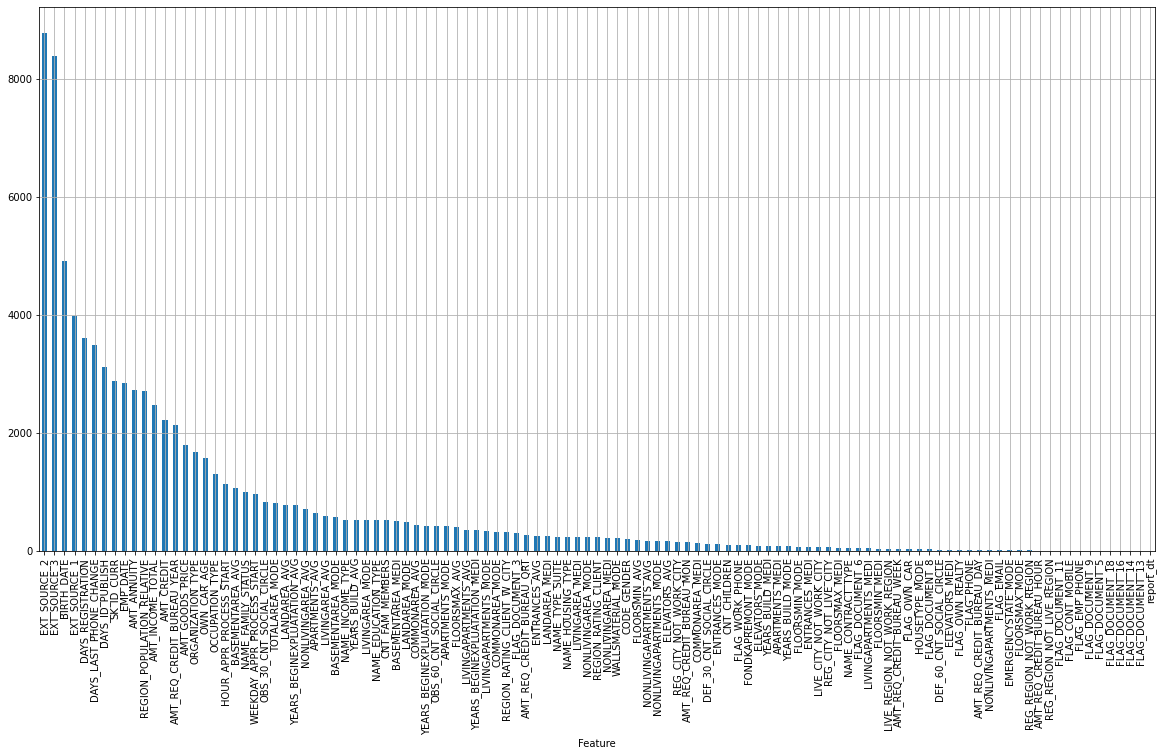

In [14]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

LightAutoML used 111 feats
1/111 Calculated score for FLAG_DOCUMENT_18: 0.0002751
2/111 Calculated score for AMT_ANNUITY: 0.0060904
3/111 Calculated score for NAME_FAMILY_STATUS: -0.0014300
4/111 Calculated score for ENTRANCES_MEDI: -0.0000238
5/111 Calculated score for BASEMENTAREA_MODE: 0.0002310
6/111 Calculated score for REG_REGION_NOT_WORK_REGION: -0.0000374
7/111 Calculated score for COMMONAREA_MEDI: -0.0003465
8/111 Calculated score for EXT_SOURCE_2: 0.0474592
9/111 Calculated score for NONLIVINGAPARTMENTS_MEDI: -0.0005231
10/111 Calculated score for LIVINGAPARTMENTS_MODE: -0.0009375
11/111 Calculated score for TOTALAREA_MODE: -0.0002140
12/111 Calculated score for report_dt: 0.0000000
13/111 Calculated score for EXT_SOURCE_1: 0.0035496
14/111 Calculated score for CNT_FAM_MEMBERS: 0.0015455
15/111 Calculated score for ORGANIZATION_TYPE: -0.0086719
16/111 Calculated score for NAME_TYPE_SUITE: 0.0005978
17/111 Calculated score for FLAG_DOCUMENT_8: -0.0002072
18/111 Calculated scor

<AxesSubplot:xlabel='Feature'>

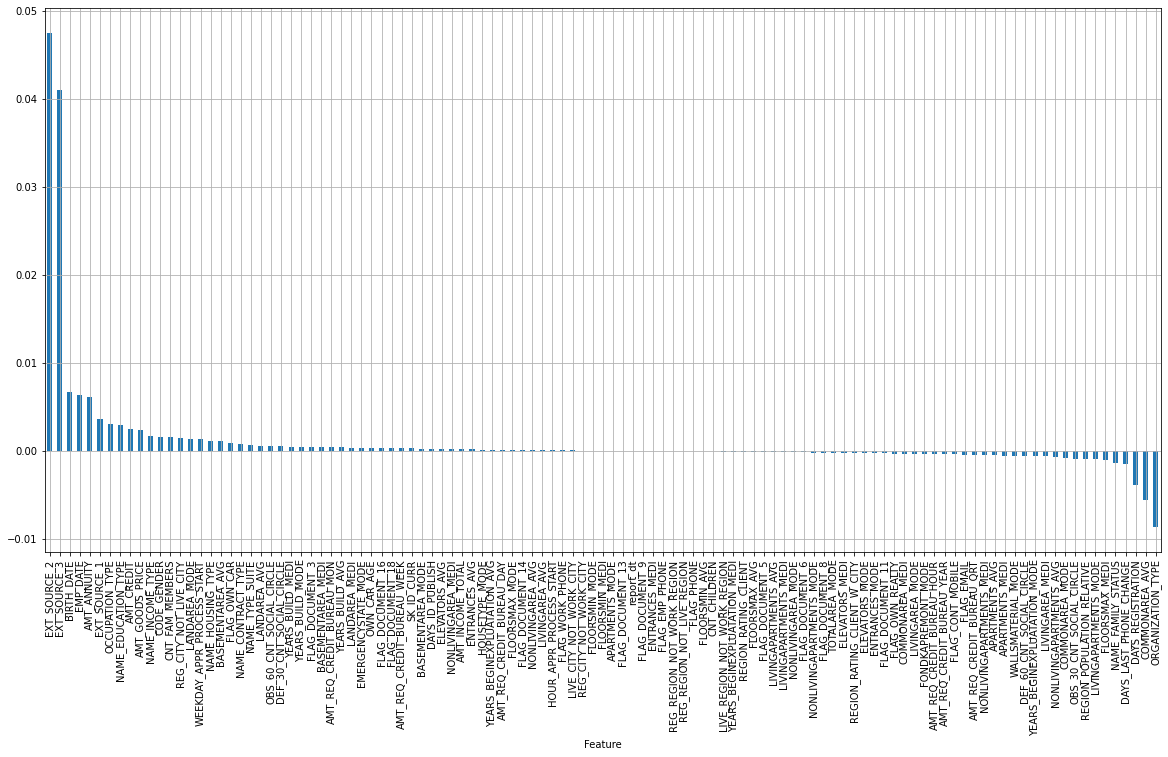

In [15]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl.get_feature_scores('accurate', test_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

## Step 4. Predict to test data and check scores

In [16]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-07-06 11:25:01,010] (INFO): Prediction for test data:
array([[0.05562638],
       [0.06626019],
       [0.02758071],
       ...,
       [0.05656667],
       [0.05265535],
       [0.21566027]], dtype=float32)
Shape = (2000, 1)
[2021-07-06 11:25:01,011] (INFO): Check scores...
[2021-07-06 11:25:01,014] (INFO): OOF score: 0.7530928449836819
[2021-07-06 11:25:01,016] (INFO): TEST score: 0.7312567934782609


CPU times: user 1.66 s, sys: 116 ms, total: 1.78 s
Wall time: 691 ms


## Step 5. Create AutoML with time utilization 

Below we are going to create specific AutoML preset for TIMEOUT utilization (try to spend it as much as possible):

In [17]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 8, 'cv': 5, 'random_state': 42}
Start automl preset with listed constraints:
- time: 1199.9987337589264 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (8000, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1195.4948661327362 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6866376937098748
Linear model: C = 5e-05 score = 0.7063254058619455
Linear model: C = 0.0001 score = 0.7209562144854094
Linear model: C = 0.0005 score = 0.7547722522464733
Linear model: C = 0.001 score = 0.761700103169385
Linear model: C = 0.005 score = 0.7632877356725523
Linear model: C = 0.01 score = 0.7602942198416645
Linear model: C = 0.0

[2021-07-06 11:25:26,634] (INFO): A new study created in memory with name: no-name-167cf6bf-419c-42fd-aa80-9f6b454c2d60


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.759444
[200]	valid's auc: 0.757616
Early stopping, best iteration is:
[24]	valid's auc: 0.766543
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:25:28,867] (INFO): Trial 0 finished with value: 0.7665431841386425 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.733892
[200]	valid's auc: 0.73602
[300]	valid's auc: 0.740403
[400]	valid's auc: 0.743151
[500]	valid's auc: 0.744503
[600]	valid's auc: 0.745979
[700]	valid's auc: 0.745637
[800]	valid's auc: 0.746219
[900]	valid's auc: 0.745909
[1000]	valid's auc: 0.745508
Early stopping, best iteration is:
[880]	valid's auc: 0.747064
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:25:41,906] (INFO): Trial 1 finished with value: 0.7470639489819374 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.727168
[200]	valid's auc: 0.733572
[300]	valid's auc: 0.73261
Early stopping, best iteration is:
[177]	valid's auc: 0.733882
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:25:44,062] (INFO): Trial 2 finished with value: 0.7338817881980638 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.745883
[200]	valid's auc: 0.747679
[300]	valid's auc: 0.747737
Early stopping, best iteration is:
[148]	valid's auc: 0.751282
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:25:47,137] (INFO): Trial 3 finished with value: 0.7512815989650988 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.754387
[200]	valid's auc: 0.761417
[300]	valid's auc: 0.761989
[400]	valid's auc: 0.761518
[500]	valid's auc: 0.761657
[600]	valid's auc: 0.760294
Early stopping, best iteration is:
[439]	valid's auc: 0.763379
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:25:49,875] (INFO): Trial 4 finished with value: 0.7633786102602755 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.743274
[200]	valid's auc: 0.747711
[300]	valid's auc: 0.74801
[400]	valid's auc: 0.749069
[500]	valid's auc: 0.749844
[600]	valid's auc: 0.750298
[700]	valid's auc: 0.750651
Early stopping, best iteration is:
[573]	valid's auc: 0.751105
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:25:59,472] (INFO): Trial 5 finished with value: 0.7511051953536358 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.753519
[200]	valid's auc: 0.760717
[300]	valid's auc: 0.764063
[400]	valid's auc: 0.762844
Early stopping, best iteration is:
[275]	valid's auc: 0.764961
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:01,596] (INFO): Trial 6 finished with value: 0.764960897199459 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749507
[200]	valid's auc: 0.746588
Early stopping, best iteration is:
[72]	valid's auc: 0.752003
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:04,467] (INFO): Trial 7 finished with value: 0.7520032501029021 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742451
[200]	valid's auc: 0.750694
[300]	valid's auc: 0.751078
[400]	valid's auc: 0.750758
Early stopping, best iteration is:
[275]	valid's auc: 0.752725
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:09,049] (INFO): Trial 8 finished with value: 0.7527249012407055 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748192
[200]	valid's auc: 0.750138
[300]	valid's auc: 0.755419
[400]	valid's auc: 0.752217
[500]	valid's auc: 0.753505
Early stopping, best iteration is:
[316]	valid's auc: 0.755547
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:13,263] (INFO): Trial 9 finished with value: 0.7555473590241139 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 0 with value: 0.7665431841386425.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.756312
[200]	valid's auc: 0.761219
[300]	valid's auc: 0.763523
[400]	valid's auc: 0.762721
[500]	valid's auc: 0.761171
Early stopping, best iteration is:
[348]	valid's auc: 0.766613
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:15,103] (INFO): Trial 10 finished with value: 0.7666126764704311 and parameters: {'feature_fraction': 0.6591377620440741, 'num_leaves': 92, 'bagging_fraction': 0.5023623641678501, 'min_sum_hessian_in_leaf': 6.037016369049049, 'reg_alpha': 0.044629157407987986, 'reg_lambda': 6.3505203867794775e-06}. Best is trial 10 with value: 0.7666126764704311.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752768
[200]	valid's auc: 0.757231
Early stopping, best iteration is:
[24]	valid's auc: 0.760273
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:15,682] (INFO): Trial 11 finished with value: 0.7602728375857294 and parameters: {'feature_fraction': 0.6734307400766498, 'num_leaves': 78, 'bagging_fraction': 0.5018055470485477, 'min_sum_hessian_in_leaf': 9.980585382555322, 'reg_alpha': 0.0752551628201671, 'reg_lambda': 7.650079634768741e-06}. Best is trial 10 with value: 0.7666126764704311.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.754975
[200]	valid's auc: 0.758455
[300]	valid's auc: 0.762021
[400]	valid's auc: 0.764015
[500]	valid's auc: 0.762967
[600]	valid's auc: 0.763004
Early stopping, best iteration is:
[425]	valid's auc: 0.765084
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:17,903] (INFO): Trial 12 finished with value: 0.7650838451710849 and parameters: {'feature_fraction': 0.6347818693744313, 'num_leaves': 94, 'bagging_fraction': 0.6065450039008404, 'min_sum_hessian_in_leaf': 7.132731717981334, 'reg_alpha': 0.01629363588656633, 'reg_lambda': 3.42440655706267e-06}. Best is trial 10 with value: 0.7666126764704311.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.745818
[200]	valid's auc: 0.751533
[300]	valid's auc: 0.75474
[400]	valid's auc: 0.754174
[500]	valid's auc: 0.752495
Early stopping, best iteration is:
[307]	valid's auc: 0.755462
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:20,194] (INFO): Trial 13 finished with value: 0.755461830000374 and parameters: {'feature_fraction': 0.8595101921818923, 'num_leaves': 86, 'bagging_fraction': 0.5722204162781267, 'min_sum_hessian_in_leaf': 3.461551230853909, 'reg_alpha': 0.563243585320909, 'reg_lambda': 4.588492805253924}. Best is trial 10 with value: 0.7666126764704311.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.746471
[200]	valid's auc: 0.75543
[300]	valid's auc: 0.75458
Early stopping, best iteration is:
[176]	valid's auc: 0.759738
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:23,908] (INFO): Trial 14 finished with value: 0.7597382811873566 and parameters: {'feature_fraction': 0.5031268390636299, 'num_leaves': 118, 'bagging_fraction': 0.5529195452691984, 'min_sum_hessian_in_leaf': 0.8918765729131236, 'reg_alpha': 0.001399145497777228, 'reg_lambda': 0.0001398089383758705}. Best is trial 10 with value: 0.7666126764704311.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.757044
[200]	valid's auc: 0.757819
[300]	valid's auc: 0.764287
[400]	valid's auc: 0.766965
[500]	valid's auc: 0.76672
[600]	valid's auc: 0.764913
Early stopping, best iteration is:
[439]	valid's auc: 0.767794
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:26,689] (INFO): Trial 15 finished with value: 0.767794046110835 and parameters: {'feature_fraction': 0.7006315295202941, 'num_leaves': 163, 'bagging_fraction': 0.6465850560141302, 'min_sum_hessian_in_leaf': 8.295467885955897, 'reg_alpha': 8.827446426671855e-06, 'reg_lambda': 4.778488743614888e-07}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755873
[200]	valid's auc: 0.758332
[300]	valid's auc: 0.759957
[400]	valid's auc: 0.758065
Early stopping, best iteration is:
[237]	valid's auc: 0.760973
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:28,568] (INFO): Trial 16 finished with value: 0.760973106467598 and parameters: {'feature_fraction': 0.7618409649994977, 'num_leaves': 185, 'bagging_fraction': 0.6565029271499713, 'min_sum_hessian_in_leaf': 9.403319551199754, 'reg_alpha': 7.852660904087287e-06, 'reg_lambda': 3.490372344148534e-07}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755697
[200]	valid's auc: 0.75675
[300]	valid's auc: 0.757563
[400]	valid's auc: 0.762326
[500]	valid's auc: 0.764838
[600]	valid's auc: 0.763475
[700]	valid's auc: 0.764325
Early stopping, best iteration is:
[520]	valid's auc: 0.766094
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:44,377] (INFO): Trial 17 finished with value: 0.7660941567640094 and parameters: {'feature_fraction': 0.8798576608145562, 'num_leaves': 180, 'bagging_fraction': 0.8129989624132342, 'min_sum_hessian_in_leaf': 0.0031057810658843745, 'reg_alpha': 1.0003208854515746e-08, 'reg_lambda': 4.4334424337483186e-07}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752426
[200]	valid's auc: 0.759198
[300]	valid's auc: 0.758536
[400]	valid's auc: 0.755809
Early stopping, best iteration is:
[203]	valid's auc: 0.759589
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:47,067] (INFO): Trial 18 finished with value: 0.7595886053958123 and parameters: {'feature_fraction': 0.614000169987808, 'num_leaves': 57, 'bagging_fraction': 0.6558607893739696, 'min_sum_hessian_in_leaf': 4.612072625159316, 'reg_alpha': 9.052066514767453e-06, 'reg_lambda': 3.1991608138192272e-06}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.759482
[200]	valid's auc: 0.763892
[300]	valid's auc: 0.76387
[400]	valid's auc: 0.763988
Early stopping, best iteration is:
[233]	valid's auc: 0.766549
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:51,020] (INFO): Trial 19 finished with value: 0.7665485297026262 and parameters: {'feature_fraction': 0.5504150122355218, 'num_leaves': 171, 'bagging_fraction': 0.5270088197985643, 'min_sum_hessian_in_leaf': 0.3072428984345069, 'reg_alpha': 0.5263074946535465, 'reg_lambda': 1.636600678951177e-07}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752222
[200]	valid's auc: 0.750993
Early stopping, best iteration is:
[18]	valid's auc: 0.758097
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:52,899] (INFO): Trial 20 finished with value: 0.7580971930443522 and parameters: {'feature_fraction': 0.6624535789654238, 'num_leaves': 61, 'bagging_fraction': 0.7723040206483124, 'min_sum_hessian_in_leaf': 0.013202366232610124, 'reg_alpha': 5.120052803687938e-06, 'reg_lambda': 1.2499792361142121e-05}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75451
[200]	valid's auc: 0.762999
[300]	valid's auc: 0.762454
Early stopping, best iteration is:
[184]	valid's auc: 0.763512
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:26:56,554] (INFO): Trial 21 finished with value: 0.7635122493598687 and parameters: {'feature_fraction': 0.5471198583286176, 'num_leaves': 178, 'bagging_fraction': 0.5237651639310642, 'min_sum_hessian_in_leaf': 0.35618597331677554, 'reg_alpha': 0.28988633983254647, 'reg_lambda': 7.384796169695122e-08}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747919
[200]	valid's auc: 0.750255
[300]	valid's auc: 0.752826
[400]	valid's auc: 0.753634
[500]	valid's auc: 0.756734
[600]	valid's auc: 0.756611
[700]	valid's auc: 0.758803
[800]	valid's auc: 0.759343
[900]	valid's auc: 0.758413
[1000]	valid's auc: 0.758145
Early stopping, best iteration is:
[865]	valid's auc: 0.759573
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:00,883] (INFO): Trial 22 finished with value: 0.759572568703861 and parameters: {'feature_fraction': 0.7142855954164302, 'num_leaves': 162, 'bagging_fraction': 0.621144632009722, 'min_sum_hessian_in_leaf': 3.887339761720967, 'reg_alpha': 6.3439398654475925, 'reg_lambda': 1.0524223320720805e-07}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738458
[200]	valid's auc: 0.748395
[300]	valid's auc: 0.749165
[400]	valid's auc: 0.750346
[500]	valid's auc: 0.747561
Early stopping, best iteration is:
[355]	valid's auc: 0.751266
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:06,680] (INFO): Trial 23 finished with value: 0.7512655622731476 and parameters: {'feature_fraction': 0.5715969418966599, 'num_leaves': 123, 'bagging_fraction': 0.5366474374808025, 'min_sum_hessian_in_leaf': 0.040983347543564086, 'reg_alpha': 0.007117349612286066, 'reg_lambda': 1.5363740674831422e-06}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.72968
[200]	valid's auc: 0.738506
[300]	valid's auc: 0.74375
[400]	valid's auc: 0.750918
[500]	valid's auc: 0.752511
[600]	valid's auc: 0.751907
[700]	valid's auc: 0.752404
Early stopping, best iteration is:
[549]	valid's auc: 0.753949
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:15,628] (INFO): Trial 24 finished with value: 0.7539490353929791 and parameters: {'feature_fraction': 0.5153866764636619, 'num_leaves': 200, 'bagging_fraction': 0.6773377479844194, 'min_sum_hessian_in_leaf': 0.6845552461833898, 'reg_alpha': 0.1396812709094824, 'reg_lambda': 8.695747996913792e-07}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752083
[200]	valid's auc: 0.752201
Early stopping, best iteration is:
[67]	valid's auc: 0.755815
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:17,575] (INFO): Trial 25 finished with value: 0.7558146372233003 and parameters: {'feature_fraction': 0.6322532277450739, 'num_leaves': 158, 'bagging_fraction': 0.5771880813164495, 'min_sum_hessian_in_leaf': 2.2128111018586676, 'reg_alpha': 1.1058117272381554, 'reg_lambda': 1.2123008523029717e-07}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.756157
[200]	valid's auc: 0.76031
[300]	valid's auc: 0.762154
[400]	valid's auc: 0.762566
[500]	valid's auc: 0.760182
Early stopping, best iteration is:
[339]	valid's auc: 0.763186
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:19,921] (INFO): Trial 26 finished with value: 0.7631861699568613 and parameters: {'feature_fraction': 0.7579347303186912, 'num_leaves': 129, 'bagging_fraction': 0.6279427569150867, 'min_sum_hessian_in_leaf': 9.551815580482671, 'reg_alpha': 4.471318080099868e-05, 'reg_lambda': 3.492341297556904e-05}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749951
[200]	valid's auc: 0.759712
[300]	valid's auc: 0.762999
[400]	valid's auc: 0.761321
[500]	valid's auc: 0.760743
Early stopping, best iteration is:
[328]	valid's auc: 0.764512
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:27,487] (INFO): Trial 27 finished with value: 0.7645118698248259 and parameters: {'feature_fraction': 0.7157287609213367, 'num_leaves': 106, 'bagging_fraction': 0.7064448550535081, 'min_sum_hessian_in_leaf': 0.27249876553715696, 'reg_alpha': 0.0005367467988076425, 'reg_lambda': 3.922988713136719e-08}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.72821
[200]	valid's auc: 0.744792
[300]	valid's auc: 0.748037
[400]	valid's auc: 0.752629
[500]	valid's auc: 0.749822
Early stopping, best iteration is:
[398]	valid's auc: 0.753329
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:33,373] (INFO): Trial 28 finished with value: 0.7533289499708666 and parameters: {'feature_fraction': 0.6099000055257451, 'num_leaves': 165, 'bagging_fraction': 0.5043111487600727, 'min_sum_hessian_in_leaf': 0.05326697145596337, 'reg_alpha': 0.032362494755628954, 'reg_lambda': 0.0004543372429386479}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752372
[200]	valid's auc: 0.756248
Early stopping, best iteration is:
[20]	valid's auc: 0.761615
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:35,522] (INFO): Trial 29 finished with value: 0.7616145741456453 and parameters: {'feature_fraction': 0.694231165550429, 'num_leaves': 140, 'bagging_fraction': 0.5554090117502621, 'min_sum_hessian_in_leaf': 1.3794317961210476, 'reg_alpha': 0.006123276488270011, 'reg_lambda': 1.4276628350704252e-05}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.753853
[200]	valid's auc: 0.755398
[300]	valid's auc: 0.755371
[400]	valid's auc: 0.755168
Early stopping, best iteration is:
[265]	valid's auc: 0.758723
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:38,045] (INFO): Trial 30 finished with value: 0.7587226240304483 and parameters: {'feature_fraction': 0.6576353371978286, 'num_leaves': 197, 'bagging_fraction': 0.5976913609529254, 'min_sum_hessian_in_leaf': 5.9330650593658145, 'reg_alpha': 8.843297780944176e-07, 'reg_lambda': 2.1660978871832137e-07}. Best is trial 15 with value: 0.767794046110835.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.763095
[200]	valid's auc: 0.760513
Early stopping, best iteration is:
[58]	valid's auc: 0.770467
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:40,582] (INFO): Trial 31 finished with value: 0.770466828102699 and parameters: {'feature_fraction': 0.685017784221405, 'num_leaves': 112, 'bagging_fraction': 0.5838666069346883, 'min_sum_hessian_in_leaf': 2.0777987035670935, 'reg_alpha': 0.004022146559548561, 'reg_lambda': 0.00017185533603274473}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.745808
[200]	valid's auc: 0.751169
[300]	valid's auc: 0.758161
[400]	valid's auc: 0.754307
[500]	valid's auc: 0.751715
Early stopping, best iteration is:
[301]	valid's auc: 0.758193
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:44,904] (INFO): Trial 32 finished with value: 0.7581934131960593 and parameters: {'feature_fraction': 0.534831328962411, 'num_leaves': 103, 'bagging_fraction': 0.538213232057449, 'min_sum_hessian_in_leaf': 2.311384343174585, 'reg_alpha': 0.0032601125648197, 'reg_lambda': 0.0018274920332165597}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.757194
[200]	valid's auc: 0.765442
[300]	valid's auc: 0.76139
Early stopping, best iteration is:
[187]	valid's auc: 0.76757
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:48,948] (INFO): Trial 33 finished with value: 0.7675695324235184 and parameters: {'feature_fraction': 0.7385037307234729, 'num_leaves': 75, 'bagging_fraction': 0.5746003207207385, 'min_sum_hessian_in_leaf': 0.99415958537772, 'reg_alpha': 0.0001987424096969822, 'reg_lambda': 4.842961034134343e-05}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752196
[200]	valid's auc: 0.757835
[300]	valid's auc: 0.764694
[400]	valid's auc: 0.762309
Early stopping, best iteration is:
[269]	valid's auc: 0.765923
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:53,286] (INFO): Trial 34 finished with value: 0.7659230987165301 and parameters: {'feature_fraction': 0.7857673364832369, 'num_leaves': 67, 'bagging_fraction': 0.5988284240576138, 'min_sum_hessian_in_leaf': 3.068304900348909, 'reg_alpha': 0.0003902960487171992, 'reg_lambda': 0.00012282754627832736}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.760856
[200]	valid's auc: 0.756542
[300]	valid's auc: 0.76123
Early stopping, best iteration is:
[110]	valid's auc: 0.762716
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:55,485] (INFO): Trial 35 finished with value: 0.7627157603262932 and parameters: {'feature_fraction': 0.8250422316946686, 'num_leaves': 41, 'bagging_fraction': 0.6341332333279815, 'min_sum_hessian_in_leaf': 1.0916084560829244, 'reg_alpha': 0.00011182705198405364, 'reg_lambda': 0.001723568478876717}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.760604
[200]	valid's auc: 0.760497
[300]	valid's auc: 0.759017
Early stopping, best iteration is:
[169]	valid's auc: 0.763202
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:27:57,911] (INFO): Trial 36 finished with value: 0.7632022066488124 and parameters: {'feature_fraction': 0.7362963258297988, 'num_leaves': 114, 'bagging_fraction': 0.6865686715650421, 'min_sum_hessian_in_leaf': 5.99480040376386, 'reg_alpha': 4.3596883537968666e-05, 'reg_lambda': 7.69144265434723e-05}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.756109
[200]	valid's auc: 0.758103
Early stopping, best iteration is:
[40]	valid's auc: 0.766067
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:00,326] (INFO): Trial 37 finished with value: 0.7660674289440907 and parameters: {'feature_fraction': 0.6856628020932759, 'num_leaves': 79, 'bagging_fraction': 0.5773811189097595, 'min_sum_hessian_in_leaf': 0.49590516158585796, 'reg_alpha': 0.0001846317245037183, 'reg_lambda': 0.00048714367638890544}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.754414
[200]	valid's auc: 0.756884
[300]	valid's auc: 0.75884
[400]	valid's auc: 0.75923
Early stopping, best iteration is:
[275]	valid's auc: 0.761278
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:03,777] (INFO): Trial 38 finished with value: 0.7612778036146705 and parameters: {'feature_fraction': 0.6971324255424416, 'num_leaves': 45, 'bagging_fraction': 0.5616057239804734, 'min_sum_hessian_in_leaf': 1.590714639408147, 'reg_alpha': 2.2539574375350496e-06, 'reg_lambda': 0.006060550306135683}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755248
[200]	valid's auc: 0.756734
[300]	valid's auc: 0.75745
[400]	valid's auc: 0.757605
Early stopping, best iteration is:
[273]	valid's auc: 0.76054
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:07,537] (INFO): Trial 39 finished with value: 0.7605401157849159 and parameters: {'feature_fraction': 0.7427311225639268, 'num_leaves': 100, 'bagging_fraction': 0.5065705761461665, 'min_sum_hessian_in_leaf': 2.8512336367226583, 'reg_alpha': 0.0021512405623812267, 'reg_lambda': 3.424436438572325e-05}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.748112
[200]	valid's auc: 0.746059
[300]	valid's auc: 0.750474
[400]	valid's auc: 0.752875
[500]	valid's auc: 0.755724
[600]	valid's auc: 0.754574
Early stopping, best iteration is:
[451]	valid's auc: 0.75652
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:16,185] (INFO): Trial 40 finished with value: 0.7565202516691524 and parameters: {'feature_fraction': 0.646405418157616, 'num_leaves': 91, 'bagging_fraction': 0.7554824821813781, 'min_sum_hessian_in_leaf': 0.17423905699884276, 'reg_alpha': 1.7080066727898393e-05, 'reg_lambda': 0.2426166772437776}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.754703
[200]	valid's auc: 0.755825
[300]	valid's auc: 0.756697
[400]	valid's auc: 0.754778
[500]	valid's auc: 0.758322
[600]	valid's auc: 0.758862
[700]	valid's auc: 0.759011
[800]	valid's auc: 0.758621
[900]	valid's auc: 0.75999
Early stopping, best iteration is:
[736]	valid's auc: 0.760235
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:26,495] (INFO): Trial 41 finished with value: 0.7602354186378435 and parameters: {'feature_fraction': 0.7768189324537915, 'num_leaves': 134, 'bagging_fraction': 0.53039524679862, 'min_sum_hessian_in_leaf': 0.46889024477244196, 'reg_alpha': 0.05498554438109736, 'reg_lambda': 2.4632525102131593e-06}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.759118
[200]	valid's auc: 0.762026
Early stopping, best iteration is:
[76]	valid's auc: 0.768489
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:29,356] (INFO): Trial 42 finished with value: 0.7684889694287196 and parameters: {'feature_fraction': 0.5811339114683813, 'num_leaves': 154, 'bagging_fraction': 0.5861159056614884, 'min_sum_hessian_in_leaf': 0.8582615875711846, 'reg_alpha': 0.01457626490108384, 'reg_lambda': 2.1452788810904317e-08}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.756109
[200]	valid's auc: 0.749993
Early stopping, best iteration is:
[45]	valid's auc: 0.764041
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:32,178] (INFO): Trial 43 finished with value: 0.7640414601942578 and parameters: {'feature_fraction': 0.5849505927827783, 'num_leaves': 149, 'bagging_fraction': 0.6091974038927701, 'min_sum_hessian_in_leaf': 0.7937636511544109, 'reg_alpha': 0.013381228446223943, 'reg_lambda': 3.5431017401530586e-08}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752099
[200]	valid's auc: 0.758225
[300]	valid's auc: 0.761615
[400]	valid's auc: 0.764752
[500]	valid's auc: 0.765608
[600]	valid's auc: 0.768291
[700]	valid's auc: 0.769457
[800]	valid's auc: 0.766864
Early stopping, best iteration is:
[698]	valid's auc: 0.769702
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:35,143] (INFO): Trial 44 finished with value: 0.7697024124530258 and parameters: {'feature_fraction': 0.6220397617728336, 'num_leaves': 16, 'bagging_fraction': 0.6397687759368823, 'min_sum_hessian_in_leaf': 1.8389793699302304, 'reg_alpha': 0.005284029405264343, 'reg_lambda': 5.548503492956499e-06}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.751463
[200]	valid's auc: 0.75745
[300]	valid's auc: 0.75783
[400]	valid's auc: 0.758648
[500]	valid's auc: 0.758552
Early stopping, best iteration is:
[347]	valid's auc: 0.759829
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:37,489] (INFO): Trial 45 finished with value: 0.7598291557750799 and parameters: {'feature_fraction': 0.6141981822968298, 'num_leaves': 23, 'bagging_fraction': 0.6404101642061805, 'min_sum_hessian_in_leaf': 1.7670680488763342, 'reg_alpha': 0.0013498099303970287, 'reg_lambda': 2.1642230660594707e-05}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.746936
[200]	valid's auc: 0.75497
[300]	valid's auc: 0.756665
[400]	valid's auc: 0.757739
[500]	valid's auc: 0.758284
[600]	valid's auc: 0.757595
[700]	valid's auc: 0.757162
Early stopping, best iteration is:
[512]	valid's auc: 0.759289
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:45,461] (INFO): Trial 46 finished with value: 0.7592892538127236 and parameters: {'feature_fraction': 0.5902709743360955, 'num_leaves': 140, 'bagging_fraction': 0.6919503466366576, 'min_sum_hessian_in_leaf': 1.3389466261997105, 'reg_alpha': 0.00621515522845729, 'reg_lambda': 0.00023203004727266336}. Best is trial 31 with value: 0.770466828102699.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.762561
[200]	valid's auc: 0.769906
[300]	valid's auc: 0.767035
Early stopping, best iteration is:
[174]	valid's auc: 0.770921
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:46,662] (INFO): Trial 47 finished with value: 0.770921201041316 and parameters: {'feature_fraction': 0.8234480739667629, 'num_leaves': 17, 'bagging_fraction': 0.66482631235055, 'min_sum_hessian_in_leaf': 0.532726040918637, 'reg_alpha': 0.00015398054592409942, 'reg_lambda': 8.840735289523824e-07}. Best is trial 47 with value: 0.770921201041316.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.747128
[200]	valid's auc: 0.746203
[300]	valid's auc: 0.751148
[400]	valid's auc: 0.751891
[500]	valid's auc: 0.752164
Early stopping, best iteration is:
[376]	valid's auc: 0.753377
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:28:57,173] (INFO): Trial 48 finished with value: 0.7533770600467202 and parameters: {'feature_fraction': 0.8983058594008644, 'num_leaves': 243, 'bagging_fraction': 0.7251130812815647, 'min_sum_hessian_in_leaf': 0.5742241937255466, 'reg_alpha': 1.4548562097019483e-07, 'reg_lambda': 1.2316592249678983e-08}. Best is trial 47 with value: 0.770921201041316.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.753655
[200]	valid's auc: 0.757199
[300]	valid's auc: 0.755521
[400]	valid's auc: 0.755088
Early stopping, best iteration is:
[203]	valid's auc: 0.757686
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:29:02,451] (INFO): Trial 49 finished with value: 0.757685584617605 and parameters: {'feature_fraction': 0.9182429312293275, 'num_leaves': 221, 'bagging_fraction': 0.6608359334469291, 'min_sum_hessian_in_leaf': 0.1795381882420236, 'reg_alpha': 0.01816566088696722, 'reg_lambda': 8.924258798689936e-07}. Best is trial 47 with value: 0.770921201041316.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.750726
Early stopping, best iteration is:
[76]	valid's auc: 0.761224

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.731509
[200]	valid's auc: 0.746099
[300]	valid's auc: 0.743615
Early stopping, best iteration is:
[201]	valid's auc: 0.746805

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.735192
Early stopping, best iteration is:
[56]	valid's auc: 0.73826

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.718925
[200]	valid's auc: 0.728579
[300]	valid's auc: 0.731408
Early st

[2021-07-06 11:29:12,886] (INFO): A new study created in memory with name: no-name-a66d964b-9172-4a9e-a993-866bd4174916


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5468833	best: 0.5468833 (0)	total: 5.82ms	remaining: 29.1s
100:	test: 0.6993922	best: 0.7188180 (42)	total: 422ms	remaining: 20.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7188179889
bestIteration = 42

Shrink model to first 43 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:13,618] (INFO): Trial 0 finished with value: 0.7188179888919181 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.7188179888919181.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5244266	best: 0.5244266 (0)	total: 9.08ms	remaining: 45.4s
100:	test: 0.6289003	best: 0.6439480 (92)	total: 543ms	remaining: 26.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6439480197
bestIteration = 92

Shrink model to first 93 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:14,786] (INFO): Trial 1 finished with value: 0.6439480197358223 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7188179888919181.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 4.17ms	remaining: 20.8s
100:	test: 0.7510945	best: 0.7510945 (100)	total: 358ms	remaining: 17.4s
200:	test: 0.7615344	best: 0.7634053 (165)	total: 725ms	remaining: 17.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7634053381
bestIteration = 165

Shrink model to first 166 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:15,884] (INFO): Trial 2 finished with value: 0.7634053380801942 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7634053380801942.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4944593	best: 0.4944593 (0)	total: 4.16ms	remaining: 20.8s
100:	test: 0.7417505	best: 0.7425416 (86)	total: 373ms	remaining: 18.1s
200:	test: 0.7396550	best: 0.7513404 (121)	total: 741ms	remaining: 17.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7513404002
bestIteration = 121

Shrink model to first 122 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:16,831] (INFO): Trial 3 finished with value: 0.7513404001689198 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7634053380801942.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5365530	best: 0.5365530 (0)	total: 4.14ms	remaining: 20.7s
100:	test: 0.7303163	best: 0.7311716 (75)	total: 339ms	remaining: 16.4s
200:	test: 0.7366187	best: 0.7377680 (155)	total: 671ms	remaining: 16s
300:	test: 0.7463049	best: 0.7464599 (299)	total: 1s	remaining: 15.7s
400:	test: 0.7502980	best: 0.7505653 (394)	total: 1.34s	remaining: 15.4s
500:	test: 0.7519498	best: 0.7527463 (482)	total: 1.69s	remaining: 15.2s
600:	test: 0.7539170	best: 0.7547455 (553)	total: 2.03s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7547455244
bestIteration = 553

Shrink model to first 554 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:19,185] (INFO): Trial 4 finished with value: 0.7547455244265547 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7634053380801942.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5063532	best: 0.5063532 (0)	total: 5.78ms	remaining: 28.9s
100:	test: 0.7027546	best: 0.7027546 (100)	total: 435ms	remaining: 21.1s
200:	test: 0.6841787	best: 0.7038130 (103)	total: 866ms	remaining: 20.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7038129908
bestIteration = 103

Shrink model to first 104 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:20,191] (INFO): Trial 5 finished with value: 0.7038129907895933 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7634053380801942.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.6ms	remaining: 18s
100:	test: 0.7440330	best: 0.7440330 (100)	total: 284ms	remaining: 13.8s
200:	test: 0.7494962	best: 0.7516772 (192)	total: 560ms	remaining: 13.4s
300:	test: 0.7583805	best: 0.7583805 (300)	total: 836ms	remaining: 13.1s
400:	test: 0.7617322	best: 0.7622721 (383)	total: 1.11s	remaining: 12.8s
500:	test: 0.7659872	best: 0.7668265 (492)	total: 1.39s	remaining: 12.5s
600:	test: 0.7660888	best: 0.7670617 (575)	total: 1.67s	remaining: 12.2s
700:	test: 0.7641804	best: 0.7680453 (638)	total: 1.95s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7680452876
bestIteration = 638

Shrink model to first 639 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:22,385] (INFO): Trial 6 finished with value: 0.7680452876180701 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 6 with value: 0.7680452876180701.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5063532	best: 0.5063532 (0)	total: 5.37ms	remaining: 26.8s
100:	test: 0.6909302	best: 0.6940948 (81)	total: 436ms	remaining: 21.1s
200:	test: 0.6886209	best: 0.7028027 (138)	total: 872ms	remaining: 20.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7028026792
bestIteration = 138

Shrink model to first 139 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:23,555] (INFO): Trial 7 finished with value: 0.7028026791966686 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 6 with value: 0.7680452876180701.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4944593	best: 0.4944593 (0)	total: 4.08ms	remaining: 20.4s
100:	test: 0.7285683	best: 0.7285683 (100)	total: 371ms	remaining: 18s
200:	test: 0.7226721	best: 0.7288035 (102)	total: 740ms	remaining: 17.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7288035024
bestIteration = 102

Shrink model to first 103 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:24,431] (INFO): Trial 8 finished with value: 0.7288035024135221 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 6 with value: 0.7680452876180701.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5242234	best: 0.5242234 (0)	total: 8.08ms	remaining: 40.4s
100:	test: 0.7127508	best: 0.7266492 (84)	total: 535ms	remaining: 25.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7266492401
bestIteration = 84

Shrink model to first 85 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:25,540] (INFO): Trial 9 finished with value: 0.7266492401280797 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 6 with value: 0.7680452876180701.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.28ms	remaining: 16.4s
100:	test: 0.7450754	best: 0.7457008 (98)	total: 283ms	remaining: 13.7s
200:	test: 0.7533824	best: 0.7551037 (181)	total: 561ms	remaining: 13.4s
300:	test: 0.7573435	best: 0.7580010 (296)	total: 841ms	remaining: 13.1s
400:	test: 0.7613687	best: 0.7626035 (388)	total: 1.12s	remaining: 12.9s
500:	test: 0.7628601	best: 0.7634695 (432)	total: 1.4s	remaining: 12.6s
600:	test: 0.7644103	best: 0.7650785 (587)	total: 1.69s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7650784996
bestIteration = 587

Shrink model to first 588 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:27,615] (INFO): Trial 10 finished with value: 0.7650784996071011 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06499282242794224, 'min_data_in_leaf': 20}. Best is trial 6 with value: 0.7680452876180701.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.31ms	remaining: 16.6s
100:	test: 0.7501804	best: 0.7507470 (95)	total: 283ms	remaining: 13.7s
200:	test: 0.7555527	best: 0.7570174 (191)	total: 561ms	remaining: 13.4s
300:	test: 0.7593374	best: 0.7600857 (252)	total: 838ms	remaining: 13.1s
400:	test: 0.7625180	best: 0.7628815 (395)	total: 1.12s	remaining: 12.8s
500:	test: 0.7668051	best: 0.7672167 (491)	total: 1.4s	remaining: 12.5s
600:	test: 0.7681789	best: 0.7684569 (590)	total: 1.68s	remaining: 12.3s
700:	test: 0.7696276	best: 0.7696276 (700)	total: 1.97s	remaining: 12.1s
800:	test: 0.7709265	best: 0.7727227 (756)	total: 2.25s	remaining: 11.8s
900:	test: 0.7726852	best: 0.7738720 (889)	total: 2.53s	remaining: 11.5s
1000:	test: 0.7745455	best: 0.7752939 (986)	total: 2.81s	remaining: 11.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7752938724
bes

[2021-07-06 11:29:30,820] (INFO): Trial 11 finished with value: 0.7752938723800054 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07229699744221589, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.2ms	remaining: 16s
100:	test: 0.7486676	best: 0.7486676 (100)	total: 284ms	remaining: 13.8s
200:	test: 0.7538421	best: 0.7546333 (168)	total: 561ms	remaining: 13.4s
300:	test: 0.7525164	best: 0.7553870 (216)	total: 838ms	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7553869921
bestIteration = 216

Shrink model to first 217 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:31,840] (INFO): Trial 12 finished with value: 0.755386992104602 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.009116381196309456, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.27ms	remaining: 16.4s
100:	test: 0.7445355	best: 0.7445355 (100)	total: 281ms	remaining: 13.6s
200:	test: 0.7545157	best: 0.7545157 (200)	total: 556ms	remaining: 13.3s
300:	test: 0.7542163	best: 0.7558039 (214)	total: 832ms	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7558039461
bestIteration = 214

Shrink model to first 215 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:32,847] (INFO): Trial 13 finished with value: 0.7558039460953329 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3450988054155977e-05, 'min_data_in_leaf': 8}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.73ms	remaining: 18.6s
100:	test: 0.7391151	best: 0.7399918 (97)	total: 328ms	remaining: 15.9s
200:	test: 0.7504263	best: 0.7514687 (194)	total: 651ms	remaining: 15.5s
300:	test: 0.7573060	best: 0.7576535 (298)	total: 975ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7576535112
bestIteration = 298

Shrink model to first 299 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:34,285] (INFO): Trial 14 finished with value: 0.7576535112337027 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3016802449672827, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5447932	best: 0.5447932 (0)	total: 3.59ms	remaining: 17.9s
100:	test: 0.7464652	best: 0.7471441 (97)	total: 333ms	remaining: 16.1s
200:	test: 0.7554992	best: 0.7554992 (200)	total: 658ms	remaining: 15.7s
300:	test: 0.7570869	best: 0.7591075 (263)	total: 987ms	remaining: 15.4s
400:	test: 0.7586692	best: 0.7601392 (362)	total: 1.31s	remaining: 15.1s
500:	test: 0.7640468	best: 0.7645333 (491)	total: 1.64s	remaining: 14.7s
600:	test: 0.7638330	best: 0.7660674 (533)	total: 1.97s	remaining: 14.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7660674289
bestIteration = 533

Shrink model to first 534 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:36,507] (INFO): Trial 15 finished with value: 0.7660674289440906 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.557781518703611, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.31ms	remaining: 16.6s
100:	test: 0.7429799	best: 0.7431350 (97)	total: 278ms	remaining: 13.5s
200:	test: 0.7555634	best: 0.7563118 (191)	total: 553ms	remaining: 13.2s
300:	test: 0.7643515	best: 0.7649395 (292)	total: 830ms	remaining: 13s
400:	test: 0.7630311	best: 0.7655008 (320)	total: 1.11s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7655007992
bestIteration = 320

Shrink model to first 321 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:37,809] (INFO): Trial 16 finished with value: 0.7655007991618155 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003580818594640122, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.5ms	remaining: 17.5s
100:	test: 0.7364744	best: 0.7364744 (100)	total: 328ms	remaining: 15.9s
200:	test: 0.7364584	best: 0.7396710 (155)	total: 646ms	remaining: 15.4s
300:	test: 0.7486516	best: 0.7487638 (299)	total: 969ms	remaining: 15.1s
400:	test: 0.7580812	best: 0.7593160 (393)	total: 1.29s	remaining: 14.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7593159816
bestIteration = 393

Shrink model to first 394 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:39,550] (INFO): Trial 17 finished with value: 0.7593159816326421 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1630064225846183e-05, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7537459	best: 0.7537459 (100)	total: 283ms	remaining: 13.7s
200:	test: 0.7603316	best: 0.7611495 (190)	total: 564ms	remaining: 13.5s
300:	test: 0.7630953	best: 0.7631167 (299)	total: 842ms	remaining: 13.2s
400:	test: 0.7657146	best: 0.7676070 (379)	total: 1.13s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7676069514
bestIteration = 379

Shrink model to first 380 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:41,044] (INFO): Trial 18 finished with value: 0.7676069513714044 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.13661450703683173, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.69ms	remaining: 18.4s
100:	test: 0.7386554	best: 0.7427287 (97)	total: 329ms	remaining: 16s
200:	test: 0.7443163	best: 0.7444179 (176)	total: 650ms	remaining: 15.5s
300:	test: 0.7445088	best: 0.7489402 (240)	total: 973ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7489402419
bestIteration = 240

Shrink model to first 241 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:42,292] (INFO): Trial 19 finished with value: 0.7489402419402258 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.001246754072973536, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.17ms	remaining: 15.9s
100:	test: 0.7534519	best: 0.7543981 (97)	total: 281ms	remaining: 13.7s
200:	test: 0.7582415	best: 0.7591396 (197)	total: 559ms	remaining: 13.4s
300:	test: 0.7623523	best: 0.7623523 (300)	total: 838ms	remaining: 13.1s
400:	test: 0.7648379	best: 0.7664202 (369)	total: 1.11s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7664202362
bestIteration = 369

Shrink model to first 370 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:43,740] (INFO): Trial 20 finished with value: 0.7664202361670168 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.916606796756302e-05, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7447654	best: 0.7447654 (100)	total: 282ms	remaining: 13.7s
200:	test: 0.7531846	best: 0.7545745 (183)	total: 561ms	remaining: 13.4s
300:	test: 0.7550769	best: 0.7553763 (265)	total: 842ms	remaining: 13.2s
400:	test: 0.7615451	best: 0.7622186 (394)	total: 1.13s	remaining: 12.9s
500:	test: 0.7638063	best: 0.7643889 (470)	total: 1.41s	remaining: 12.7s
600:	test: 0.7645814	best: 0.7654848 (587)	total: 1.7s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7654847625
bestIteration = 587

Shrink model to first 588 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:45,835] (INFO): Trial 21 finished with value: 0.7654847624698643 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.9112081554674352, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.22ms	remaining: 16.1s
100:	test: 0.7543820	best: 0.7543820 (100)	total: 283ms	remaining: 13.7s
200:	test: 0.7611067	best: 0.7627853 (198)	total: 559ms	remaining: 13.4s
300:	test: 0.7638276	best: 0.7648647 (234)	total: 839ms	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.764864677
bestIteration = 234

Shrink model to first 235 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:46,908] (INFO): Trial 22 finished with value: 0.764864677047752 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.09272267923980158, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.76ms	remaining: 18.8s
100:	test: 0.7445729	best: 0.7445729 (100)	total: 334ms	remaining: 16.2s
200:	test: 0.7477215	best: 0.7486783 (118)	total: 663ms	remaining: 15.8s
300:	test: 0.7517948	best: 0.7523881 (295)	total: 993ms	remaining: 15.5s
400:	test: 0.7546600	best: 0.7573114 (359)	total: 1.32s	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7573113951
bestIteration = 359

Shrink model to first 360 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:48,574] (INFO): Trial 23 finished with value: 0.757311395138744 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04429435700075925, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.37ms	remaining: 16.8s
100:	test: 0.7447547	best: 0.7447547 (100)	total: 293ms	remaining: 14.2s
200:	test: 0.7559215	best: 0.7563652 (197)	total: 585ms	remaining: 14s
300:	test: 0.7623148	best: 0.7629349 (296)	total: 887ms	remaining: 13.8s
400:	test: 0.7645226	best: 0.7654901 (389)	total: 1.19s	remaining: 13.7s
500:	test: 0.7665058	best: 0.7672809 (477)	total: 1.5s	remaining: 13.5s
600:	test: 0.7676551	best: 0.7696917 (560)	total: 1.81s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7696917213
bestIteration = 560

Shrink model to first 561 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:50,710] (INFO): Trial 24 finished with value: 0.7696917213250584 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.539529697046928, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.81ms	remaining: 19.1s
100:	test: 0.7527516	best: 0.7534198 (94)	total: 344ms	remaining: 16.7s
200:	test: 0.7587494	best: 0.7587494 (200)	total: 677ms	remaining: 16.2s
300:	test: 0.7623042	best: 0.7625928 (268)	total: 1.01s	remaining: 15.8s
400:	test: 0.7640682	best: 0.7652816 (348)	total: 1.35s	remaining: 15.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.765281631
bestIteration = 348

Shrink model to first 349 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:52,365] (INFO): Trial 25 finished with value: 0.7652816310384828 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.3616993560562674, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.35ms	remaining: 16.8s
100:	test: 0.7444981	best: 0.7444981 (100)	total: 289ms	remaining: 14s
200:	test: 0.7559590	best: 0.7559590 (200)	total: 570ms	remaining: 13.6s
300:	test: 0.7571403	best: 0.7580491 (297)	total: 854ms	remaining: 13.3s
400:	test: 0.7589418	best: 0.7601927 (387)	total: 1.14s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7601926541
bestIteration = 387

Shrink model to first 388 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:53,898] (INFO): Trial 26 finished with value: 0.7601926541259736 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014448621628871113, 'min_data_in_leaf': 3}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.25ms	remaining: 16.2s
100:	test: 0.7486837	best: 0.7488975 (99)	total: 285ms	remaining: 13.8s
200:	test: 0.7537245	best: 0.7537245 (200)	total: 570ms	remaining: 13.6s
300:	test: 0.7601285	best: 0.7601285 (300)	total: 858ms	remaining: 13.4s
400:	test: 0.7643568	best: 0.7643943 (397)	total: 1.15s	remaining: 13.1s
500:	test: 0.7656024	best: 0.7661850 (477)	total: 1.44s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7661850314
bestIteration = 477

Shrink model to first 478 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:55,702] (INFO): Trial 27 finished with value: 0.7661850313517328 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.786274557102475, 'min_data_in_leaf': 8}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.74ms	remaining: 18.7s
100:	test: 0.7370624	best: 0.7405049 (97)	total: 326ms	remaining: 15.8s
200:	test: 0.7457810	best: 0.7464225 (182)	total: 644ms	remaining: 15.4s
300:	test: 0.7522171	best: 0.7528799 (298)	total: 963ms	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7528799226
bestIteration = 298

Shrink model to first 299 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:57,123] (INFO): Trial 28 finished with value: 0.7528799225962335 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.976728118641791e-05, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.26ms	remaining: 16.3s
100:	test: 0.7352128	best: 0.7396229 (89)	total: 279ms	remaining: 13.5s
200:	test: 0.7490953	best: 0.7523614 (180)	total: 552ms	remaining: 13.2s
300:	test: 0.7517360	best: 0.7524255 (225)	total: 829ms	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7524255497
bestIteration = 225

Shrink model to first 226 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:29:58,160] (INFO): Trial 29 finished with value: 0.7524255496576167 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.292827846705153e-06, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.54ms	remaining: 17.7s
100:	test: 0.7411945	best: 0.7446210 (96)	total: 326ms	remaining: 15.8s
200:	test: 0.7629937	best: 0.7629937 (200)	total: 647ms	remaining: 15.5s
300:	test: 0.7650304	best: 0.7650304 (300)	total: 972ms	remaining: 15.2s
400:	test: 0.7682377	best: 0.7684943 (399)	total: 1.3s	remaining: 14.9s
500:	test: 0.7678475	best: 0.7702958 (420)	total: 1.62s	remaining: 14.6s
600:	test: 0.7626623	best: 0.7704187 (511)	total: 1.95s	remaining: 14.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.770418718
bestIteration = 511

Shrink model to first 512 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:00,296] (INFO): Trial 30 finished with value: 0.7704187180268454 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002662951286892553, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.49ms	remaining: 17.5s
100:	test: 0.7493091	best: 0.7495710 (97)	total: 327ms	remaining: 15.9s
200:	test: 0.7546921	best: 0.7580544 (176)	total: 650ms	remaining: 15.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7580544285
bestIteration = 176

Shrink model to first 177 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:01,328] (INFO): Trial 31 finished with value: 0.7580544285324823 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002067134567669581, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7493679	best: 0.7575038 (78)	total: 284ms	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7575038354
bestIteration = 78

Shrink model to first 79 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:01,964] (INFO): Trial 32 finished with value: 0.7575038354421583 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.017809538674515686, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.49ms	remaining: 17.4s
100:	test: 0.7389280	best: 0.7409486 (87)	total: 328ms	remaining: 15.9s
200:	test: 0.7515221	best: 0.7541735 (194)	total: 654ms	remaining: 15.6s
300:	test: 0.7559803	best: 0.7559803 (300)	total: 980ms	remaining: 15.3s
400:	test: 0.7559697	best: 0.7568196 (302)	total: 1.3s	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7568196033
bestIteration = 302

Shrink model to first 303 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:03,422] (INFO): Trial 33 finished with value: 0.7568196032522411 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0037344800293307836, 'min_data_in_leaf': 1}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 4.28ms	remaining: 21.4s
100:	test: 0.7471228	best: 0.7480582 (97)	total: 378ms	remaining: 18.3s
200:	test: 0.7500307	best: 0.7517841 (182)	total: 747ms	remaining: 17.8s
300:	test: 0.7550609	best: 0.7564240 (264)	total: 1.12s	remaining: 17.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7564240315
bestIteration = 264

Shrink model to first 265 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:04,930] (INFO): Trial 34 finished with value: 0.7564240315174452 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.37610724867041123, 'min_data_in_leaf': 8}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.19ms	remaining: 16s
100:	test: 0.7465989	best: 0.7471334 (99)	total: 280ms	remaining: 13.6s
200:	test: 0.7564989	best: 0.7564989 (200)	total: 559ms	remaining: 13.4s
300:	test: 0.7598292	best: 0.7628761 (267)	total: 844ms	remaining: 13.2s
400:	test: 0.7630044	best: 0.7660942 (379)	total: 1.14s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7660941568
bestIteration = 379

Shrink model to first 380 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:06,435] (INFO): Trial 35 finished with value: 0.7660941567640094 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0001563133522361333, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367561	best: 0.5367561 (0)	total: 3.45ms	remaining: 17.2s
100:	test: 0.7254037	best: 0.7255481 (98)	total: 322ms	remaining: 15.6s
200:	test: 0.7371586	best: 0.7377252 (197)	total: 640ms	remaining: 15.3s
300:	test: 0.7411250	best: 0.7415046 (293)	total: 956ms	remaining: 14.9s
400:	test: 0.7370196	best: 0.7419269 (358)	total: 1.27s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.741926862
bestIteration = 358

Shrink model to first 359 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:08,036] (INFO): Trial 36 finished with value: 0.7419268619935746 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0009547211241999317, 'min_data_in_leaf': 4}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 4.84ms	remaining: 24.2s
100:	test: 0.7457971	best: 0.7467646 (95)	total: 376ms	remaining: 18.2s
200:	test: 0.7417505	best: 0.7560873 (116)	total: 743ms	remaining: 17.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.756087261
bestIteration = 116

Shrink model to first 117 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:08,975] (INFO): Trial 37 finished with value: 0.7560872609864703 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00538499057669672, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367561	best: 0.5367561 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7358436	best: 0.7378589 (72)	total: 285ms	remaining: 13.8s
200:	test: 0.7411624	best: 0.7411624 (200)	total: 564ms	remaining: 13.5s
300:	test: 0.7437230	best: 0.7449631 (291)	total: 847ms	remaining: 13.2s
400:	test: 0.7509181	best: 0.7520139 (383)	total: 1.13s	remaining: 12.9s
500:	test: 0.7565630	best: 0.7571671 (471)	total: 1.41s	remaining: 12.7s
600:	test: 0.7562476	best: 0.7574664 (516)	total: 1.7s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7574664165
bestIteration = 516

Shrink model to first 517 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:10,870] (INFO): Trial 38 finished with value: 0.7574664164942723 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.5374641771621442, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 4.24ms	remaining: 21.2s
100:	test: 0.7448776	best: 0.7448776 (100)	total: 381ms	remaining: 18.5s
200:	test: 0.7502606	best: 0.7507684 (164)	total: 756ms	remaining: 18.1s
300:	test: 0.7482720	best: 0.7514313 (230)	total: 1.11s	remaining: 17.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7514312748
bestIteration = 230

Shrink model to first 231 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:12,235] (INFO): Trial 39 finished with value: 0.7514312747566433 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2180235385570849, 'min_data_in_leaf': 2}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5468619	best: 0.5468619 (0)	total: 4.75ms	remaining: 23.7s
100:	test: 0.7496405	best: 0.7530349 (97)	total: 418ms	remaining: 20.3s
200:	test: 0.7445141	best: 0.7583805 (130)	total: 828ms	remaining: 19.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7583805079
bestIteration = 130

Shrink model to first 131 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:13,328] (INFO): Trial 40 finished with value: 0.7583805079354897 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03617081855598753, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.09ms	remaining: 15.4s
100:	test: 0.7486837	best: 0.7486837 (100)	total: 280ms	remaining: 13.6s
200:	test: 0.7549754	best: 0.7550823 (170)	total: 556ms	remaining: 13.3s
300:	test: 0.7606524	best: 0.7606524 (299)	total: 834ms	remaining: 13s
400:	test: 0.7637742	best: 0.7637742 (399)	total: 1.11s	remaining: 12.7s
500:	test: 0.7647685	best: 0.7648968 (491)	total: 1.39s	remaining: 12.5s
600:	test: 0.7631808	best: 0.7654634 (530)	total: 1.67s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7654633802
bestIteration = 530

Shrink model to first 531 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:15,223] (INFO): Trial 41 finished with value: 0.7654633802139295 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.78657605066857, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7508433	best: 0.7508433 (100)	total: 269ms	remaining: 13.1s
200:	test: 0.7586959	best: 0.7591235 (198)	total: 537ms	remaining: 12.8s
300:	test: 0.7609838	best: 0.7609838 (300)	total: 805ms	remaining: 12.6s
400:	test: 0.7632610	best: 0.7637100 (366)	total: 1.07s	remaining: 12.3s
500:	test: 0.7646562	best: 0.7659712 (466)	total: 1.34s	remaining: 12s
600:	test: 0.7656879	best: 0.7675482 (550)	total: 1.61s	remaining: 11.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7675481502
bestIteration = 550

Shrink model to first 551 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:17,116] (INFO): Trial 42 finished with value: 0.7675481501675834 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.15212557357253853, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7391632	best: 0.7394251 (96)	total: 269ms	remaining: 13.1s
200:	test: 0.7482132	best: 0.7506989 (194)	total: 533ms	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7506989325
bestIteration = 194

Shrink model to first 195 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:18,033] (INFO): Trial 43 finished with value: 0.7506989324908725 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.4680737550579347e-08, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.3ms	remaining: 16.5s
100:	test: 0.7360361	best: 0.7360361 (100)	total: 310ms	remaining: 15s
200:	test: 0.7404568	best: 0.7472029 (156)	total: 616ms	remaining: 14.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7472029336
bestIteration = 156

Shrink model to first 157 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:18,957] (INFO): Trial 44 finished with value: 0.7472029336455143 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0003600962290428165, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367561	best: 0.5367561 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7407241	best: 0.7410555 (99)	total: 274ms	remaining: 13.3s
200:	test: 0.7472671	best: 0.7472671 (200)	total: 542ms	remaining: 12.9s
300:	test: 0.7494641	best: 0.7495871 (296)	total: 814ms	remaining: 12.7s
400:	test: 0.7479780	best: 0.7516023 (352)	total: 1.08s	remaining: 12.4s
500:	test: 0.7522759	best: 0.7540720 (482)	total: 1.35s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7540719834
bestIteration = 482

Shrink model to first 483 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:20,680] (INFO): Trial 45 finished with value: 0.7540719833646049 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.030988899365037754, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5270940	best: 0.5270940 (0)	total: 5.74ms	remaining: 28.7s
100:	test: 0.7517841	best: 0.7524576 (95)	total: 522ms	remaining: 25.3s
200:	test: 0.7452358	best: 0.7553977 (109)	total: 1.05s	remaining: 25.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7553976832
bestIteration = 109

Shrink model to first 110 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:21,927] (INFO): Trial 46 finished with value: 0.7553976832325695 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7144126467360126, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.25ms	remaining: 16.3s
100:	test: 0.7413388	best: 0.7418574 (98)	total: 280ms	remaining: 13.6s
200:	test: 0.7531686	best: 0.7546172 (198)	total: 555ms	remaining: 13.2s
300:	test: 0.7576214	best: 0.7583752 (279)	total: 833ms	remaining: 13s
400:	test: 0.7671953	best: 0.7671953 (400)	total: 1.11s	remaining: 12.7s
500:	test: 0.7616894	best: 0.7676123 (410)	total: 1.39s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7676122969
bestIteration = 410

Shrink model to first 411 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:23,489] (INFO): Trial 47 finished with value: 0.7676122969353882 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10833131938728911, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.56ms	remaining: 17.8s
100:	test: 0.7495283	best: 0.7548578 (80)	total: 326ms	remaining: 15.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7548577813
bestIteration = 80

Shrink model to first 81 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:24,211] (INFO): Trial 48 finished with value: 0.754857781270213 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005807086143616349, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.2ms	remaining: 16s
100:	test: 0.7523881	best: 0.7526180 (98)	total: 281ms	remaining: 13.6s
200:	test: 0.7567715	best: 0.7592091 (139)	total: 559ms	remaining: 13.3s
300:	test: 0.7633733	best: 0.7633733 (300)	total: 839ms	remaining: 13.1s
400:	test: 0.7653404	best: 0.7655649 (396)	total: 1.11s	remaining: 12.8s
500:	test: 0.7673878	best: 0.7684355 (495)	total: 1.4s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7684355138
bestIteration = 495

Shrink model to first 496 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:26,025] (INFO): Trial 49 finished with value: 0.7684355137888823 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0775771561525991, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.13ms	remaining: 15.7s
100:	test: 0.7447921	best: 0.7462247 (92)	total: 287ms	remaining: 13.9s
200:	test: 0.7540827	best: 0.7541361 (190)	total: 573ms	remaining: 13.7s
300:	test: 0.7591289	best: 0.7593962 (299)	total: 864ms	remaining: 13.5s
400:	test: 0.7651533	best: 0.7655008 (397)	total: 1.17s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7655007992
bestIteration = 397

Shrink model to first 398 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:27,642] (INFO): Trial 50 finished with value: 0.7655007991618156 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.011026058405776442, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.36ms	remaining: 16.8s
100:	test: 0.7470853	best: 0.7477696 (92)	total: 289ms	remaining: 14s
200:	test: 0.7544355	best: 0.7544355 (200)	total: 577ms	remaining: 13.8s
300:	test: 0.7602354	best: 0.7604332 (296)	total: 876ms	remaining: 13.7s
400:	test: 0.7604760	best: 0.7609624 (386)	total: 1.19s	remaining: 13.6s
500:	test: 0.7586852	best: 0.7617268 (430)	total: 1.5s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.761726831
bestIteration = 430

Shrink model to first 431 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:29,387] (INFO): Trial 51 finished with value: 0.7617268309893035 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4236000889661973, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7407883	best: 0.7421567 (94)	total: 292ms	remaining: 14.2s
200:	test: 0.7497528	best: 0.7511800 (169)	total: 576ms	remaining: 13.8s
300:	test: 0.7537406	best: 0.7537406 (300)	total: 869ms	remaining: 13.6s
400:	test: 0.7541094	best: 0.7550235 (382)	total: 1.17s	remaining: 13.4s
500:	test: 0.7562262	best: 0.7580224 (482)	total: 1.48s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7580223551
bestIteration = 482

Shrink model to first 483 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:31,269] (INFO): Trial 52 finished with value: 0.7580223551485799 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.08257357740474261, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.19ms	remaining: 16s
100:	test: 0.7456955	best: 0.7461552 (95)	total: 289ms	remaining: 14s
200:	test: 0.7560766	best: 0.7569158 (181)	total: 576ms	remaining: 13.8s
300:	test: 0.7589899	best: 0.7601766 (239)	total: 877ms	remaining: 13.7s
400:	test: 0.7620048	best: 0.7643141 (377)	total: 1.17s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.764314084
bestIteration = 377

Shrink model to first 378 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:32,810] (INFO): Trial 53 finished with value: 0.764314083957428 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0020320042255829868, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.31ms	remaining: 16.6s
100:	test: 0.7440704	best: 0.7443644 (97)	total: 297ms	remaining: 14.4s
200:	test: 0.7506722	best: 0.7506722 (200)	total: 593ms	remaining: 14.2s
300:	test: 0.7516718	best: 0.7520139 (253)	total: 901ms	remaining: 14.1s
400:	test: 0.7566004	best: 0.7566004 (400)	total: 1.22s	remaining: 14s
500:	test: 0.7594336	best: 0.7598398 (485)	total: 1.54s	remaining: 13.8s
600:	test: 0.7605401	best: 0.7611067 (570)	total: 1.86s	remaining: 13.6s
700:	test: 0.7617536	best: 0.7628708 (693)	total: 2.17s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7628707817
bestIteration = 693

Shrink model to first 694 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:35,430] (INFO): Trial 54 finished with value: 0.7628707816818213 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1677341014480809, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.11ms	remaining: 20.6s
100:	test: 0.7549540	best: 0.7550128 (99)	total: 351ms	remaining: 17s
200:	test: 0.7725356	best: 0.7742996 (187)	total: 702ms	remaining: 16.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7742995975
bestIteration = 187

Shrink model to first 188 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:36,589] (INFO): Trial 55 finished with value: 0.7742995974790321 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.3648619878062136e-05, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 4.28ms	remaining: 21.4s
100:	test: 0.7232708	best: 0.7235435 (97)	total: 407ms	remaining: 19.8s
200:	test: 0.7307814	best: 0.7358008 (131)	total: 814ms	remaining: 19.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7358008457
bestIteration = 131

Shrink model to first 132 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:37,678] (INFO): Trial 56 finished with value: 0.7358008456682222 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.257830446134719e-06, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.16ms	remaining: 20.8s
100:	test: 0.7457703	best: 0.7457703 (100)	total: 353ms	remaining: 17.1s
200:	test: 0.7532113	best: 0.7532113 (200)	total: 703ms	remaining: 16.8s
300:	test: 0.7478551	best: 0.7570441 (209)	total: 1.06s	remaining: 16.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7570441169
bestIteration = 209

Shrink model to first 210 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:38,919] (INFO): Trial 57 finished with value: 0.7570441169395576 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4826574322263853e-07, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367561	best: 0.5367561 (0)	total: 4.04ms	remaining: 20.2s
100:	test: 0.7342667	best: 0.7342667 (100)	total: 350ms	remaining: 17s
200:	test: 0.7472510	best: 0.7504958 (177)	total: 696ms	remaining: 16.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7504958011
bestIteration = 177

Shrink model to first 178 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:40,033] (INFO): Trial 58 finished with value: 0.7504958010594908 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 5.2777800219493e-05, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.77ms	remaining: 18.8s
100:	test: 0.7364477	best: 0.7405905 (90)	total: 349ms	remaining: 16.9s
200:	test: 0.7430922	best: 0.7442843 (199)	total: 696ms	remaining: 16.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7442842557
bestIteration = 199

Shrink model to first 200 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:41,222] (INFO): Trial 59 finished with value: 0.7442842557103988 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.326151723371706e-05, 'min_data_in_leaf': 4}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 4.67ms	remaining: 23.4s
100:	test: 0.7226508	best: 0.7247783 (73)	total: 409ms	remaining: 19.8s
200:	test: 0.7208653	best: 0.7252808 (111)	total: 817ms	remaining: 19.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7252807757
bestIteration = 111

Shrink model to first 112 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:42,231] (INFO): Trial 60 finished with value: 0.7252807757482453 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0815123242100215e-06, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.46ms	remaining: 17.3s
100:	test: 0.7375007	best: 0.7379658 (89)	total: 304ms	remaining: 14.7s
200:	test: 0.7526073	best: 0.7530296 (199)	total: 601ms	remaining: 14.3s
300:	test: 0.7542163	best: 0.7547348 (278)	total: 898ms	remaining: 14s
400:	test: 0.7591396	best: 0.7593801 (398)	total: 1.2s	remaining: 13.8s
500:	test: 0.7624806	best: 0.7624859 (497)	total: 1.51s	remaining: 13.5s
600:	test: 0.7579956	best: 0.7638223 (538)	total: 1.82s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7638222921
bestIteration = 538

Shrink model to first 539 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:44,325] (INFO): Trial 61 finished with value: 0.7638222920709249 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.563287741442397e-08, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7449471	best: 0.7454763 (97)	total: 276ms	remaining: 13.4s
200:	test: 0.7543446	best: 0.7548631 (191)	total: 549ms	remaining: 13.1s
300:	test: 0.7555955	best: 0.7585516 (264)	total: 828ms	remaining: 12.9s
400:	test: 0.7555474	best: 0.7594710 (339)	total: 1.11s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.759471003
bestIteration = 339

Shrink model to first 340 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:45,692] (INFO): Trial 62 finished with value: 0.7594710029881702 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00018460941142876123, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7533557	best: 0.7545157 (93)	total: 294ms	remaining: 14.2s
200:	test: 0.7583591	best: 0.7594015 (187)	total: 582ms	remaining: 13.9s
300:	test: 0.7583164	best: 0.7602621 (251)	total: 873ms	remaining: 13.6s
400:	test: 0.7645439	best: 0.7645439 (400)	total: 1.16s	remaining: 13.3s
500:	test: 0.7633198	best: 0.7650464 (440)	total: 1.45s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7650464262
bestIteration = 440

Shrink model to first 441 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:47,410] (INFO): Trial 63 finished with value: 0.7650464262231987 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 9.289312313062437, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7527356	best: 0.7534359 (93)	total: 281ms	remaining: 13.6s
200:	test: 0.7540506	best: 0.7565577 (133)	total: 556ms	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7565576706
bestIteration = 133

Shrink model to first 134 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:48,203] (INFO): Trial 64 finished with value: 0.7565576706170384 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.007047817934844565, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 3.62ms	remaining: 18.1s
100:	test: 0.7437925	best: 0.7440009 (98)	total: 327ms	remaining: 15.9s
200:	test: 0.7508540	best: 0.7531953 (182)	total: 650ms	remaining: 15.5s
300:	test: 0.7565630	best: 0.7576321 (298)	total: 974ms	remaining: 15.2s
400:	test: 0.7588135	best: 0.7595779 (386)	total: 1.3s	remaining: 14.9s
500:	test: 0.7631488	best: 0.7635336 (498)	total: 1.63s	remaining: 14.6s
600:	test: 0.7630686	best: 0.7656291 (534)	total: 1.96s	remaining: 14.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7656290927
bestIteration = 534

Shrink model to first 535 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:50,427] (INFO): Trial 65 finished with value: 0.7656290926974251 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02423161441356786, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.19ms	remaining: 16s
100:	test: 0.7499024	best: 0.7500842 (98)	total: 283ms	remaining: 13.7s
200:	test: 0.7526340	best: 0.7526340 (200)	total: 562ms	remaining: 13.4s
300:	test: 0.7541254	best: 0.7562744 (289)	total: 843ms	remaining: 13.2s
400:	test: 0.7605936	best: 0.7605936 (400)	total: 1.12s	remaining: 12.9s
500:	test: 0.7638651	best: 0.7640254 (496)	total: 1.41s	remaining: 12.6s
600:	test: 0.7658162	best: 0.7665004 (585)	total: 1.69s	remaining: 12.4s
700:	test: 0.7665539	best: 0.7675642 (663)	total: 1.97s	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7675641869
bestIteration = 663

Shrink model to first 664 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:52,732] (INFO): Trial 66 finished with value: 0.7675641868595346 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07457243061656713, 'min_data_in_leaf': 8}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.17ms	remaining: 15.8s
100:	test: 0.7441773	best: 0.7441773 (100)	total: 279ms	remaining: 13.5s
200:	test: 0.7442094	best: 0.7466470 (110)	total: 558ms	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.746646995
bestIteration = 110

Shrink model to first 111 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:53,458] (INFO): Trial 67 finished with value: 0.7466469949912066 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.847213603652824e-06, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5412758	best: 0.5412758 (0)	total: 4.84ms	remaining: 24.2s
100:	test: 0.7521315	best: 0.7531525 (98)	total: 443ms	remaining: 21.5s
200:	test: 0.7644477	best: 0.7649983 (186)	total: 878ms	remaining: 21s
300:	test: 0.7662331	best: 0.7673664 (295)	total: 1.31s	remaining: 20.5s
400:	test: 0.7638757	best: 0.7680132 (324)	total: 1.75s	remaining: 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7680132142
bestIteration = 324

Shrink model to first 325 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:55,464] (INFO): Trial 68 finished with value: 0.7680132142341678 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.3488039730419645, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5410726	best: 0.5410726 (0)	total: 4.95ms	remaining: 24.8s
100:	test: 0.7535321	best: 0.7539918 (99)	total: 442ms	remaining: 21.4s
200:	test: 0.7617856	best: 0.7624004 (185)	total: 883ms	remaining: 21.1s
300:	test: 0.7631220	best: 0.7640254 (295)	total: 1.32s	remaining: 20.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7640254235
bestIteration = 295

Shrink model to first 296 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:57,354] (INFO): Trial 69 finished with value: 0.7640254235023067 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.7088245105265982, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5468672	best: 0.5468672 (0)	total: 4.88ms	remaining: 24.4s
100:	test: 0.7354480	best: 0.7420926 (80)	total: 442ms	remaining: 21.4s
200:	test: 0.7316634	best: 0.7535748 (146)	total: 878ms	remaining: 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7535748459
bestIteration = 146

Shrink model to first 147 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:58,576] (INFO): Trial 70 finished with value: 0.753574845914118 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008303911060019232, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5242395	best: 0.5242395 (0)	total: 6.48ms	remaining: 32.4s
100:	test: 0.7401361	best: 0.7415259 (72)	total: 514ms	remaining: 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7415259447
bestIteration = 72

Shrink model to first 73 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:30:59,605] (INFO): Trial 71 finished with value: 0.741525944694795 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1605421001750403, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5468619	best: 0.5468619 (0)	total: 4.76ms	remaining: 23.8s
100:	test: 0.7594763	best: 0.7624966 (97)	total: 440ms	remaining: 21.4s
200:	test: 0.7579849	best: 0.7645439 (137)	total: 874ms	remaining: 20.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7645439432
bestIteration = 137

Shrink model to first 138 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:00,786] (INFO): Trial 72 finished with value: 0.7645439432087282 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7126699265390581, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.16ms	remaining: 15.8s
100:	test: 0.7453694	best: 0.7477535 (92)	total: 287ms	remaining: 13.9s
200:	test: 0.7506134	best: 0.7506829 (197)	total: 572ms	remaining: 13.7s
300:	test: 0.7528425	best: 0.7537406 (255)	total: 856ms	remaining: 13.4s
400:	test: 0.7563171	best: 0.7563171 (400)	total: 1.14s	remaining: 13.1s
500:	test: 0.7598826	best: 0.7598826 (500)	total: 1.43s	remaining: 12.9s
600:	test: 0.7618070	best: 0.7634534 (555)	total: 1.72s	remaining: 12.6s
700:	test: 0.7650464	best: 0.7651373 (699)	total: 2.01s	remaining: 12.3s
800:	test: 0.7639078	best: 0.7654848 (707)	total: 2.3s	remaining: 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7654847625
bestIteration = 707

Shrink model to first 708 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:03,259] (INFO): Trial 73 finished with value: 0.7654847624698643 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.6218889775078555, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 4.17ms	remaining: 20.9s
100:	test: 0.7253610	best: 0.7274030 (77)	total: 354ms	remaining: 17.2s
200:	test: 0.7239658	best: 0.7342025 (117)	total: 711ms	remaining: 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.734202522
bestIteration = 117

Shrink model to first 118 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:04,171] (INFO): Trial 74 finished with value: 0.7342025220370875 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0001982206417213575, 'min_data_in_leaf': 4}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.23ms	remaining: 16.1s
100:	test: 0.7415206	best: 0.7434824 (93)	total: 278ms	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7434824211
bestIteration = 93

Shrink model to first 94 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:04,839] (INFO): Trial 75 finished with value: 0.7434824211128395 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0015609885313366168, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.91ms	remaining: 24.6s
100:	test: 0.7453961	best: 0.7453961 (100)	total: 318ms	remaining: 15.4s
200:	test: 0.7550502	best: 0.7554992 (182)	total: 628ms	remaining: 15s
300:	test: 0.7540934	best: 0.7566004 (214)	total: 938ms	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7566004351
bestIteration = 214

Shrink model to first 215 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:05,960] (INFO): Trial 76 finished with value: 0.7566004351289082 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.25845920761071284, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5242395	best: 0.5242395 (0)	total: 8.81ms	remaining: 44.1s
100:	test: 0.7207050	best: 0.7229287 (99)	total: 530ms	remaining: 25.7s
200:	test: 0.7207852	best: 0.7303698 (128)	total: 1.06s	remaining: 25.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7303697527
bestIteration = 128

Shrink model to first 129 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:07,320] (INFO): Trial 77 finished with value: 0.7303697526607545 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05606756820036129, 'min_data_in_leaf': 3}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.12ms	remaining: 20.6s
100:	test: 0.7449418	best: 0.7479941 (63)	total: 329ms	remaining: 16s
200:	test: 0.7548204	best: 0.7576482 (183)	total: 653ms	remaining: 15.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7576481657
bestIteration = 183

Shrink model to first 184 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:08,386] (INFO): Trial 78 finished with value: 0.757648165669719 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0029423573201251643, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5123937	best: 0.5123937 (0)	total: 7.54ms	remaining: 37.7s
100:	test: 0.7456153	best: 0.7456260 (91)	total: 437ms	remaining: 21.2s
200:	test: 0.7531098	best: 0.7563492 (183)	total: 871ms	remaining: 20.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7563491936
bestIteration = 183

Shrink model to first 184 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:09,770] (INFO): Trial 79 finished with value: 0.756349193621673 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 4.136678374059032, 'min_data_in_leaf': 6}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.35ms	remaining: 16.8s
100:	test: 0.7398314	best: 0.7414618 (93)	total: 283ms	remaining: 13.7s
200:	test: 0.7460911	best: 0.7474007 (186)	total: 560ms	remaining: 13.4s
300:	test: 0.7533771	best: 0.7533771 (300)	total: 838ms	remaining: 13.1s
400:	test: 0.7550983	best: 0.7573328 (357)	total: 1.11s	remaining: 12.8s
500:	test: 0.7565630	best: 0.7581774 (465)	total: 1.39s	remaining: 12.5s
600:	test: 0.7602621	best: 0.7605936 (594)	total: 1.67s	remaining: 12.2s
700:	test: 0.7603316	best: 0.7614435 (647)	total: 1.94s	remaining: 11.9s
800:	test: 0.7638651	best: 0.7641698 (796)	total: 2.22s	remaining: 11.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7641697537
bestIteration = 796

Shrink model to first 797 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:12,409] (INFO): Trial 80 finished with value: 0.7641697537298674 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.9465985771887818e-05, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7467325	best: 0.7467325 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7569853	best: 0.7569853 (200)	total: 579ms	remaining: 13.8s
300:	test: 0.7579315	best: 0.7600590 (224)	total: 874ms	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.760059015
bestIteration = 224

Shrink model to first 225 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:13,493] (INFO): Trial 81 finished with value: 0.7600590150263804 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12799503836269696, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.21ms	remaining: 16s
100:	test: 0.7558467	best: 0.7558467 (100)	total: 301ms	remaining: 14.6s
200:	test: 0.7620155	best: 0.7624431 (197)	total: 587ms	remaining: 14s
300:	test: 0.7641377	best: 0.7642179 (293)	total: 873ms	remaining: 13.6s
400:	test: 0.7667784	best: 0.7671259 (390)	total: 1.16s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7671258506
bestIteration = 390

Shrink model to first 391 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:15,054] (INFO): Trial 82 finished with value: 0.7671258506128689 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01661992610356629, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7512121	best: 0.7522117 (96)	total: 298ms	remaining: 14.5s
200:	test: 0.7614168	best: 0.7619353 (198)	total: 591ms	remaining: 14.1s
300:	test: 0.7650571	best: 0.7654794 (292)	total: 888ms	remaining: 13.9s
400:	test: 0.7666180	best: 0.7675642 (394)	total: 1.18s	remaining: 13.6s
500:	test: 0.7667410	best: 0.7680293 (456)	total: 1.48s	remaining: 13.3s
600:	test: 0.7671686	best: 0.7694993 (539)	total: 1.78s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.769499281
bestIteration = 539

Shrink model to first 540 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:17,100] (INFO): Trial 83 finished with value: 0.7694992810216441 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4710171801204025, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.38ms	remaining: 16.9s
100:	test: 0.7524469	best: 0.7531258 (83)	total: 315ms	remaining: 15.3s
200:	test: 0.7592572	best: 0.7593427 (179)	total: 617ms	remaining: 14.7s
300:	test: 0.7610159	best: 0.7612511 (230)	total: 911ms	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7612510758
bestIteration = 230

Shrink model to first 231 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:18,238] (INFO): Trial 84 finished with value: 0.7612510757947517 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.33142793549624633, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.29ms	remaining: 16.4s
100:	test: 0.7494534	best: 0.7501323 (97)	total: 296ms	remaining: 14.4s
200:	test: 0.7516504	best: 0.7579154 (145)	total: 591ms	remaining: 14.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7579154439
bestIteration = 145

Shrink model to first 146 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:19,101] (INFO): Trial 85 finished with value: 0.7579154438689054 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5150077030276364, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.58ms	remaining: 17.9s
100:	test: 0.7460964	best: 0.7467379 (93)	total: 301ms	remaining: 14.6s
200:	test: 0.7524149	best: 0.7528318 (196)	total: 601ms	remaining: 14.4s
300:	test: 0.7564615	best: 0.7564615 (299)	total: 902ms	remaining: 14.1s
400:	test: 0.7591503	best: 0.7594817 (393)	total: 1.2s	remaining: 13.8s
500:	test: 0.7612564	best: 0.7624912 (450)	total: 1.51s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7624912466
bestIteration = 450

Shrink model to first 451 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:20,904] (INFO): Trial 86 finished with value: 0.7624912466389766 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1954439938818675, 'min_data_in_leaf': 7}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 4.38ms	remaining: 21.9s
100:	test: 0.7614916	best: 0.7614916 (100)	total: 373ms	remaining: 18.1s
200:	test: 0.7635336	best: 0.7654313 (168)	total: 743ms	remaining: 17.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7654313068
bestIteration = 168

Shrink model to first 169 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:22,052] (INFO): Trial 87 finished with value: 0.765431306830027 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.067997301461069, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.55ms	remaining: 17.8s
100:	test: 0.7429158	best: 0.7437176 (97)	total: 296ms	remaining: 14.3s
200:	test: 0.7522117	best: 0.7524042 (194)	total: 588ms	remaining: 14s
300:	test: 0.7513030	best: 0.7532167 (297)	total: 882ms	remaining: 13.8s
400:	test: 0.7535588	best: 0.7537940 (392)	total: 1.18s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.753794014
bestIteration = 392

Shrink model to first 393 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:23,646] (INFO): Trial 88 finished with value: 0.753794014037451 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005612170832040914, 'min_data_in_leaf': 8}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.27ms	remaining: 16.3s
100:	test: 0.7436268	best: 0.7436268 (100)	total: 296ms	remaining: 14.3s
200:	test: 0.7471441	best: 0.7487104 (167)	total: 594ms	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7487103827
bestIteration = 167

Shrink model to first 168 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:24,746] (INFO): Trial 89 finished with value: 0.7487103826889255 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04673090230740951, 'min_data_in_leaf': 2}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.13ms	remaining: 20.6s
100:	test: 0.7400933	best: 0.7414404 (92)	total: 331ms	remaining: 16s
200:	test: 0.7513083	best: 0.7513083 (200)	total: 661ms	remaining: 15.8s
300:	test: 0.7544996	best: 0.7553816 (232)	total: 998ms	remaining: 15.6s
400:	test: 0.7543393	best: 0.7616680 (353)	total: 1.34s	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7616680298
bestIteration = 353

Shrink model to first 354 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:26,416] (INFO): Trial 90 finished with value: 0.7616680297854825 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005578748750706622, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.4ms	remaining: 17s
100:	test: 0.7515115	best: 0.7515115 (100)	total: 296ms	remaining: 14.4s
200:	test: 0.7600857	best: 0.7624538 (190)	total: 580ms	remaining: 13.8s
300:	test: 0.7668960	best: 0.7668960 (300)	total: 870ms	remaining: 13.6s
400:	test: 0.7668051	best: 0.7678208 (393)	total: 1.17s	remaining: 13.4s
500:	test: 0.7688364	best: 0.7690396 (499)	total: 1.48s	remaining: 13.3s
600:	test: 0.7698307	best: 0.7704027 (594)	total: 1.78s	remaining: 13s
700:	test: 0.7704241	best: 0.7716589 (670)	total: 2.09s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7716588889
bestIteration = 670

Shrink model to first 671 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:28,867] (INFO): Trial 91 finished with value: 0.7716588888710704 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2098742372072365, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.37ms	remaining: 16.9s
100:	test: 0.7503996	best: 0.7503996 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7578192	best: 0.7582201 (194)	total: 572ms	remaining: 13.7s
300:	test: 0.7577818	best: 0.7589846 (289)	total: 858ms	remaining: 13.4s
400:	test: 0.7621919	best: 0.7633786 (382)	total: 1.15s	remaining: 13.2s
500:	test: 0.7656077	best: 0.7656986 (496)	total: 1.45s	remaining: 13.1s
600:	test: 0.7665646	best: 0.7670564 (599)	total: 1.76s	remaining: 12.9s
700:	test: 0.7667837	best: 0.7679170 (644)	total: 2.06s	remaining: 12.6s
800:	test: 0.7652602	best: 0.7680934 (709)	total: 2.35s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7680933977
bestIteration = 709

Shrink model to first 710 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:31,397] (INFO): Trial 92 finished with value: 0.7680933976939237 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.21923332895798828, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.45ms	remaining: 17.2s
100:	test: 0.7428196	best: 0.7434824 (94)	total: 290ms	remaining: 14s
200:	test: 0.7490525	best: 0.7508753 (139)	total: 578ms	remaining: 13.8s
300:	test: 0.7539544	best: 0.7549166 (289)	total: 874ms	remaining: 13.6s
400:	test: 0.7575413	best: 0.7577283 (398)	total: 1.18s	remaining: 13.5s
500:	test: 0.7579582	best: 0.7582896 (478)	total: 1.47s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7582896333
bestIteration = 478

Shrink model to first 479 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:33,246] (INFO): Trial 93 finished with value: 0.7582896333477664 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2087361663608629, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.35ms	remaining: 16.7s
100:	test: 0.7495229	best: 0.7507845 (94)	total: 290ms	remaining: 14.1s
200:	test: 0.7618444	best: 0.7624699 (194)	total: 583ms	remaining: 13.9s
300:	test: 0.7654848	best: 0.7657039 (296)	total: 885ms	remaining: 13.8s
400:	test: 0.7675321	best: 0.7675321 (399)	total: 1.19s	remaining: 13.7s
500:	test: 0.7685478	best: 0.7691518 (476)	total: 1.49s	remaining: 13.4s
600:	test: 0.7685745	best: 0.7694458 (523)	total: 1.79s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7694458254
bestIteration = 523

Shrink model to first 524 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:35,251] (INFO): Trial 94 finished with value: 0.7694458253818068 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5427804737340677, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.34ms	remaining: 16.7s
100:	test: 0.7433327	best: 0.7444767 (86)	total: 310ms	remaining: 15s
200:	test: 0.7495657	best: 0.7498704 (196)	total: 614ms	remaining: 14.7s
300:	test: 0.7532862	best: 0.7549273 (267)	total: 910ms	remaining: 14.2s
400:	test: 0.7584821	best: 0.7587868 (382)	total: 1.2s	remaining: 13.8s
500:	test: 0.7620101	best: 0.7621812 (486)	total: 1.51s	remaining: 13.5s
600:	test: 0.7637100	best: 0.7640522 (592)	total: 1.8s	remaining: 13.2s
700:	test: 0.7645493	best: 0.7648379 (629)	total: 2.1s	remaining: 12.9s
800:	test: 0.7632931	best: 0.7659659 (731)	total: 2.39s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7659658632
bestIteration = 731

Shrink model to first 732 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:37,889] (INFO): Trial 95 finished with value: 0.7659658632283999 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4159143602508833, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.42ms	remaining: 17.1s
100:	test: 0.7453213	best: 0.7453213 (100)	total: 296ms	remaining: 14.4s
200:	test: 0.7512923	best: 0.7540399 (140)	total: 584ms	remaining: 13.9s
300:	test: 0.7596848	best: 0.7596848 (300)	total: 881ms	remaining: 13.8s
400:	test: 0.7619674	best: 0.7621384 (379)	total: 1.19s	remaining: 13.6s
500:	test: 0.7664844	best: 0.7670884 (469)	total: 1.49s	remaining: 13.4s
600:	test: 0.7670724	best: 0.7682431 (564)	total: 1.79s	remaining: 13.1s
700:	test: 0.7681255	best: 0.7683874 (667)	total: 2.1s	remaining: 12.8s
800:	test: 0.7695527	best: 0.7703065 (758)	total: 2.4s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7703064612
bestIteration = 758

Shrink model to first 759 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:40,627] (INFO): Trial 96 finished with value: 0.7703064611831871 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6641380099584999, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.27ms	remaining: 16.4s
100:	test: 0.7407936	best: 0.7407936 (100)	total: 297ms	remaining: 14.4s
200:	test: 0.7503675	best: 0.7513297 (186)	total: 585ms	remaining: 14s
300:	test: 0.7571403	best: 0.7574397 (297)	total: 878ms	remaining: 13.7s
400:	test: 0.7598292	best: 0.7600323 (380)	total: 1.18s	remaining: 13.5s
500:	test: 0.7640628	best: 0.7641056 (482)	total: 1.48s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.764105607
bestIteration = 482

Shrink model to first 483 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:42,524] (INFO): Trial 97 finished with value: 0.7641056069620626 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6360158407222852, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.44ms	remaining: 17.2s
100:	test: 0.7469570	best: 0.7475932 (96)	total: 302ms	remaining: 14.7s
200:	test: 0.7543660	best: 0.7547402 (195)	total: 602ms	remaining: 14.4s
300:	test: 0.7544088	best: 0.7565630 (256)	total: 908ms	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7565630162
bestIteration = 256

Shrink model to first 257 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:43,745] (INFO): Trial 98 finished with value: 0.7565630161810222 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3782287857767135, 'min_data_in_leaf': 9}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.61ms	remaining: 18s
100:	test: 0.7503622	best: 0.7508112 (99)	total: 300ms	remaining: 14.5s
200:	test: 0.7550502	best: 0.7552266 (196)	total: 593ms	remaining: 14.2s
300:	test: 0.7594389	best: 0.7606791 (291)	total: 896ms	remaining: 14s
400:	test: 0.7632129	best: 0.7638918 (371)	total: 1.19s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7638917844
bestIteration = 371

Shrink model to first 372 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:45,283] (INFO): Trial 99 finished with value: 0.7638917844027135 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.22215928021724, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.73ms	remaining: 18.7s
100:	test: 0.7458879	best: 0.7458879 (100)	total: 307ms	remaining: 14.9s
200:	test: 0.7536818	best: 0.7545157 (182)	total: 610ms	remaining: 14.6s
300:	test: 0.7583003	best: 0.7585462 (222)	total: 912ms	remaining: 14.2s
400:	test: 0.7583805	best: 0.7616092 (335)	total: 1.22s	remaining: 13.9s
500:	test: 0.7612404	best: 0.7623148 (456)	total: 1.51s	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.762314843
bestIteration = 456

Shrink model to first 457 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:31:47,108] (INFO): Trial 100 finished with value: 0.7623148430275136 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.09906976199890331, 'min_data_in_leaf': 14}. Best is trial 11 with value: 0.7752938723800054.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.37ms	remaining: 10.1s
100:	test: 0.7468929	best: 0.7478123 (96)	total: 296ms	remaining: 8.5s
200:	test: 0.7570976	best: 0.7570976 (200)	total: 592ms	remaining: 8.24s
300:	test: 0.7488013	best: 0.7584286 (214)	total: 890ms	remaining: 7.98s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.758428618
bestIteration = 214

Shrink model to first 215 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5576543	best: 0.5576543 (0)	total: 3.32ms	remaining: 9.95s
100:	test: 0.7170888	best: 0.7193285 (88)	total: 290ms	remaining: 8.31s
200:	test: 0.7244502	best: 0.7254586 (197)	total: 572ms	remaining: 7.97s
300:	test: 0.7291101	best: 0.7291101 (300)	total: 868ms	remaining: 7.78s
400:	test: 0.7303095	best: 0.7315992 (343)	total: 1.17s	remaining: 7.56s
Stopped by overfitting d

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.710837
[200]	valid's auc: 0.718421
[300]	valid's auc: 0.726594
[400]	valid's auc: 0.729349
[500]	valid's auc: 0.730384
[600]	valid's auc: 0.731482
[700]	valid's auc: 0.730028
[800]	valid's auc: 0.728547
Early stopping, best iteration is:
[628]	valid's auc: 0.732247

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.746094
[200]	valid's auc: 0.742262
[300]	valid's auc: 0.747405
Early stopping, best iteration is:
[108]	valid's auc: 0.749379

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.735367
[200]	valid's auc: 0.739093
[300]	valid's auc: 0.742336
[400]	valid's auc: 0.739682
Early stopping, best iteration is:
[262]	valid's auc: 0.74405
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
O

[2021-07-06 11:32:24,283] (INFO): A new study created in memory with name: no-name-620da978-8bb3-4bdd-9a47-100d703515b5


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.732193
[200]	valid's auc: 0.739404
[300]	valid's auc: 0.740286
[400]	valid's auc: 0.74089
[500]	valid's auc: 0.740141
Early stopping, best iteration is:
[316]	valid's auc: 0.742536
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:32:28,433] (INFO): Trial 0 finished with value: 0.7425362562877197 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7425362562877197.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742574
[200]	valid's auc: 0.748454
[300]	valid's auc: 0.745936
Early stopping, best iteration is:
[184]	valid's auc: 0.749175
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:32:33,234] (INFO): Trial 1 finished with value: 0.74917544675551 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.74917544675551.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.731423
[200]	valid's auc: 0.734117
[300]	valid's auc: 0.743531
[400]	valid's auc: 0.747021
[500]	valid's auc: 0.748678
[600]	valid's auc: 0.749127
[700]	valid's auc: 0.748716
[800]	valid's auc: 0.74855
Early stopping, best iteration is:
[608]	valid's auc: 0.749288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:32:37,472] (INFO): Trial 2 finished with value: 0.7492877035991683 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.7492877035991683.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.719304
[200]	valid's auc: 0.72767
[300]	valid's auc: 0.736549
[400]	valid's auc: 0.739051
[500]	valid's auc: 0.741788
[600]	valid's auc: 0.738228
Early stopping, best iteration is:
[485]	valid's auc: 0.742916
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:32:43,809] (INFO): Trial 3 finished with value: 0.7429157913305642 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.7492877035991683.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.720106
[200]	valid's auc: 0.735213
[300]	valid's auc: 0.740703
[400]	valid's auc: 0.744867
[500]	valid's auc: 0.746102
[600]	valid's auc: 0.746679
Early stopping, best iteration is:
[438]	valid's auc: 0.747925
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:32:46,655] (INFO): Trial 4 finished with value: 0.7479245847833176 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: 0.7492877035991683.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.721058
[200]	valid's auc: 0.728012
[300]	valid's auc: 0.730872
[400]	valid's auc: 0.73208
[500]	valid's auc: 0.733486
[600]	valid's auc: 0.735763
[700]	valid's auc: 0.737394
[800]	valid's auc: 0.737688
[900]	valid's auc: 0.736191
Early stopping, best iteration is:
[781]	valid's auc: 0.738057
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:32:58,722] (INFO): Trial 5 finished with value: 0.7380566736693555 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: 0.7492877035991683.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.716439
[200]	valid's auc: 0.729498
[300]	valid's auc: 0.738511
[400]	valid's auc: 0.740174
[500]	valid's auc: 0.739805
[600]	valid's auc: 0.738837
Early stopping, best iteration is:
[402]	valid's auc: 0.740307
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:01,575] (INFO): Trial 6 finished with value: 0.740307156106505 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: 0.7492877035991683.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.73007
[200]	valid's auc: 0.733844
Early stopping, best iteration is:
[23]	valid's auc: 0.737843
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:04,022] (INFO): Trial 7 finished with value: 0.7378428511100064 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: 0.7492877035991683.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.729889
[200]	valid's auc: 0.732749
[300]	valid's auc: 0.734946
[400]	valid's auc: 0.739409
[500]	valid's auc: 0.739222
[600]	valid's auc: 0.738565
Early stopping, best iteration is:
[433]	valid's auc: 0.740745
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:10,610] (INFO): Trial 8 finished with value: 0.7407454923531707 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: 0.7492877035991683.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.723517
[200]	valid's auc: 0.735769
[300]	valid's auc: 0.739078
[400]	valid's auc: 0.740307
[500]	valid's auc: 0.741772
[600]	valid's auc: 0.741056
Early stopping, best iteration is:
[498]	valid's auc: 0.741959
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:16,930] (INFO): Trial 9 finished with value: 0.7419589353774769 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 2 with value: 0.7492877035991683.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.732561
[200]	valid's auc: 0.738238
[300]	valid's auc: 0.741991
[400]	valid's auc: 0.745033
[500]	valid's auc: 0.748064
[600]	valid's auc: 0.748865
[700]	valid's auc: 0.748823
[800]	valid's auc: 0.747828
Early stopping, best iteration is:
[627]	valid's auc: 0.749694
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:22,390] (INFO): Trial 10 finished with value: 0.7496939664619315 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 89, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 0.001095687045466094, 'reg_alpha': 7.158478382247568, 'reg_lambda': 1.475649304728376}. Best is trial 10 with value: 0.7496939664619315.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.727986
[200]	valid's auc: 0.735277
[300]	valid's auc: 0.743461
[400]	valid's auc: 0.745872
[500]	valid's auc: 0.747358
[600]	valid's auc: 0.747871
[700]	valid's auc: 0.747561
[800]	valid's auc: 0.746936
Early stopping, best iteration is:
[651]	valid's auc: 0.748192
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:28,099] (INFO): Trial 11 finished with value: 0.748191862982504 and parameters: {'feature_fraction': 0.8820928649229942, 'num_leaves': 82, 'bagging_fraction': 0.9961813327301685, 'min_sum_hessian_in_leaf': 0.0010792712965192741, 'reg_alpha': 7.810397236050869, 'reg_lambda': 7.3871412375861425}. Best is trial 10 with value: 0.7496939664619315.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.717182
[200]	valid's auc: 0.729087
[300]	valid's auc: 0.736031
[400]	valid's auc: 0.737886
[500]	valid's auc: 0.739104
[600]	valid's auc: 0.736672
Early stopping, best iteration is:
[487]	valid's auc: 0.739644
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:34,590] (INFO): Trial 12 finished with value: 0.7396443061725226 and parameters: {'feature_fraction': 0.8975870867199489, 'num_leaves': 63, 'bagging_fraction': 0.9983015751307269, 'min_sum_hessian_in_leaf': 0.001157221505863164, 'reg_alpha': 0.2773945772986779, 'reg_lambda': 0.632256191968854}. Best is trial 10 with value: 0.7496939664619315.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.726585
[200]	valid's auc: 0.734283
[300]	valid's auc: 0.741264
[400]	valid's auc: 0.743402
[500]	valid's auc: 0.745166
[600]	valid's auc: 0.747727
[700]	valid's auc: 0.748219
[800]	valid's auc: 0.748919
[900]	valid's auc: 0.749443
[1000]	valid's auc: 0.750212
[1100]	valid's auc: 0.750688
[1200]	valid's auc: 0.750817
[1300]	valid's auc: 0.750095
Early stopping, best iteration is:
[1104]	valid's auc: 0.751116
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:41,150] (INFO): Trial 13 finished with value: 0.7511158864816032 and parameters: {'feature_fraction': 0.9039757416031456, 'num_leaves': 166, 'bagging_fraction': 0.8416822586504209, 'min_sum_hessian_in_leaf': 0.004719001005314561, 'reg_alpha': 8.58240358630114, 'reg_lambda': 7.406156039909503}. Best is trial 13 with value: 0.7511158864816032.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.730803
[200]	valid's auc: 0.737912
[300]	valid's auc: 0.739912
[400]	valid's auc: 0.739997
[500]	valid's auc: 0.741499
[600]	valid's auc: 0.742274
[700]	valid's auc: 0.742445
Early stopping, best iteration is:
[556]	valid's auc: 0.742654
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:49,239] (INFO): Trial 14 finished with value: 0.7426538586953616 and parameters: {'feature_fraction': 0.8949325362087054, 'num_leaves': 177, 'bagging_fraction': 0.8314168885658219, 'min_sum_hessian_in_leaf': 0.00530861189948352, 'reg_alpha': 0.151889045989453, 'reg_lambda': 6.698988505030394}. Best is trial 13 with value: 0.7511158864816032.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.721475
[200]	valid's auc: 0.729114
[300]	valid's auc: 0.736421
[400]	valid's auc: 0.737592
[500]	valid's auc: 0.736373
[600]	valid's auc: 0.737249
Early stopping, best iteration is:
[446]	valid's auc: 0.738329
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:33:57,424] (INFO): Trial 15 finished with value: 0.7383292974325256 and parameters: {'feature_fraction': 0.8407050467984906, 'num_leaves': 181, 'bagging_fraction': 0.8530259766188388, 'min_sum_hessian_in_leaf': 0.004625634333917954, 'reg_alpha': 0.1724476839179854, 'reg_lambda': 0.4419652809589661}. Best is trial 13 with value: 0.7511158864816032.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.726008
[200]	valid's auc: 0.733139
[300]	valid's auc: 0.740649
[400]	valid's auc: 0.744391
[500]	valid's auc: 0.744605
[600]	valid's auc: 0.744685
[700]	valid's auc: 0.743482
Early stopping, best iteration is:
[504]	valid's auc: 0.744878
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:34:04,484] (INFO): Trial 16 finished with value: 0.7448776133125925 and parameters: {'feature_fraction': 0.9118153481603198, 'num_leaves': 111, 'bagging_fraction': 0.7814278927511057, 'min_sum_hessian_in_leaf': 0.004180359195568689, 'reg_alpha': 1.5351895899639363, 'reg_lambda': 0.5388594328021162}. Best is trial 13 with value: 0.7511158864816032.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.733026
[200]	valid's auc: 0.741178
[300]	valid's auc: 0.745353
[400]	valid's auc: 0.745925
[500]	valid's auc: 0.746754
[600]	valid's auc: 0.747588
[700]	valid's auc: 0.747882
[800]	valid's auc: 0.748507
[900]	valid's auc: 0.747443
[1000]	valid's auc: 0.747101
Early stopping, best iteration is:
[800]	valid's auc: 0.748507
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:34:14,916] (INFO): Trial 17 finished with value: 0.748507251257544 and parameters: {'feature_fraction': 0.6516987390477778, 'num_leaves': 182, 'bagging_fraction': 0.8813700553655939, 'min_sum_hessian_in_leaf': 0.013720845574511704, 'reg_alpha': 0.015217581103469546, 'reg_lambda': 8.641431639060759}. Best is trial 13 with value: 0.7511158864816032.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.738372
[200]	valid's auc: 0.745252
[300]	valid's auc: 0.744343
Early stopping, best iteration is:
[270]	valid's auc: 0.745877

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.729832
Early stopping, best iteration is:
[64]	valid's auc: 0.732226

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.7203
[200]	valid's auc: 0.729099
Early stopping, best iteration is:
[183]	valid's auc: 0.729986

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.735829
Early stopping, best iteration is:
[

[2021-07-06 11:34:25,680] (INFO): A new study created in memory with name: no-name-4aa30d0d-39b0-4a81-973c-f773ce2cde1f


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5650127	best: 0.5650127 (0)	total: 6.34ms	remaining: 31.7s
100:	test: 0.6589263	best: 0.6674471 (30)	total: 435ms	remaining: 21.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.667447119
bestIteration = 30

Shrink model to first 31 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:26,362] (INFO): Trial 0 finished with value: 0.6674471190082909 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.6674471190082909.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5694656	best: 0.5694656 (0)	total: 8.46ms	remaining: 42.3s
100:	test: 0.6381534	best: 0.6395326 (99)	total: 528ms	remaining: 25.6s
200:	test: 0.6159907	best: 0.6414303 (104)	total: 1.05s	remaining: 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6414302591
bestIteration = 104

Shrink model to first 105 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:27,560] (INFO): Trial 1 finished with value: 0.6414302590994863 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.6674471190082909.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5679394	best: 0.5679394 (0)	total: 4.73ms	remaining: 23.6s
100:	test: 0.7061811	best: 0.7074106 (89)	total: 370ms	remaining: 17.9s
200:	test: 0.7153327	best: 0.7165515 (191)	total: 741ms	remaining: 17.7s
300:	test: 0.7237733	best: 0.7238589 (299)	total: 1.11s	remaining: 17.3s
400:	test: 0.7263285	best: 0.7276382 (362)	total: 1.49s	remaining: 17s
500:	test: 0.7308990	best: 0.7309150 (499)	total: 1.86s	remaining: 16.7s
600:	test: 0.7293381	best: 0.7331815 (560)	total: 2.23s	remaining: 16.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7331815193
bestIteration = 560

Shrink model to first 561 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:30,157] (INFO): Trial 2 finished with value: 0.7331815193161956 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7331815193161956.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5780773	best: 0.5780773 (0)	total: 4.14ms	remaining: 20.7s
100:	test: 0.6916144	best: 0.6916144 (100)	total: 370ms	remaining: 18s
200:	test: 0.6972326	best: 0.7007233 (152)	total: 738ms	remaining: 17.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7007232548
bestIteration = 152

Shrink model to first 153 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:31,214] (INFO): Trial 3 finished with value: 0.7007232548069984 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7331815193161956.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5522689	best: 0.5522689 (0)	total: 4.08ms	remaining: 20.4s
100:	test: 0.7149745	best: 0.7151028 (99)	total: 330ms	remaining: 16s
200:	test: 0.7259009	best: 0.7260185 (193)	total: 653ms	remaining: 15.6s
300:	test: 0.7303110	best: 0.7303110 (300)	total: 980ms	remaining: 15.3s
400:	test: 0.7342346	best: 0.7343896 (395)	total: 1.31s	remaining: 15s
500:	test: 0.7380674	best: 0.7383079 (495)	total: 1.64s	remaining: 14.7s
600:	test: 0.7397833	best: 0.7398261 (595)	total: 1.96s	remaining: 14.4s
700:	test: 0.7419429	best: 0.7435305 (680)	total: 2.29s	remaining: 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7435305312
bestIteration = 680

Shrink model to first 681 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:33,913] (INFO): Trial 4 finished with value: 0.7435305311886931 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5936356	best: 0.5936356 (0)	total: 5.64ms	remaining: 28.2s
100:	test: 0.7084102	best: 0.7119329 (93)	total: 437ms	remaining: 21.2s
200:	test: 0.6992639	best: 0.7134136 (114)	total: 868ms	remaining: 20.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7134136237
bestIteration = 114

Shrink model to first 115 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:34,967] (INFO): Trial 5 finished with value: 0.7134136237043689 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5801006	best: 0.5801006 (0)	total: 3.37ms	remaining: 16.9s
100:	test: 0.7132960	best: 0.7132960 (100)	total: 279ms	remaining: 13.5s
200:	test: 0.7202666	best: 0.7202666 (199)	total: 550ms	remaining: 13.1s
300:	test: 0.7263820	best: 0.7264087 (294)	total: 823ms	remaining: 12.8s
400:	test: 0.7262162	best: 0.7277772 (380)	total: 1.09s	remaining: 12.6s
500:	test: 0.7289211	best: 0.7294236 (491)	total: 1.37s	remaining: 12.3s
600:	test: 0.7321605	best: 0.7321605 (600)	total: 1.64s	remaining: 12s
700:	test: 0.7293487	best: 0.7325401 (633)	total: 1.92s	remaining: 11.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7325400516
bestIteration = 633

Shrink model to first 634 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:37,110] (INFO): Trial 6 finished with value: 0.732540051638148 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5936356	best: 0.5936356 (0)	total: 4.84ms	remaining: 24.2s
100:	test: 0.6565475	best: 0.6875785 (36)	total: 435ms	remaining: 21.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.687578513
bestIteration = 36

Shrink model to first 37 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:37,818] (INFO): Trial 7 finished with value: 0.6875785129710109 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5780773	best: 0.5780773 (0)	total: 4.03ms	remaining: 20.2s
100:	test: 0.7040856	best: 0.7046041 (97)	total: 370ms	remaining: 18s
200:	test: 0.7035457	best: 0.7165996 (121)	total: 734ms	remaining: 17.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7165995798
bestIteration = 121

Shrink model to first 122 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:38,752] (INFO): Trial 8 finished with value: 0.716599579838671 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5696901	best: 0.5696901 (0)	total: 7.07ms	remaining: 35.4s
100:	test: 0.6887973	best: 0.6913364 (67)	total: 530ms	remaining: 25.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6913364445
bestIteration = 67

Shrink model to first 68 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:39,755] (INFO): Trial 9 finished with value: 0.6913364444515718 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7179360	best: 0.7197642 (98)	total: 287ms	remaining: 13.9s
200:	test: 0.7254144	best: 0.7255641 (199)	total: 570ms	remaining: 13.6s
300:	test: 0.7307439	best: 0.7312625 (297)	total: 854ms	remaining: 13.3s
400:	test: 0.7365546	best: 0.7369288 (394)	total: 1.14s	remaining: 13.1s
500:	test: 0.7370731	best: 0.7379444 (470)	total: 1.43s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7379444168
bestIteration = 470

Shrink model to first 471 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:41,526] (INFO): Trial 10 finished with value: 0.7379444168256972 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5528195	best: 0.5528195 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7085171	best: 0.7091853 (98)	total: 288ms	remaining: 14s
200:	test: 0.7202827	best: 0.7202827 (200)	total: 571ms	remaining: 13.6s
300:	test: 0.7315618	best: 0.7318184 (298)	total: 857ms	remaining: 13.4s
400:	test: 0.7351861	best: 0.7355924 (365)	total: 1.14s	remaining: 13.1s
500:	test: 0.7370945	best: 0.7372228 (449)	total: 1.43s	remaining: 12.9s
600:	test: 0.7362125	best: 0.7380513 (556)	total: 1.72s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7380513281
bestIteration = 556

Shrink model to first 557 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:43,545] (INFO): Trial 11 finished with value: 0.7380513281053718 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.799142482803473, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5522689	best: 0.5522689 (0)	total: 3.48ms	remaining: 17.4s
100:	test: 0.7150494	best: 0.7150494 (100)	total: 328ms	remaining: 15.9s
200:	test: 0.7259490	best: 0.7262590 (193)	total: 650ms	remaining: 15.5s
300:	test: 0.7299956	best: 0.7300757 (297)	total: 973ms	remaining: 15.2s
400:	test: 0.7364477	best: 0.7364477 (400)	total: 1.3s	remaining: 14.9s
500:	test: 0.7355175	best: 0.7364477 (400)	total: 1.62s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7364476589
bestIteration = 400

Shrink model to first 401 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:45,304] (INFO): Trial 12 finished with value: 0.7364476589102533 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.185514751492105, 'min_data_in_leaf': 4}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.57ms	remaining: 17.9s
100:	test: 0.7016106	best: 0.7023323 (83)	total: 324ms	remaining: 15.7s
200:	test: 0.7125797	best: 0.7157336 (180)	total: 643ms	remaining: 15.3s
300:	test: 0.7198283	best: 0.7198283 (300)	total: 965ms	remaining: 15.1s
400:	test: 0.7180803	best: 0.7208921 (312)	total: 1.28s	remaining: 14.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7208920677
bestIteration = 312

Shrink model to first 313 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:46,758] (INFO): Trial 13 finished with value: 0.7208920677176046 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.09568862877935923, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.46ms	remaining: 17.3s
100:	test: 0.7046041	best: 0.7063521 (97)	total: 327ms	remaining: 15.8s
200:	test: 0.7111097	best: 0.7139803 (186)	total: 649ms	remaining: 15.5s
300:	test: 0.7142850	best: 0.7152953 (291)	total: 974ms	remaining: 15.2s
400:	test: 0.7134564	best: 0.7175297 (320)	total: 1.3s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.717529708
bestIteration = 320

Shrink model to first 321 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:48,254] (INFO): Trial 14 finished with value: 0.7175297079718396 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02237718409014535, 'min_data_in_leaf': 6}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5528195	best: 0.5528195 (0)	total: 3.25ms	remaining: 16.3s
100:	test: 0.7064056	best: 0.7064056 (100)	total: 292ms	remaining: 14.1s
200:	test: 0.7195396	best: 0.7195396 (200)	total: 580ms	remaining: 13.8s
300:	test: 0.7300490	best: 0.7300490 (300)	total: 870ms	remaining: 13.6s
400:	test: 0.7346409	best: 0.7346409 (400)	total: 1.16s	remaining: 13.3s
500:	test: 0.7358383	best: 0.7370517 (425)	total: 1.45s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7370517076
bestIteration = 425

Shrink model to first 426 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:49,913] (INFO): Trial 15 finished with value: 0.7370517076404146 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.557781518703611, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538672	best: 0.5538672 (0)	total: 3.4ms	remaining: 17s
100:	test: 0.7066568	best: 0.7071967 (97)	total: 322ms	remaining: 15.6s
200:	test: 0.7185667	best: 0.7186309 (199)	total: 644ms	remaining: 15.4s
300:	test: 0.7269432	best: 0.7280498 (297)	total: 966ms	remaining: 15.1s
400:	test: 0.7300383	best: 0.7325882 (343)	total: 1.29s	remaining: 14.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7325881617
bestIteration = 343

Shrink model to first 344 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:51,476] (INFO): Trial 16 finished with value: 0.7325881617140015 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5955249620198068, 'min_data_in_leaf': 6}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5528195	best: 0.5528195 (0)	total: 3.17ms	remaining: 15.8s
100:	test: 0.7115053	best: 0.7115053 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7235328	best: 0.7236290 (199)	total: 577ms	remaining: 13.8s
300:	test: 0.7343362	best: 0.7346729 (283)	total: 864ms	remaining: 13.5s
400:	test: 0.7370624	best: 0.7379818 (383)	total: 1.15s	remaining: 13.2s
500:	test: 0.7361216	best: 0.7380567 (462)	total: 1.45s	remaining: 13s
600:	test: 0.7412854	best: 0.7412854 (600)	total: 1.74s	remaining: 12.7s
700:	test: 0.7423919	best: 0.7433114 (695)	total: 2.03s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7433113631
bestIteration = 695

Shrink model to first 696 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:53,926] (INFO): Trial 17 finished with value: 0.7433113630653603 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 8.21500026027855, 'min_data_in_leaf': 17}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.49ms	remaining: 17.5s
100:	test: 0.7050478	best: 0.7065339 (97)	total: 322ms	remaining: 15.6s
200:	test: 0.7189784	best: 0.7200689 (196)	total: 641ms	remaining: 15.3s
300:	test: 0.7275687	best: 0.7275687 (300)	total: 964ms	remaining: 15s
400:	test: 0.7245431	best: 0.7304874 (324)	total: 1.29s	remaining: 14.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7304873551
bestIteration = 324

Shrink model to first 325 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:55,425] (INFO): Trial 18 finished with value: 0.7304873550683966 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08225885233872927, 'min_data_in_leaf': 20}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538298	best: 0.5538298 (0)	total: 3.07ms	remaining: 15.3s
100:	test: 0.7090570	best: 0.7090570 (100)	total: 280ms	remaining: 13.6s
200:	test: 0.7223247	best: 0.7231051 (199)	total: 554ms	remaining: 13.2s
300:	test: 0.7267882	best: 0.7276863 (287)	total: 831ms	remaining: 13s
400:	test: 0.7287073	best: 0.7310540 (334)	total: 1.11s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7310539849
bestIteration = 334

Shrink model to first 335 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:56,761] (INFO): Trial 19 finished with value: 0.7310539848506716 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0053792339075188385, 'min_data_in_leaf': 16}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538672	best: 0.5538672 (0)	total: 3.57ms	remaining: 17.8s
100:	test: 0.7092280	best: 0.7092280 (100)	total: 326ms	remaining: 15.8s
200:	test: 0.7223247	best: 0.7223514 (169)	total: 649ms	remaining: 15.5s
300:	test: 0.7256229	best: 0.7265103 (268)	total: 979ms	remaining: 15.3s
400:	test: 0.7255053	best: 0.7276275 (325)	total: 1.31s	remaining: 15.1s
500:	test: 0.7279215	best: 0.7305729 (460)	total: 1.64s	remaining: 14.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7305728841
bestIteration = 460

Shrink model to first 461 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:34:58,737] (INFO): Trial 20 finished with value: 0.7305728840921362 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.4315150455053437, 'min_data_in_leaf': 17}. Best is trial 4 with value: 0.7435305311886931.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5517932	best: 0.5517932 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7050211	best: 0.7050211 (100)	total: 288ms	remaining: 14s
200:	test: 0.7184117	best: 0.7184117 (200)	total: 571ms	remaining: 13.6s
300:	test: 0.7287928	best: 0.7287982 (298)	total: 858ms	remaining: 13.4s
400:	test: 0.7321231	best: 0.7324278 (399)	total: 1.15s	remaining: 13.2s
500:	test: 0.7318719	best: 0.7324438 (414)	total: 1.44s	remaining: 12.9s
600:	test: 0.7367844	best: 0.7368112 (599)	total: 1.73s	remaining: 12.6s
700:	test: 0.7387302	best: 0.7397298 (670)	total: 2.02s	remaining: 12.4s
800:	test: 0.7392380	best: 0.7402644 (773)	total: 2.33s	remaining: 12.2s
900:	test: 0.7422048	best: 0.7422048 (900)	total: 2.63s	remaining: 12s
1000:	test: 0.7431350	best: 0.7444019 (975)	total: 2.93s	remaining: 11.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7444018581
bestI

[2021-07-06 11:35:02,045] (INFO): Trial 21 finished with value: 0.7444018581180407 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.013135460547653, 'min_data_in_leaf': 13}. Best is trial 21 with value: 0.7444018581180407.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5528195	best: 0.5528195 (0)	total: 3.09ms	remaining: 15.5s
100:	test: 0.7123499	best: 0.7123499 (100)	total: 288ms	remaining: 14s
200:	test: 0.7226828	best: 0.7226828 (200)	total: 572ms	remaining: 13.7s
300:	test: 0.7259810	best: 0.7264942 (278)	total: 859ms	remaining: 13.4s
400:	test: 0.7293594	best: 0.7293594 (400)	total: 1.15s	remaining: 13.2s
500:	test: 0.7318825	best: 0.7319520 (475)	total: 1.44s	remaining: 12.9s
600:	test: 0.7353572	best: 0.7353732 (597)	total: 1.73s	remaining: 12.7s
700:	test: 0.7375970	best: 0.7375970 (700)	total: 2.02s	remaining: 12.4s
800:	test: 0.7392594	best: 0.7397833 (785)	total: 2.31s	remaining: 12.1s
900:	test: 0.7396283	best: 0.7401521 (838)	total: 2.6s	remaining: 11.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7401521348
bestIteration = 838

Shrink model to first 839 iterations.
Lvl_0_Pipe_1_Mod_3_

[2021-07-06 11:35:04,916] (INFO): Trial 22 finished with value: 0.7401521347509769 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.456050911532627, 'min_data_in_leaf': 14}. Best is trial 21 with value: 0.7444018581180407.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.23ms	remaining: 16.2s
100:	test: 0.7052991	best: 0.7057908 (90)	total: 300ms	remaining: 14.5s
200:	test: 0.7214694	best: 0.7214694 (200)	total: 595ms	remaining: 14.2s
300:	test: 0.7286218	best: 0.7286218 (300)	total: 904ms	remaining: 14.1s
400:	test: 0.7360361	best: 0.7367898 (386)	total: 1.21s	remaining: 13.9s
500:	test: 0.7387944	best: 0.7387944 (500)	total: 1.53s	remaining: 13.7s
600:	test: 0.7379391	best: 0.7390189 (506)	total: 1.86s	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7390188752
bestIteration = 506

Shrink model to first 507 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:06,943] (INFO): Trial 23 finished with value: 0.7390188751864266 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.815058447604548, 'min_data_in_leaf': 18}. Best is trial 21 with value: 0.7444018581180407.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.69ms	remaining: 18.5s
100:	test: 0.7122697	best: 0.7128898 (99)	total: 348ms	remaining: 16.9s
200:	test: 0.7140872	best: 0.7154449 (195)	total: 717ms	remaining: 17.1s
300:	test: 0.7184331	best: 0.7184919 (298)	total: 1.09s	remaining: 17.1s
400:	test: 0.7211968	best: 0.7223621 (326)	total: 1.46s	remaining: 16.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7223620978
bestIteration = 326

Shrink model to first 327 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:08,646] (INFO): Trial 24 finished with value: 0.7223620978131298 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.17839349007875363, 'min_data_in_leaf': 13}. Best is trial 21 with value: 0.7444018581180407.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538298	best: 0.5538298 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7129486	best: 0.7134831 (99)	total: 302ms	remaining: 14.6s
200:	test: 0.7189997	best: 0.7216565 (198)	total: 606ms	remaining: 14.5s
300:	test: 0.7273602	best: 0.7286431 (292)	total: 919ms	remaining: 14.3s
400:	test: 0.7301613	best: 0.7324385 (377)	total: 1.23s	remaining: 14.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7324384859
bestIteration = 377

Shrink model to first 378 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:10,262] (INFO): Trial 25 finished with value: 0.7324384859224572 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.233870589470673e-05, 'min_data_in_leaf': 15}. Best is trial 21 with value: 0.7444018581180407.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5530173	best: 0.5530173 (0)	total: 3.75ms	remaining: 18.7s
100:	test: 0.7184491	best: 0.7184491 (100)	total: 357ms	remaining: 17.3s
200:	test: 0.7284935	best: 0.7284935 (200)	total: 723ms	remaining: 17.3s
300:	test: 0.7342453	best: 0.7342453 (299)	total: 1.09s	remaining: 17s
400:	test: 0.7378375	best: 0.7378910 (396)	total: 1.46s	remaining: 16.7s
500:	test: 0.7418146	best: 0.7425256 (484)	total: 1.83s	remaining: 16.4s
600:	test: 0.7418146	best: 0.7436107 (564)	total: 2.2s	remaining: 16.1s
700:	test: 0.7453908	best: 0.7454496 (688)	total: 2.57s	remaining: 15.8s
800:	test: 0.7429692	best: 0.7459841 (734)	total: 2.94s	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7459841451
bestIteration = 734

Shrink model to first 735 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:13,485] (INFO): Trial 26 finished with value: 0.7459841450572242 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 3.2433211363396808, 'min_data_in_leaf': 11}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5773129	best: 0.5773129 (0)	total: 4.09ms	remaining: 20.4s
100:	test: 0.7122323	best: 0.7128523 (95)	total: 391ms	remaining: 19s
200:	test: 0.7183690	best: 0.7196305 (159)	total: 779ms	remaining: 18.6s
300:	test: 0.7247836	best: 0.7247836 (300)	total: 1.17s	remaining: 18.3s
400:	test: 0.7298245	best: 0.7306317 (379)	total: 1.56s	remaining: 18s
500:	test: 0.7329570	best: 0.7331708 (499)	total: 1.97s	remaining: 17.7s
600:	test: 0.7323583	best: 0.7344217 (527)	total: 2.37s	remaining: 17.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7344216902
bestIteration = 527

Shrink model to first 528 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:16,116] (INFO): Trial 27 finished with value: 0.7344216901604204 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.66620237750627, 'min_data_in_leaf': 11}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.96ms	remaining: 19.8s
100:	test: 0.7144346	best: 0.7163537 (93)	total: 337ms	remaining: 16.3s
200:	test: 0.7127935	best: 0.7179841 (122)	total: 671ms	remaining: 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7179840809
bestIteration = 122

Shrink model to first 123 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:16,990] (INFO): Trial 28 finished with value: 0.7179840809104565 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0038713932831559014, 'min_data_in_leaf': 8}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5593919	best: 0.5593919 (0)	total: 3.48ms	remaining: 17.4s
100:	test: 0.7205125	best: 0.7226721 (85)	total: 321ms	remaining: 15.6s
200:	test: 0.7230089	best: 0.7254786 (187)	total: 638ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7254785616
bestIteration = 187

Shrink model to first 188 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:18,039] (INFO): Trial 29 finished with value: 0.7254785616156432 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1888916028499176e-05, 'min_data_in_leaf': 10}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5780773	best: 0.5780773 (0)	total: 4.08ms	remaining: 20.4s
100:	test: 0.6988095	best: 0.6988095 (100)	total: 372ms	remaining: 18s
200:	test: 0.7070310	best: 0.7072074 (198)	total: 740ms	remaining: 17.7s
300:	test: 0.7187859	best: 0.7187859 (300)	total: 1.11s	remaining: 17.3s
400:	test: 0.7205820	best: 0.7212395 (380)	total: 1.48s	remaining: 17s
500:	test: 0.7163537	best: 0.7216511 (406)	total: 1.86s	remaining: 16.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7216511378
bestIteration = 406

Shrink model to first 407 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:20,069] (INFO): Trial 30 finished with value: 0.7216511378032939 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04136306163319331, 'min_data_in_leaf': 8}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5517932	best: 0.5517932 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7071326	best: 0.7071326 (100)	total: 289ms	remaining: 14s
200:	test: 0.7201223	best: 0.7201223 (200)	total: 577ms	remaining: 13.8s
300:	test: 0.7271036	best: 0.7272533 (285)	total: 865ms	remaining: 13.5s
400:	test: 0.7316634	best: 0.7316634 (399)	total: 1.15s	remaining: 13.2s
500:	test: 0.7330158	best: 0.7333579 (478)	total: 1.44s	remaining: 13s
600:	test: 0.7347264	best: 0.7347264 (600)	total: 1.74s	remaining: 12.7s
700:	test: 0.7359719	best: 0.7360681 (692)	total: 2.04s	remaining: 12.5s
800:	test: 0.7367203	best: 0.7367203 (800)	total: 2.33s	remaining: 12.2s
900:	test: 0.7364049	best: 0.7372174 (851)	total: 2.62s	remaining: 11.9s
1000:	test: 0.7374526	best: 0.7382972 (931)	total: 2.92s	remaining: 11.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.738297224
bestIte

[2021-07-06 11:35:23,228] (INFO): Trial 31 finished with value: 0.7382972240486234 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 8.827425102569812, 'min_data_in_leaf': 13}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5532792	best: 0.5532792 (0)	total: 3.45ms	remaining: 17.3s
100:	test: 0.7095915	best: 0.7095915 (100)	total: 323ms	remaining: 15.7s
200:	test: 0.7176901	best: 0.7179787 (193)	total: 642ms	remaining: 15.3s
300:	test: 0.7205767	best: 0.7225385 (282)	total: 966ms	remaining: 15.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7225385014
bestIteration = 282

Shrink model to first 283 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:24,606] (INFO): Trial 32 finished with value: 0.7225385014245929 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.1845614585712025, 'min_data_in_leaf': 20}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529799	best: 0.5529799 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7113770	best: 0.7115373 (98)	total: 284ms	remaining: 13.8s
200:	test: 0.7240887	best: 0.7244255 (197)	total: 563ms	remaining: 13.4s
300:	test: 0.7308295	best: 0.7312304 (297)	total: 846ms	remaining: 13.2s
400:	test: 0.7330158	best: 0.7331388 (399)	total: 1.13s	remaining: 12.9s
500:	test: 0.7332029	best: 0.7344003 (445)	total: 1.42s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7344003079
bestIteration = 445

Shrink model to first 446 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:26,294] (INFO): Trial 33 finished with value: 0.7344003079044854 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.325246733051192, 'min_data_in_leaf': 14}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5681265	best: 0.5681265 (0)	total: 4.16ms	remaining: 20.8s
100:	test: 0.7072876	best: 0.7081643 (91)	total: 371ms	remaining: 18s
200:	test: 0.7156801	best: 0.7165996 (197)	total: 739ms	remaining: 17.6s
300:	test: 0.7235381	best: 0.7241368 (298)	total: 1.11s	remaining: 17.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7241368251
bestIteration = 298

Shrink model to first 299 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:27,915] (INFO): Trial 34 finished with value: 0.7241368250557275 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2441137507348067, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.79ms	remaining: 19s
100:	test: 0.6965484	best: 0.6965537 (99)	total: 350ms	remaining: 17s
200:	test: 0.7033052	best: 0.7044117 (146)	total: 700ms	remaining: 16.7s
300:	test: 0.7133227	best: 0.7150119 (299)	total: 1.07s	remaining: 16.8s
400:	test: 0.7172197	best: 0.7173907 (399)	total: 1.45s	remaining: 16.6s
500:	test: 0.7203735	best: 0.7207798 (495)	total: 1.82s	remaining: 16.3s
600:	test: 0.7217527	best: 0.7255320 (580)	total: 2.19s	remaining: 16.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7255320173
bestIteration = 580

Shrink model to first 581 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:30,558] (INFO): Trial 35 finished with value: 0.7255320172554806 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 6.697079779196432e-07, 'min_data_in_leaf': 12}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5537390	best: 0.5537390 (0)	total: 3.23ms	remaining: 16.1s
100:	test: 0.7117030	best: 0.7117030 (100)	total: 284ms	remaining: 13.8s
200:	test: 0.7204912	best: 0.7210631 (159)	total: 563ms	remaining: 13.4s
300:	test: 0.7286378	best: 0.7288730 (296)	total: 845ms	remaining: 13.2s
400:	test: 0.7314282	best: 0.7329196 (357)	total: 1.13s	remaining: 13s
500:	test: 0.7350578	best: 0.7351540 (493)	total: 1.41s	remaining: 12.7s
600:	test: 0.7342346	best: 0.7359291 (575)	total: 1.7s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7359291392
bestIteration = 575

Shrink model to first 576 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:32,621] (INFO): Trial 36 finished with value: 0.7359291392038317 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5429751718505149, 'min_data_in_leaf': 11}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5770296	best: 0.5770296 (0)	total: 3.95ms	remaining: 19.8s
100:	test: 0.7138145	best: 0.7139161 (99)	total: 372ms	remaining: 18s
200:	test: 0.7243667	best: 0.7246767 (199)	total: 738ms	remaining: 17.6s
300:	test: 0.7297497	best: 0.7297497 (300)	total: 1.11s	remaining: 17.3s
400:	test: 0.7338230	best: 0.7343843 (376)	total: 1.48s	remaining: 17s
500:	test: 0.7363942	best: 0.7366294 (493)	total: 1.86s	remaining: 16.7s
600:	test: 0.7370891	best: 0.7376397 (585)	total: 2.23s	remaining: 16.3s
700:	test: 0.7380513	best: 0.7390991 (687)	total: 2.61s	remaining: 16s
800:	test: 0.7386233	best: 0.7401254 (748)	total: 2.98s	remaining: 15.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7401254069
bestIteration = 748

Shrink model to first 749 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:35,945] (INFO): Trial 37 finished with value: 0.7401254069310583 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.5064539512221664, 'min_data_in_leaf': 16}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5537710	best: 0.5537710 (0)	total: 5.16ms	remaining: 25.8s
100:	test: 0.7093296	best: 0.7093296 (100)	total: 440ms	remaining: 21.3s
200:	test: 0.7182888	best: 0.7189784 (192)	total: 872ms	remaining: 20.8s
300:	test: 0.7241636	best: 0.7241636 (300)	total: 1.31s	remaining: 20.5s
400:	test: 0.7279963	best: 0.7280124 (399)	total: 1.75s	remaining: 20.1s
500:	test: 0.7273762	best: 0.7288516 (490)	total: 2.19s	remaining: 19.7s
600:	test: 0.7272800	best: 0.7300223 (544)	total: 2.64s	remaining: 19.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.730022291
bestIteration = 544

Shrink model to first 545 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:38,932] (INFO): Trial 38 finished with value: 0.7300222910018122 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.02117279492155, 'min_data_in_leaf': 9}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7101475	best: 0.7101475 (100)	total: 283ms	remaining: 13.7s
200:	test: 0.7234954	best: 0.7236397 (199)	total: 564ms	remaining: 13.5s
300:	test: 0.7293487	best: 0.7293487 (300)	total: 845ms	remaining: 13.2s
400:	test: 0.7306424	best: 0.7312037 (320)	total: 1.13s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7312036606
bestIteration = 320

Shrink model to first 321 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:40,254] (INFO): Trial 39 finished with value: 0.731203660642216 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.9013985716617312, 'min_data_in_leaf': 6}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.27ms	remaining: 16.3s
100:	test: 0.7101154	best: 0.7124888 (91)	total: 318ms	remaining: 15.4s
200:	test: 0.7207424	best: 0.7211914 (199)	total: 632ms	remaining: 15.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7211914193
bestIteration = 199

Shrink model to first 200 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:41,332] (INFO): Trial 40 finished with value: 0.7211914193006932 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0060609212405787e-07, 'min_data_in_leaf': 13}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5517932	best: 0.5517932 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7052509	best: 0.7052509 (100)	total: 290ms	remaining: 14s
200:	test: 0.7164606	best: 0.7164606 (200)	total: 574ms	remaining: 13.7s
300:	test: 0.7260398	best: 0.7276649 (283)	total: 861ms	remaining: 13.4s
400:	test: 0.7286912	best: 0.7289318 (395)	total: 1.15s	remaining: 13.2s
500:	test: 0.7319734	best: 0.7328073 (485)	total: 1.44s	remaining: 12.9s
600:	test: 0.7341010	best: 0.7342613 (595)	total: 1.73s	remaining: 12.7s
700:	test: 0.7319253	best: 0.7344591 (627)	total: 2.02s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7344591091
bestIteration = 627

Shrink model to first 628 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:43,573] (INFO): Trial 41 finished with value: 0.7344591091083064 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.520420194874164, 'min_data_in_leaf': 14}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529799	best: 0.5529799 (0)	total: 2.98ms	remaining: 14.9s
100:	test: 0.7107622	best: 0.7107622 (100)	total: 280ms	remaining: 13.6s
200:	test: 0.7204217	best: 0.7208707 (194)	total: 557ms	remaining: 13.3s
300:	test: 0.7288195	best: 0.7288890 (299)	total: 836ms	remaining: 13s
400:	test: 0.7319948	best: 0.7322995 (378)	total: 1.11s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7322995013
bestIteration = 378

Shrink model to first 379 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:45,042] (INFO): Trial 42 finished with value: 0.7322995012588802 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.90932592105187, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5517932	best: 0.5517932 (0)	total: 3.07ms	remaining: 15.4s
100:	test: 0.7094151	best: 0.7095915 (99)	total: 289ms	remaining: 14s
200:	test: 0.7199940	best: 0.7200368 (199)	total: 573ms	remaining: 13.7s
300:	test: 0.7260986	best: 0.7260986 (299)	total: 857ms	remaining: 13.4s
400:	test: 0.7294824	best: 0.7301025 (388)	total: 1.15s	remaining: 13.1s
500:	test: 0.7304286	best: 0.7310433 (442)	total: 1.43s	remaining: 12.9s
600:	test: 0.7325240	best: 0.7329837 (577)	total: 1.73s	remaining: 12.7s
700:	test: 0.7340635	best: 0.7345286 (645)	total: 2.02s	remaining: 12.4s
800:	test: 0.7360842	best: 0.7363194 (770)	total: 2.31s	remaining: 12.1s
900:	test: 0.7389173	best: 0.7389227 (898)	total: 2.61s	remaining: 11.9s
1000:	test: 0.7390403	best: 0.7401254 (916)	total: 2.92s	remaining: 11.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7401254069
best

[2021-07-06 11:35:48,160] (INFO): Trial 43 finished with value: 0.7401254069310583 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.729131684727388, 'min_data_in_leaf': 12}. Best is trial 26 with value: 0.7459841450572242.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.09ms	remaining: 15.5s
100:	test: 0.7190692	best: 0.7190692 (100)	total: 287ms	remaining: 13.9s
200:	test: 0.7324385	best: 0.7324385 (199)	total: 585ms	remaining: 14s
300:	test: 0.7394198	best: 0.7395267 (299)	total: 876ms	remaining: 13.7s
400:	test: 0.7416756	best: 0.7416756 (400)	total: 1.17s	remaining: 13.4s
500:	test: 0.7448937	best: 0.7448937 (500)	total: 1.46s	remaining: 13.1s
600:	test: 0.7447921	best: 0.7457810 (540)	total: 1.76s	remaining: 12.9s
700:	test: 0.7487531	best: 0.7489456 (694)	total: 2.06s	remaining: 12.7s
800:	test: 0.7496779	best: 0.7505653 (764)	total: 2.36s	remaining: 12.4s
900:	test: 0.7515542	best: 0.7520193 (869)	total: 2.65s	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7520192868
bestIteration = 869

Shrink model to first 870 iterations.
Lvl_0_Pipe_1_Mod_3

[2021-07-06 11:35:51,176] (INFO): Trial 44 finished with value: 0.7520192867948532 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 4.108209621908016, 'min_data_in_leaf': 14}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5914439	best: 0.5914439 (0)	total: 7.82ms	remaining: 39.1s
100:	test: 0.6973609	best: 0.6973609 (100)	total: 543ms	remaining: 26.3s
200:	test: 0.6900482	best: 0.6998787 (120)	total: 1.08s	remaining: 25.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6998786557
bestIteration = 120

Shrink model to first 121 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:52,503] (INFO): Trial 45 finished with value: 0.6998786556975694 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.2733875007168389, 'min_data_in_leaf': 16}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529799	best: 0.5529799 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7073143	best: 0.7087576 (94)	total: 274ms	remaining: 13.3s
200:	test: 0.7195183	best: 0.7196359 (199)	total: 548ms	remaining: 13.1s
300:	test: 0.7278734	best: 0.7283438 (296)	total: 821ms	remaining: 12.8s
400:	test: 0.7320483	best: 0.7320483 (400)	total: 1.09s	remaining: 12.5s
500:	test: 0.7315939	best: 0.7325721 (493)	total: 1.37s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.732572125
bestIteration = 493

Shrink model to first 494 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:54,292] (INFO): Trial 46 finished with value: 0.7325721250220504 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.2461030294274726, 'min_data_in_leaf': 18}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5590605	best: 0.5590605 (0)	total: 4.38ms	remaining: 21.9s
100:	test: 0.7093938	best: 0.7112594 (73)	total: 340ms	remaining: 16.5s
200:	test: 0.7257779	best: 0.7258634 (199)	total: 670ms	remaining: 16s
300:	test: 0.7328394	best: 0.7331548 (283)	total: 1s	remaining: 15.7s
400:	test: 0.7272747	best: 0.7332831 (303)	total: 1.35s	remaining: 15.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.733283085
bestIteration = 303

Shrink model to first 304 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:55,788] (INFO): Trial 47 finished with value: 0.7332830850318863 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8914918505633097, 'min_data_in_leaf': 9}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5936356	best: 0.5936356 (0)	total: 6.39ms	remaining: 31.9s
100:	test: 0.6799825	best: 0.6871081 (40)	total: 433ms	remaining: 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6871081033
bestIteration = 40

Shrink model to first 41 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:56,518] (INFO): Trial 48 finished with value: 0.6871081033404429 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00010068152832615085, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538298	best: 0.5538298 (0)	total: 3.11ms	remaining: 15.6s
100:	test: 0.7049142	best: 0.7049142 (100)	total: 279ms	remaining: 13.5s
200:	test: 0.7112914	best: 0.7146966 (179)	total: 554ms	remaining: 13.2s
300:	test: 0.7221803	best: 0.7224209 (292)	total: 840ms	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.722420899
bestIteration = 292

Shrink model to first 293 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:57,763] (INFO): Trial 49 finished with value: 0.7224208990169507 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.330455426443701e-06, 'min_data_in_leaf': 11}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5780773	best: 0.5780773 (0)	total: 4.55ms	remaining: 22.8s
100:	test: 0.7068279	best: 0.7068279 (100)	total: 387ms	remaining: 18.8s
200:	test: 0.7111204	best: 0.7114625 (143)	total: 774ms	remaining: 18.5s
300:	test: 0.7098268	best: 0.7165461 (232)	total: 1.18s	remaining: 18.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7165461242
bestIteration = 232

Shrink model to first 233 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:35:59,208] (INFO): Trial 50 finished with value: 0.7165487969808255 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.07455145931621018, 'min_data_in_leaf': 17}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7085385	best: 0.7100673 (95)	total: 293ms	remaining: 14.2s
200:	test: 0.7265049	best: 0.7265049 (200)	total: 582ms	remaining: 13.9s
300:	test: 0.7301078	best: 0.7313213 (276)	total: 875ms	remaining: 13.7s
400:	test: 0.7339940	best: 0.7339940 (400)	total: 1.16s	remaining: 13.4s
500:	test: 0.7346943	best: 0.7355603 (493)	total: 1.46s	remaining: 13.1s
600:	test: 0.7352663	best: 0.7365172 (558)	total: 1.74s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7365171512
bestIteration = 558

Shrink model to first 559 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:01,265] (INFO): Trial 51 finished with value: 0.7365171512420419 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.05175072292907, 'min_data_in_leaf': 14}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.09ms	remaining: 15.4s
100:	test: 0.6965804	best: 0.6969386 (83)	total: 286ms	remaining: 13.8s
200:	test: 0.7152472	best: 0.7152472 (200)	total: 569ms	remaining: 13.6s
300:	test: 0.7261521	best: 0.7265530 (295)	total: 853ms	remaining: 13.3s
400:	test: 0.7345179	best: 0.7345179 (400)	total: 1.14s	remaining: 13s
500:	test: 0.7358703	best: 0.7370998 (482)	total: 1.42s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7370998177
bestIteration = 482

Shrink model to first 483 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:03,064] (INFO): Trial 52 finished with value: 0.7370998177162681 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3942062890577758, 'min_data_in_leaf': 14}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5517932	best: 0.5517932 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7077527	best: 0.7077527 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7178825	best: 0.7178825 (200)	total: 577ms	remaining: 13.8s
300:	test: 0.7303858	best: 0.7307867 (297)	total: 863ms	remaining: 13.5s
400:	test: 0.7318719	best: 0.7324706 (395)	total: 1.15s	remaining: 13.2s
500:	test: 0.7344377	best: 0.7345126 (499)	total: 1.44s	remaining: 12.9s
600:	test: 0.7362980	best: 0.7367951 (547)	total: 1.73s	remaining: 12.6s
700:	test: 0.7386073	best: 0.7390082 (679)	total: 2.02s	remaining: 12.4s
800:	test: 0.7393877	best: 0.7395000 (799)	total: 2.31s	remaining: 12.1s
900:	test: 0.7410983	best: 0.7410983 (900)	total: 2.61s	remaining: 11.9s
1000:	test: 0.7411624	best: 0.7422476 (938)	total: 2.91s	remaining: 11.6s
1100:	test: 0.7415473	best: 0.7424828 (1022)	total: 3.21s	remaining: 11.4s
Stoppe

[2021-07-06 11:36:06,496] (INFO): Trial 53 finished with value: 0.7424828006478824 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.243252988984834, 'min_data_in_leaf': 15}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7152899	best: 0.7152899 (100)	total: 290ms	remaining: 14.1s
200:	test: 0.7217794	best: 0.7221803 (190)	total: 573ms	remaining: 13.7s
300:	test: 0.7272159	best: 0.7272159 (300)	total: 860ms	remaining: 13.4s
400:	test: 0.7323476	best: 0.7328929 (378)	total: 1.15s	remaining: 13.2s
500:	test: 0.7366775	best: 0.7382652 (482)	total: 1.44s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7382651507
bestIteration = 482

Shrink model to first 483 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:08,324] (INFO): Trial 54 finished with value: 0.7382651506647209 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.7589707412624844, 'min_data_in_leaf': 17}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538672	best: 0.5538672 (0)	total: 3.59ms	remaining: 18s
100:	test: 0.7108317	best: 0.7108317 (100)	total: 329ms	remaining: 15.9s
200:	test: 0.7224797	best: 0.7224797 (200)	total: 651ms	remaining: 15.5s
300:	test: 0.7288088	best: 0.7297978 (288)	total: 976ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7297977773
bestIteration = 288

Shrink model to first 289 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:09,728] (INFO): Trial 55 finished with value: 0.7297977773144955 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.421255624650918, 'min_data_in_leaf': 19}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5517932	best: 0.5517932 (0)	total: 3.15ms	remaining: 15.7s
100:	test: 0.7111845	best: 0.7111845 (100)	total: 295ms	remaining: 14.3s
200:	test: 0.7198978	best: 0.7199512 (189)	total: 586ms	remaining: 14s
300:	test: 0.7258688	best: 0.7261735 (298)	total: 875ms	remaining: 13.7s
400:	test: 0.7297069	best: 0.7311021 (354)	total: 1.17s	remaining: 13.4s
500:	test: 0.7331281	best: 0.7340849 (481)	total: 1.47s	remaining: 13.2s
600:	test: 0.7362873	best: 0.7362873 (600)	total: 1.75s	remaining: 12.9s
700:	test: 0.7353358	best: 0.7366508 (605)	total: 2.05s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7366507903
bestIteration = 605

Shrink model to first 606 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:11,942] (INFO): Trial 56 finished with value: 0.7366507903416349 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.91098617712061, 'min_data_in_leaf': 16}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5512426	best: 0.5512426 (0)	total: 3.47ms	remaining: 17.4s
100:	test: 0.7086507	best: 0.7086507 (100)	total: 326ms	remaining: 15.8s
200:	test: 0.7258688	best: 0.7261147 (198)	total: 651ms	remaining: 15.5s
300:	test: 0.7313854	best: 0.7317008 (296)	total: 977ms	remaining: 15.2s
400:	test: 0.7306798	best: 0.7326683 (356)	total: 1.3s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7326683452
bestIteration = 356

Shrink model to first 357 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:13,570] (INFO): Trial 57 finished with value: 0.7326683451737576 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 9.75770121714054, 'min_data_in_leaf': 15}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538298	best: 0.5538298 (0)	total: 3.07ms	remaining: 15.4s
100:	test: 0.7057053	best: 0.7057053 (100)	total: 285ms	remaining: 13.8s
200:	test: 0.7181338	best: 0.7181338 (200)	total: 568ms	remaining: 13.6s
300:	test: 0.7240727	best: 0.7244201 (272)	total: 857ms	remaining: 13.4s
400:	test: 0.7263018	best: 0.7281460 (371)	total: 1.15s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.728145998
bestIteration = 371

Shrink model to first 372 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:15,064] (INFO): Trial 58 finished with value: 0.7281459980435234 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.15266991038994904, 'min_data_in_leaf': 10}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538298	best: 0.5538298 (0)	total: 3.15ms	remaining: 15.7s
100:	test: 0.7095114	best: 0.7101154 (95)	total: 283ms	remaining: 13.7s
200:	test: 0.7154182	best: 0.7173319 (177)	total: 560ms	remaining: 13.4s
300:	test: 0.7241422	best: 0.7243506 (295)	total: 840ms	remaining: 13.1s
400:	test: 0.7319574	best: 0.7330586 (384)	total: 1.12s	remaining: 12.9s
500:	test: 0.7314763	best: 0.7357260 (435)	total: 1.41s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7357260078
bestIteration = 435

Shrink model to first 436 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:16,717] (INFO): Trial 59 finished with value: 0.73572600777245 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0014720813727824465, 'min_data_in_leaf': 13}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.33ms	remaining: 16.6s
100:	test: 0.6886369	best: 0.6961261 (95)	total: 321ms	remaining: 15.6s
200:	test: 0.6907591	best: 0.7041605 (142)	total: 637ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7041604524
bestIteration = 142

Shrink model to first 143 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:17,623] (INFO): Trial 60 finished with value: 0.7041604524485355 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.4620773953130684e-08, 'min_data_in_leaf': 15}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.17ms	remaining: 15.9s
100:	test: 0.7035724	best: 0.7035724 (100)	total: 286ms	remaining: 13.9s
200:	test: 0.7145362	best: 0.7146645 (198)	total: 568ms	remaining: 13.6s
300:	test: 0.7219505	best: 0.7222873 (295)	total: 856ms	remaining: 13.4s
400:	test: 0.7256389	best: 0.7260505 (354)	total: 1.14s	remaining: 13.1s
500:	test: 0.7290013	best: 0.7315190 (468)	total: 1.43s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7315190489
bestIteration = 468

Shrink model to first 469 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:19,400] (INFO): Trial 61 finished with value: 0.7315190489172559 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.7934059977391223, 'min_data_in_leaf': 14}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7081322	best: 0.7081322 (100)	total: 292ms	remaining: 14.2s
200:	test: 0.7206194	best: 0.7207424 (189)	total: 577ms	remaining: 13.8s
300:	test: 0.7275366	best: 0.7283010 (280)	total: 867ms	remaining: 13.5s
400:	test: 0.7339192	best: 0.7350578 (388)	total: 1.16s	remaining: 13.3s
500:	test: 0.7354320	best: 0.7359505 (478)	total: 1.45s	remaining: 13s
600:	test: 0.7374206	best: 0.7375328 (598)	total: 1.75s	remaining: 12.8s
700:	test: 0.7377680	best: 0.7383828 (692)	total: 2.04s	remaining: 12.5s
800:	test: 0.7412800	best: 0.7413495 (796)	total: 2.35s	remaining: 12.3s
900:	test: 0.7410609	best: 0.7427715 (845)	total: 2.64s	remaining: 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7427714611
bestIteration = 845

Shrink model to first 846 iterations.
Lvl_0_Pipe_1_Mod_3_Ca

[2021-07-06 11:36:22,322] (INFO): Trial 62 finished with value: 0.7427714611030037 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.226712493256558, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.16ms	remaining: 15.8s
100:	test: 0.7094151	best: 0.7097893 (99)	total: 291ms	remaining: 14.1s
200:	test: 0.7237306	best: 0.7237306 (200)	total: 579ms	remaining: 13.8s
300:	test: 0.7278413	best: 0.7285576 (293)	total: 865ms	remaining: 13.5s
400:	test: 0.7327859	best: 0.7329410 (397)	total: 1.15s	remaining: 13.2s
500:	test: 0.7373190	best: 0.7373190 (500)	total: 1.44s	remaining: 13s
600:	test: 0.7386180	best: 0.7386286 (599)	total: 1.74s	remaining: 12.7s
700:	test: 0.7384522	best: 0.7395214 (671)	total: 2.03s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7395213582
bestIteration = 671

Shrink model to first 672 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:24,709] (INFO): Trial 63 finished with value: 0.739521358200897 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 4.85066803628806, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.14ms	remaining: 15.7s
100:	test: 0.7107141	best: 0.7108371 (99)	total: 289ms	remaining: 14s
200:	test: 0.7223568	best: 0.7230731 (193)	total: 572ms	remaining: 13.7s
300:	test: 0.7285897	best: 0.7286378 (298)	total: 858ms	remaining: 13.4s
400:	test: 0.7341918	best: 0.7342667 (395)	total: 1.15s	remaining: 13.1s
500:	test: 0.7387356	best: 0.7390723 (494)	total: 1.44s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7390723308
bestIteration = 494

Shrink model to first 495 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:26,565] (INFO): Trial 64 finished with value: 0.7390723308262638 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.136843412366008, 'min_data_in_leaf': 11}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5537924	best: 0.5537924 (0)	total: 3.45ms	remaining: 17.3s
100:	test: 0.7071486	best: 0.7071486 (100)	total: 327ms	remaining: 15.9s
200:	test: 0.7185935	best: 0.7185935 (200)	total: 650ms	remaining: 15.5s
300:	test: 0.7241529	best: 0.7241529 (300)	total: 980ms	remaining: 15.3s
400:	test: 0.7240139	best: 0.7247836 (305)	total: 1.32s	remaining: 15.1s
500:	test: 0.7256977	best: 0.7273067 (487)	total: 1.65s	remaining: 14.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7273067445
bestIteration = 487

Shrink model to first 488 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:28,654] (INFO): Trial 65 finished with value: 0.7273067444980783 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.8079548831863109, 'min_data_in_leaf': 13}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.14ms	remaining: 15.7s
100:	test: 0.7071593	best: 0.7075870 (96)	total: 288ms	remaining: 14s
200:	test: 0.7217687	best: 0.7217848 (199)	total: 573ms	remaining: 13.7s
300:	test: 0.7307012	best: 0.7307012 (300)	total: 860ms	remaining: 13.4s
400:	test: 0.7319788	best: 0.7327859 (352)	total: 1.15s	remaining: 13.2s
500:	test: 0.7331334	best: 0.7353572 (452)	total: 1.44s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7353571639
bestIteration = 452

Shrink model to first 453 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:30,386] (INFO): Trial 66 finished with value: 0.7353571638575729 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.395645386012927, 'min_data_in_leaf': 2}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531937	best: 0.5531937 (0)	total: 3.47ms	remaining: 17.4s
100:	test: 0.7121040	best: 0.7121040 (100)	total: 327ms	remaining: 15.9s
200:	test: 0.7284614	best: 0.7293487 (193)	total: 648ms	remaining: 15.5s
300:	test: 0.7370571	best: 0.7370571 (300)	total: 970ms	remaining: 15.1s
400:	test: 0.7354320	best: 0.7371105 (315)	total: 1.3s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7371105088
bestIteration = 315

Shrink model to first 316 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:31,873] (INFO): Trial 67 finished with value: 0.7371105088442356 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.1074190197683356, 'min_data_in_leaf': 10}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7170700	best: 0.7170700 (100)	total: 285ms	remaining: 13.8s
200:	test: 0.7211754	best: 0.7221162 (172)	total: 567ms	remaining: 13.5s
300:	test: 0.7248478	best: 0.7250456 (299)	total: 853ms	remaining: 13.3s
400:	test: 0.7284560	best: 0.7291403 (392)	total: 1.14s	remaining: 13.1s
500:	test: 0.7316099	best: 0.7328447 (486)	total: 1.43s	remaining: 12.8s
600:	test: 0.7365706	best: 0.7366561 (582)	total: 1.72s	remaining: 12.6s
700:	test: 0.7364049	best: 0.7371052 (671)	total: 2.02s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7371051633
bestIteration = 671

Shrink model to first 672 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:34,246] (INFO): Trial 68 finished with value: 0.7371051632802519 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.1726918654539418, 'min_data_in_leaf': 17}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5800151	best: 0.5800151 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7115801	best: 0.7118741 (99)	total: 281ms	remaining: 13.6s
200:	test: 0.7211166	best: 0.7212342 (197)	total: 559ms	remaining: 13.3s
300:	test: 0.7241903	best: 0.7248371 (288)	total: 840ms	remaining: 13.1s
400:	test: 0.7290013	best: 0.7292365 (399)	total: 1.13s	remaining: 12.9s
500:	test: 0.7342186	best: 0.7343255 (499)	total: 1.41s	remaining: 12.7s
600:	test: 0.7357153	best: 0.7370624 (572)	total: 1.7s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7370623988
bestIteration = 572

Shrink model to first 573 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:36,293] (INFO): Trial 69 finished with value: 0.7370623987683821 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5741498264152735, 'min_data_in_leaf': 16}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5517932	best: 0.5517932 (0)	total: 3.11ms	remaining: 15.5s
100:	test: 0.7065766	best: 0.7065766 (100)	total: 290ms	remaining: 14.1s
200:	test: 0.7204751	best: 0.7204751 (200)	total: 573ms	remaining: 13.7s
300:	test: 0.7277932	best: 0.7280605 (299)	total: 863ms	remaining: 13.5s
400:	test: 0.7303216	best: 0.7305141 (395)	total: 1.16s	remaining: 13.3s
500:	test: 0.7339032	best: 0.7339032 (500)	total: 1.45s	remaining: 13s
600:	test: 0.7363514	best: 0.7365920 (599)	total: 1.75s	remaining: 12.8s
700:	test: 0.7362766	best: 0.7372014 (632)	total: 2.05s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7372013834
bestIteration = 632

Shrink model to first 633 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:38,582] (INFO): Trial 70 finished with value: 0.7372013834319591 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.995284347649797, 'min_data_in_leaf': 13}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5528195	best: 0.5528195 (0)	total: 3.15ms	remaining: 15.8s
100:	test: 0.7120345	best: 0.7120345 (100)	total: 288ms	remaining: 14s
200:	test: 0.7241048	best: 0.7241048 (200)	total: 575ms	remaining: 13.7s
300:	test: 0.7304820	best: 0.7304820 (300)	total: 862ms	remaining: 13.5s
400:	test: 0.7327271	best: 0.7332991 (397)	total: 1.15s	remaining: 13.1s
500:	test: 0.7362071	best: 0.7365118 (499)	total: 1.43s	remaining: 12.9s
600:	test: 0.7384202	best: 0.7386180 (590)	total: 1.72s	remaining: 12.6s
700:	test: 0.7400933	best: 0.7400933 (700)	total: 2.01s	remaining: 12.3s
800:	test: 0.7410555	best: 0.7418146 (782)	total: 2.3s	remaining: 12.1s
900:	test: 0.7413442	best: 0.7424347 (842)	total: 2.59s	remaining: 11.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7424346906
bestIteration = 842

Shrink model to first 843 iterations.
Lvl_0_Pipe_1_Mod_3_

[2021-07-06 11:36:41,449] (INFO): Trial 71 finished with value: 0.7424346905720289 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.391842377433861, 'min_data_in_leaf': 14}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7067584	best: 0.7067584 (100)	total: 288ms	remaining: 14s
200:	test: 0.7170379	best: 0.7171341 (194)	total: 572ms	remaining: 13.6s
300:	test: 0.7264675	best: 0.7264675 (300)	total: 858ms	remaining: 13.4s
400:	test: 0.7291189	best: 0.7293969 (390)	total: 1.15s	remaining: 13.2s
500:	test: 0.7318558	best: 0.7318558 (499)	total: 1.44s	remaining: 12.9s
600:	test: 0.7354213	best: 0.7354213 (600)	total: 1.73s	remaining: 12.6s
700:	test: 0.7369769	best: 0.7374687 (668)	total: 2.02s	remaining: 12.4s
800:	test: 0.7383721	best: 0.7399971 (744)	total: 2.31s	remaining: 12.1s
900:	test: 0.7387356	best: 0.7406600 (823)	total: 2.6s	remaining: 11.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7406599633
bestIteration = 823

Shrink model to first 824 iterations.
Lvl_0_Pipe_1_Mod_3_

[2021-07-06 11:36:44,266] (INFO): Trial 72 finished with value: 0.740659963329431 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 4.539859262588753, 'min_data_in_leaf': 13}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7099069	best: 0.7099069 (100)	total: 290ms	remaining: 14s
200:	test: 0.7230089	best: 0.7230410 (199)	total: 575ms	remaining: 13.7s
300:	test: 0.7289853	best: 0.7297122 (298)	total: 862ms	remaining: 13.5s
400:	test: 0.7332243	best: 0.7336199 (398)	total: 1.15s	remaining: 13.2s
500:	test: 0.7388639	best: 0.7389173 (499)	total: 1.44s	remaining: 12.9s
600:	test: 0.7407669	best: 0.7407669 (600)	total: 1.73s	remaining: 12.7s
700:	test: 0.7394732	best: 0.7417879 (622)	total: 2.02s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7417878773
bestIteration = 622

Shrink model to first 623 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:46,503] (INFO): Trial 73 finished with value: 0.7417878773299978 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.6933988650797165, 'min_data_in_leaf': 15}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529799	best: 0.5529799 (0)	total: 3.11ms	remaining: 15.6s
100:	test: 0.7135900	best: 0.7147447 (98)	total: 285ms	remaining: 13.8s
200:	test: 0.7236718	best: 0.7236718 (200)	total: 568ms	remaining: 13.6s
300:	test: 0.7308402	best: 0.7308402 (300)	total: 853ms	remaining: 13.3s
400:	test: 0.7332457	best: 0.7343308 (376)	total: 1.14s	remaining: 13.1s
500:	test: 0.7357634	best: 0.7359238 (475)	total: 1.43s	remaining: 12.8s
600:	test: 0.7377573	best: 0.7389440 (575)	total: 1.71s	remaining: 12.5s
700:	test: 0.7387837	best: 0.7395000 (686)	total: 1.99s	remaining: 12.2s
800:	test: 0.7419001	best: 0.7424988 (784)	total: 2.28s	remaining: 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7424988373
bestIteration = 784

Shrink model to first 785 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:49,175] (INFO): Trial 74 finished with value: 0.7424988373398336 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.4478725371647516, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.11ms	remaining: 15.5s
100:	test: 0.7146271	best: 0.7151135 (99)	total: 286ms	remaining: 13.9s
200:	test: 0.7186790	best: 0.7205500 (177)	total: 570ms	remaining: 13.6s
300:	test: 0.7294664	best: 0.7294664 (300)	total: 857ms	remaining: 13.4s
400:	test: 0.7315939	best: 0.7316046 (399)	total: 1.15s	remaining: 13.1s
500:	test: 0.7331655	best: 0.7337695 (473)	total: 1.44s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7337695314
bestIteration = 473

Shrink model to first 474 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:50,968] (INFO): Trial 75 finished with value: 0.7337695313544056 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.1390412796675733, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538726	best: 0.5538726 (0)	total: 3.55ms	remaining: 17.8s
100:	test: 0.7048180	best: 0.7048180 (100)	total: 326ms	remaining: 15.8s
200:	test: 0.7085652	best: 0.7088859 (184)	total: 647ms	remaining: 15.5s
300:	test: 0.7160971	best: 0.7161024 (289)	total: 971ms	remaining: 15.2s
400:	test: 0.7172517	best: 0.7212075 (336)	total: 1.3s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.721207456
bestIteration = 336

Shrink model to first 337 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:52,521] (INFO): Trial 76 finished with value: 0.7212074559926446 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.33769550836084467, 'min_data_in_leaf': 11}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.14ms	remaining: 15.7s
100:	test: 0.7108691	best: 0.7113021 (99)	total: 283ms	remaining: 13.8s
200:	test: 0.7189570	best: 0.7192724 (199)	total: 565ms	remaining: 13.5s
300:	test: 0.7299207	best: 0.7302254 (293)	total: 848ms	remaining: 13.2s
400:	test: 0.7306691	best: 0.7321391 (336)	total: 1.13s	remaining: 13s
500:	test: 0.7309257	best: 0.7322567 (425)	total: 1.42s	remaining: 12.8s
600:	test: 0.7320750	best: 0.7332082 (547)	total: 1.71s	remaining: 12.5s
700:	test: 0.7339085	best: 0.7353465 (666)	total: 2s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7353464727
bestIteration = 666

Shrink model to first 667 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:36:54,868] (INFO): Trial 77 finished with value: 0.7353464727296053 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.1393888911842447, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529799	best: 0.5529799 (0)	total: 3.09ms	remaining: 15.5s
100:	test: 0.7060688	best: 0.7060688 (100)	total: 287ms	remaining: 13.9s
200:	test: 0.7226454	best: 0.7237733 (197)	total: 572ms	remaining: 13.7s
300:	test: 0.7291670	best: 0.7291670 (299)	total: 857ms	remaining: 13.4s
400:	test: 0.7328875	best: 0.7331655 (398)	total: 1.14s	remaining: 13.1s
500:	test: 0.7342934	best: 0.7350311 (447)	total: 1.43s	remaining: 12.8s
600:	test: 0.7384683	best: 0.7385431 (594)	total: 1.72s	remaining: 12.6s
700:	test: 0.7401094	best: 0.7402002 (699)	total: 2.01s	remaining: 12.3s
800:	test: 0.7407989	best: 0.7418093 (760)	total: 2.29s	remaining: 12s
900:	test: 0.7426699	best: 0.7428142 (897)	total: 2.59s	remaining: 11.8s
1000:	test: 0.7445195	best: 0.7448830 (976)	total: 2.88s	remaining: 11.5s
1100:	test: 0.7448028	best: 0.7450861 (1051)	total: 3.17s	remaining: 11.2s
1200:	te

[2021-07-06 11:36:58,507] (INFO): Trial 78 finished with value: 0.7457382491139728 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.6458926576581976, 'min_data_in_leaf': 10}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5771365	best: 0.5771365 (0)	total: 4.01ms	remaining: 20.1s
100:	test: 0.7147874	best: 0.7152525 (95)	total: 378ms	remaining: 18.3s
200:	test: 0.7233403	best: 0.7238054 (193)	total: 748ms	remaining: 17.9s
300:	test: 0.7288997	best: 0.7288997 (300)	total: 1.13s	remaining: 17.6s
400:	test: 0.7360681	best: 0.7369501 (357)	total: 1.51s	remaining: 17.3s
500:	test: 0.7407188	best: 0.7409647 (454)	total: 1.88s	remaining: 16.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7409646605
bestIteration = 454

Shrink model to first 455 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:00,737] (INFO): Trial 79 finished with value: 0.7409646604765036 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.6898000790164667, 'min_data_in_leaf': 9}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538298	best: 0.5538298 (0)	total: 3.37ms	remaining: 16.9s
100:	test: 0.7119489	best: 0.7119489 (100)	total: 306ms	remaining: 14.9s
200:	test: 0.7130181	best: 0.7130181 (200)	total: 608ms	remaining: 14.5s
300:	test: 0.7223247	best: 0.7226026 (292)	total: 883ms	remaining: 13.8s
400:	test: 0.7267562	best: 0.7269272 (397)	total: 1.15s	remaining: 13.2s
500:	test: 0.7277504	best: 0.7284079 (424)	total: 1.43s	remaining: 12.8s
600:	test: 0.7293274	best: 0.7302896 (590)	total: 1.72s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7302895692
bestIteration = 590

Shrink model to first 591 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:02,879] (INFO): Trial 80 finished with value: 0.7302895692009985 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.12364210670755074, 'min_data_in_leaf': 10}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529799	best: 0.5529799 (0)	total: 3.01ms	remaining: 15.1s
100:	test: 0.7093777	best: 0.7093777 (100)	total: 289ms	remaining: 14s
200:	test: 0.7192831	best: 0.7192831 (200)	total: 580ms	remaining: 13.8s
300:	test: 0.7230036	best: 0.7246607 (269)	total: 874ms	remaining: 13.6s
400:	test: 0.7290975	best: 0.7290975 (400)	total: 1.17s	remaining: 13.5s
500:	test: 0.7315084	best: 0.7318344 (478)	total: 1.48s	remaining: 13.3s
600:	test: 0.7315832	best: 0.7323743 (570)	total: 1.79s	remaining: 13.1s
700:	test: 0.7315939	best: 0.7330372 (646)	total: 2.12s	remaining: 13s
800:	test: 0.7355229	best: 0.7362980 (770)	total: 2.45s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7362979831
bestIteration = 770

Shrink model to first 771 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:05,702] (INFO): Trial 81 finished with value: 0.736297983118709 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.404950788225648, 'min_data_in_leaf': 19}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5537390	best: 0.5537390 (0)	total: 3.24ms	remaining: 16.2s
100:	test: 0.7050585	best: 0.7054434 (89)	total: 293ms	remaining: 14.2s
200:	test: 0.7220521	best: 0.7225011 (191)	total: 581ms	remaining: 13.9s
300:	test: 0.7301132	best: 0.7303591 (291)	total: 874ms	remaining: 13.6s
400:	test: 0.7312571	best: 0.7318612 (307)	total: 1.17s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.731861165
bestIteration = 307

Shrink model to first 308 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:07,036] (INFO): Trial 82 finished with value: 0.7318611650122145 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6099195775517896, 'min_data_in_leaf': 7}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5517932	best: 0.5517932 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7110188	best: 0.7110188 (100)	total: 298ms	remaining: 14.4s
200:	test: 0.7237466	best: 0.7239711 (196)	total: 593ms	remaining: 14.2s
300:	test: 0.7316741	best: 0.7320162 (296)	total: 890ms	remaining: 13.9s
400:	test: 0.7352021	best: 0.7352021 (400)	total: 1.19s	remaining: 13.7s
500:	test: 0.7377199	best: 0.7382117 (495)	total: 1.51s	remaining: 13.6s
600:	test: 0.7432312	best: 0.7432312 (600)	total: 1.87s	remaining: 13.7s
700:	test: 0.7432526	best: 0.7440544 (651)	total: 2.26s	remaining: 13.9s
800:	test: 0.7435038	best: 0.7448616 (727)	total: 2.65s	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7448615766
bestIteration = 727

Shrink model to first 728 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:09,940] (INFO): Trial 83 finished with value: 0.7448615766206413 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.33148655975552, 'min_data_in_leaf': 5}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5531509	best: 0.5531509 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7043048	best: 0.7043048 (100)	total: 298ms	remaining: 14.4s
200:	test: 0.7216618	best: 0.7217206 (197)	total: 591ms	remaining: 14.1s
300:	test: 0.7266439	best: 0.7272640 (296)	total: 885ms	remaining: 13.8s
400:	test: 0.7304339	best: 0.7307065 (379)	total: 1.19s	remaining: 13.6s
500:	test: 0.7337107	best: 0.7337107 (500)	total: 1.51s	remaining: 13.5s
600:	test: 0.7353839	best: 0.7354855 (579)	total: 1.87s	remaining: 13.7s
700:	test: 0.7359452	best: 0.7365920 (642)	total: 2.27s	remaining: 13.9s
800:	test: 0.7390937	best: 0.7394305 (795)	total: 2.67s	remaining: 14s
900:	test: 0.7411785	best: 0.7417023 (888)	total: 3.06s	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7417023483
bestIteration = 888

Shrink model to first 889 iterations.
Lvl_0_Pipe_1_Mod_3

[2021-07-06 11:37:13,463] (INFO): Trial 84 finished with value: 0.7417023483062579 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.4264515459581746, 'min_data_in_leaf': 5}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.17ms	remaining: 15.8s
100:	test: 0.7129218	best: 0.7134510 (98)	total: 299ms	remaining: 14.5s
200:	test: 0.7240299	best: 0.7241422 (193)	total: 592ms	remaining: 14.1s
300:	test: 0.7279108	best: 0.7289692 (280)	total: 887ms	remaining: 13.8s
400:	test: 0.7326844	best: 0.7329624 (391)	total: 1.18s	remaining: 13.5s
500:	test: 0.7326363	best: 0.7336733 (485)	total: 1.48s	remaining: 13.3s
600:	test: 0.7344431	best: 0.7345286 (595)	total: 1.78s	remaining: 13.1s
700:	test: 0.7379017	best: 0.7379017 (700)	total: 2.11s	remaining: 12.9s
800:	test: 0.7371212	best: 0.7380941 (701)	total: 2.46s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7380940926
bestIteration = 701

Shrink model to first 702 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:16,076] (INFO): Trial 85 finished with value: 0.7380940926172415 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.0250573246555, 'min_data_in_leaf': 3}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529799	best: 0.5529799 (0)	total: 3.25ms	remaining: 16.3s
100:	test: 0.7070845	best: 0.7070845 (100)	total: 296ms	remaining: 14.3s
200:	test: 0.7186362	best: 0.7186362 (200)	total: 587ms	remaining: 14s
300:	test: 0.7281407	best: 0.7281407 (300)	total: 880ms	remaining: 13.7s
400:	test: 0.7337963	best: 0.7338016 (399)	total: 1.18s	remaining: 13.5s
500:	test: 0.7358329	best: 0.7363995 (483)	total: 1.49s	remaining: 13.4s
600:	test: 0.7370143	best: 0.7370303 (598)	total: 1.81s	remaining: 13.2s
700:	test: 0.7388104	best: 0.7397619 (696)	total: 2.12s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7397619086
bestIteration = 696

Shrink model to first 697 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:18,666] (INFO): Trial 86 finished with value: 0.7397619085801647 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.8069416757438974, 'min_data_in_leaf': 2}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5539581	best: 0.5539581 (0)	total: 3.62ms	remaining: 18.1s
100:	test: 0.7023376	best: 0.7028989 (84)	total: 337ms	remaining: 16.3s
200:	test: 0.7117030	best: 0.7123285 (195)	total: 665ms	remaining: 15.9s
300:	test: 0.7210150	best: 0.7219238 (269)	total: 999ms	remaining: 15.6s
400:	test: 0.7210204	best: 0.7230143 (311)	total: 1.35s	remaining: 15.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7230142566
bestIteration = 311

Shrink model to first 312 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:20,192] (INFO): Trial 87 finished with value: 0.7230142566191445 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.23342838723336815, 'min_data_in_leaf': 11}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5538298	best: 0.5538298 (0)	total: 3.35ms	remaining: 16.8s
100:	test: 0.7035190	best: 0.7042139 (97)	total: 287ms	remaining: 13.9s
200:	test: 0.7073250	best: 0.7082872 (181)	total: 573ms	remaining: 13.7s
300:	test: 0.7133281	best: 0.7133281 (300)	total: 860ms	remaining: 13.4s
400:	test: 0.7156801	best: 0.7159100 (315)	total: 1.15s	remaining: 13.2s
500:	test: 0.7202399	best: 0.7216191 (454)	total: 1.46s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7216190644
bestIteration = 454

Shrink model to first 455 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:21,971] (INFO): Trial 88 finished with value: 0.7216190644193916 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.017577999278107898, 'min_data_in_leaf': 7}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5793255	best: 0.5793255 (0)	total: 3.09ms	remaining: 15.5s
100:	test: 0.7066836	best: 0.7073892 (94)	total: 290ms	remaining: 14.1s
200:	test: 0.7199085	best: 0.7205500 (199)	total: 581ms	remaining: 13.9s
300:	test: 0.7253877	best: 0.7254091 (298)	total: 871ms	remaining: 13.6s
400:	test: 0.7299154	best: 0.7302468 (397)	total: 1.16s	remaining: 13.3s
500:	test: 0.7321391	best: 0.7321445 (496)	total: 1.44s	remaining: 12.9s
600:	test: 0.7361216	best: 0.7366561 (598)	total: 1.72s	remaining: 12.6s
700:	test: 0.7382491	best: 0.7382491 (700)	total: 2s	remaining: 12.3s
800:	test: 0.7420284	best: 0.7427661 (792)	total: 2.28s	remaining: 12s
900:	test: 0.7434824	best: 0.7434824 (900)	total: 2.57s	remaining: 11.7s
1000:	test: 0.7422476	best: 0.7446157 (955)	total: 2.85s	remaining: 11.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7446156807
bestIte

[2021-07-06 11:37:25,138] (INFO): Trial 89 finished with value: 0.7446156806773899 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.6587712454478176, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5590605	best: 0.5590605 (0)	total: 3.58ms	remaining: 17.9s
100:	test: 0.7167011	best: 0.7167706 (99)	total: 316ms	remaining: 15.3s
200:	test: 0.7248905	best: 0.7263499 (179)	total: 626ms	remaining: 15s
300:	test: 0.7292793	best: 0.7301025 (293)	total: 939ms	remaining: 14.7s
400:	test: 0.7331120	best: 0.7335664 (397)	total: 1.25s	remaining: 14.3s
500:	test: 0.7353679	best: 0.7353946 (499)	total: 1.57s	remaining: 14.1s
600:	test: 0.7341651	best: 0.7354694 (532)	total: 1.9s	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7354694207
bestIteration = 532

Shrink model to first 533 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:27,288] (INFO): Trial 90 finished with value: 0.735469420701231 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8544136348700553, 'min_data_in_leaf': 9}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5792507	best: 0.5792507 (0)	total: 3.06ms	remaining: 15.3s
100:	test: 0.7130555	best: 0.7137985 (98)	total: 270ms	remaining: 13.1s
200:	test: 0.7216565	best: 0.7218115 (199)	total: 533ms	remaining: 12.7s
300:	test: 0.7267027	best: 0.7269539 (295)	total: 808ms	remaining: 12.6s
400:	test: 0.7324652	best: 0.7326523 (396)	total: 1.09s	remaining: 12.5s
500:	test: 0.7359719	best: 0.7361109 (499)	total: 1.37s	remaining: 12.3s
600:	test: 0.7382705	best: 0.7388906 (589)	total: 1.66s	remaining: 12.1s
700:	test: 0.7391204	best: 0.7399383 (695)	total: 1.94s	remaining: 11.9s
800:	test: 0.7400880	best: 0.7407883 (765)	total: 2.22s	remaining: 11.7s
900:	test: 0.7431403	best: 0.7436054 (852)	total: 2.52s	remaining: 11.4s
1000:	test: 0.7422316	best: 0.7441346 (917)	total: 2.83s	remaining: 11.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7441345799
be

[2021-07-06 11:37:30,321] (INFO): Trial 91 finished with value: 0.7441345799188543 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.9901327447077164, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5780639	best: 0.5780639 (0)	total: 3.19ms	remaining: 16s
100:	test: 0.7132639	best: 0.7135686 (97)	total: 289ms	remaining: 14s
200:	test: 0.7206569	best: 0.7215923 (168)	total: 574ms	remaining: 13.7s
300:	test: 0.7266599	best: 0.7268310 (295)	total: 870ms	remaining: 13.6s
400:	test: 0.7285950	best: 0.7285950 (400)	total: 1.17s	remaining: 13.4s
500:	test: 0.7286485	best: 0.7300864 (450)	total: 1.48s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7300864378
bestIteration = 450

Shrink model to first 451 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:32,098] (INFO): Trial 92 finished with value: 0.7300864377696169 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.114221129065933, 'min_data_in_leaf': 4}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5780639	best: 0.5780639 (0)	total: 3.48ms	remaining: 17.4s
100:	test: 0.7083033	best: 0.7086347 (99)	total: 301ms	remaining: 14.6s
200:	test: 0.7168775	best: 0.7174228 (193)	total: 601ms	remaining: 14.4s
300:	test: 0.7213678	best: 0.7213839 (298)	total: 905ms	remaining: 14.1s
400:	test: 0.7244148	best: 0.7249600 (380)	total: 1.21s	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7249600419
bestIteration = 380

Shrink model to first 381 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:33,695] (INFO): Trial 93 finished with value: 0.7249600419092216 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 9.987854521723161, 'min_data_in_leaf': 11}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5792507	best: 0.5792507 (0)	total: 3.39ms	remaining: 16.9s
100:	test: 0.7066889	best: 0.7071914 (99)	total: 298ms	remaining: 14.5s
200:	test: 0.7210204	best: 0.7210204 (200)	total: 582ms	remaining: 13.9s
300:	test: 0.7241742	best: 0.7243239 (292)	total: 866ms	remaining: 13.5s
400:	test: 0.7279536	best: 0.7282636 (399)	total: 1.15s	remaining: 13.2s
500:	test: 0.7285683	best: 0.7292418 (421)	total: 1.44s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7292418387
bestIteration = 421

Shrink model to first 422 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:35,338] (INFO): Trial 94 finished with value: 0.7292418386601879 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.108628440709231, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5794217	best: 0.5794217 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7046309	best: 0.7055182 (98)	total: 270ms	remaining: 13.1s
200:	test: 0.7197374	best: 0.7205553 (186)	total: 536ms	remaining: 12.8s
300:	test: 0.7227737	best: 0.7234312 (275)	total: 804ms	remaining: 12.6s
400:	test: 0.7233991	best: 0.7242224 (351)	total: 1.07s	remaining: 12.3s
500:	test: 0.7243881	best: 0.7253235 (478)	total: 1.34s	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7253235403
bestIteration = 478

Shrink model to first 479 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:37,036] (INFO): Trial 95 finished with value: 0.7253235402601151 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3014039235344057, 'min_data_in_leaf': 5}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5792507	best: 0.5792507 (0)	total: 2.89ms	remaining: 14.4s
100:	test: 0.7171395	best: 0.7171395 (100)	total: 276ms	remaining: 13.4s
200:	test: 0.7268524	best: 0.7268524 (200)	total: 554ms	remaining: 13.2s
300:	test: 0.7311716	best: 0.7314121 (296)	total: 836ms	remaining: 13.1s
400:	test: 0.7332510	best: 0.7341384 (332)	total: 1.11s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7341383753
bestIteration = 332

Shrink model to first 333 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:38,368] (INFO): Trial 96 finished with value: 0.7341383752692828 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.111411603977157, 'min_data_in_leaf': 13}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5793255	best: 0.5793255 (0)	total: 3.31ms	remaining: 16.5s
100:	test: 0.7096397	best: 0.7115534 (92)	total: 291ms	remaining: 14.1s
200:	test: 0.7171128	best: 0.7174602 (165)	total: 567ms	remaining: 13.5s
300:	test: 0.7223568	best: 0.7226187 (296)	total: 844ms	remaining: 13.2s
400:	test: 0.7233083	best: 0.7258314 (365)	total: 1.12s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7258313688
bestIteration = 365

Shrink model to first 366 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:39,819] (INFO): Trial 97 finished with value: 0.7258313688385692 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.811243329624041, 'min_data_in_leaf': 11}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5780639	best: 0.5780639 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7128951	best: 0.7131303 (89)	total: 286ms	remaining: 13.9s
200:	test: 0.7256229	best: 0.7256229 (200)	total: 567ms	remaining: 13.5s
300:	test: 0.7298352	best: 0.7298352 (300)	total: 845ms	remaining: 13.2s
400:	test: 0.7303644	best: 0.7314549 (390)	total: 1.12s	remaining: 12.9s
500:	test: 0.7332724	best: 0.7334060 (474)	total: 1.41s	remaining: 12.6s
600:	test: 0.7383346	best: 0.7383346 (600)	total: 1.69s	remaining: 12.4s
700:	test: 0.7391525	best: 0.7391525 (700)	total: 1.97s	remaining: 12.1s
800:	test: 0.7405049	best: 0.7405049 (800)	total: 2.27s	remaining: 11.9s
900:	test: 0.7439528	best: 0.7442094 (896)	total: 2.56s	remaining: 11.7s
1000:	test: 0.7450326	best: 0.7450326 (1000)	total: 2.87s	remaining: 11.5s
1100:	test: 0.7428784	best: 0.7451021 (1009)	total: 3.18s	remaining: 11.3s
Stoppe

[2021-07-06 11:37:43,182] (INFO): Trial 98 finished with value: 0.7451021269999091 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.09906517918883, 'min_data_in_leaf': 10}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5801006	best: 0.5801006 (0)	total: 3ms	remaining: 15s
100:	test: 0.7047217	best: 0.7060261 (92)	total: 274ms	remaining: 13.3s
200:	test: 0.7150975	best: 0.7152365 (192)	total: 541ms	remaining: 12.9s
300:	test: 0.7195183	best: 0.7204430 (280)	total: 818ms	remaining: 12.8s
400:	test: 0.7216191	best: 0.7217046 (394)	total: 1.1s	remaining: 12.6s
500:	test: 0.7217794	best: 0.7235060 (417)	total: 1.39s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7235060485
bestIteration = 417

Shrink model to first 418 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:44,767] (INFO): Trial 99 finished with value: 0.7235060485056476 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05152113507467748, 'min_data_in_leaf': 10}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5593064	best: 0.5593064 (0)	total: 3.7ms	remaining: 18.5s
100:	test: 0.7145308	best: 0.7150013 (98)	total: 325ms	remaining: 15.8s
200:	test: 0.7276916	best: 0.7277772 (196)	total: 648ms	remaining: 15.5s
300:	test: 0.7331976	best: 0.7337375 (281)	total: 970ms	remaining: 15.1s
400:	test: 0.7357420	best: 0.7365760 (391)	total: 1.29s	remaining: 14.8s
500:	test: 0.7360414	best: 0.7371693 (464)	total: 1.62s	remaining: 14.5s
600:	test: 0.7353732	best: 0.7382491 (545)	total: 1.94s	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.738249114
bestIteration = 545

Shrink model to first 546 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:37:47,004] (INFO): Trial 100 finished with value: 0.7382491139727697 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.39751326358112316, 'min_data_in_leaf': 8}. Best is trial 44 with value: 0.7520192867948532.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5529692	best: 0.5529692 (0)	total: 3.26ms	remaining: 9.78s
100:	test: 0.7082658	best: 0.7082658 (100)	total: 290ms	remaining: 8.33s
200:	test: 0.7194327	best: 0.7199192 (183)	total: 586ms	remaining: 8.15s
300:	test: 0.7249173	best: 0.7255320 (288)	total: 889ms	remaining: 7.97s
400:	test: 0.7290441	best: 0.7291135 (399)	total: 1.2s	remaining: 7.77s
500:	test: 0.7327753	best: 0.7327753 (500)	total: 1.51s	remaining: 7.54s
600:	test: 0.7341598	best: 0.7344858 (581)	total: 1.82s	remaining: 7.29s
700:	test: 0.7344858	best: 0.7353411 (692)	total: 2.14s	remaining: 7.02s
800:	test: 0.7363995	best: 0.7363995 (800)	total: 2.46s	remaining: 6.75s
900:	test: 0.7392113	best: 0.7392113 (900)	total: 2.78s	remaining: 6.47s
1000:	test: 0.7395962	best: 0.7396283 (999)	total: 3.1s	remaining: 6.19s
1100:	test: 0.7389601	best: 0.7396497 (1008)	total: 3.42s	remaining: 5.89s
Stopped 

[100]	valid's auc: 0.717915
[200]	valid's auc: 0.717947
[300]	valid's auc: 0.726045
[400]	valid's auc: 0.729648
[500]	valid's auc: 0.728574
[600]	valid's auc: 0.726676
Early stopping, best iteration is:
[412]	valid's auc: 0.730423
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.720716
[200]	valid's auc: 0.729178
[300]	valid's auc: 0.733721
[400]	valid's auc: 0.733876
[500]	valid's auc: 0.73555
[600]	valid's auc: 0.737811
[700]	valid's auc: 0.737768
[800]	valid's auc: 0.736367
Early stopping, best iteration is:
[663]	valid's auc: 0.739382

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.735113
[200]	valid's auc: 0.736408
[300]	valid's auc: 0.742363
[400]	valid's auc: 0.74559
[500]	v

[2021-07-06 11:38:26,449] (INFO): A new study created in memory with name: no-name-f48c1e60-baee-41d0-a82d-9bcce346e4e9


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.728472
[200]	valid's auc: 0.728654
[300]	valid's auc: 0.733165
[400]	valid's auc: 0.731909
[500]	valid's auc: 0.734203
[600]	valid's auc: 0.734427
[700]	valid's auc: 0.735571
[800]	valid's auc: 0.735373
[900]	valid's auc: 0.734935
Early stopping, best iteration is:
[717]	valid's auc: 0.736678
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:38:33,908] (INFO): Trial 0 finished with value: 0.7366775181615536 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7366775181615536.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.720192
[200]	valid's auc: 0.729017
[300]	valid's auc: 0.729841
[400]	valid's auc: 0.733321
[500]	valid's auc: 0.734807
[600]	valid's auc: 0.737399
[700]	valid's auc: 0.737228
Early stopping, best iteration is:
[582]	valid's auc: 0.738035
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:38:45,085] (INFO): Trial 1 finished with value: 0.7380352914134206 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: 0.7380352914134206.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.706708
[200]	valid's auc: 0.719802
[300]	valid's auc: 0.724319
[400]	valid's auc: 0.72829
[500]	valid's auc: 0.729108
[600]	valid's auc: 0.731225
[700]	valid's auc: 0.732449
[800]	valid's auc: 0.732647
[900]	valid's auc: 0.732765
[1000]	valid's auc: 0.732765
Early stopping, best iteration is:
[865]	valid's auc: 0.732877
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:38:50,082] (INFO): Trial 2 finished with value: 0.732876822169123 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 1 with value: 0.7380352914134206.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.722661
[200]	valid's auc: 0.720395
Early stopping, best iteration is:
[83]	valid's auc: 0.725521
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:38:52,780] (INFO): Trial 3 finished with value: 0.725521326127513 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 1 with value: 0.7380352914134206.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.719534
[200]	valid's auc: 0.720513
[300]	valid's auc: 0.723843
[400]	valid's auc: 0.728515
[500]	valid's auc: 0.731621
[600]	valid's auc: 0.735069
[700]	valid's auc: 0.736378
[800]	valid's auc: 0.733342
Early stopping, best iteration is:
[689]	valid's auc: 0.73664
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-07-06 11:38:57,366] (INFO): Trial 4 finished with value: 0.7366400992136676 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 1 with value: 0.7380352914134206.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.733133
Early stopping, best iteration is:
[78]	valid's auc: 0.736731

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.713294
[200]	valid's auc: 0.716616
[300]	valid's auc: 0.712073
Early stopping, best iteration is:
[212]	valid's auc: 0.718331

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.735452
[200]	valid's auc: 0.739741
[300]	valid's auc: 0.746571
[400]	valid's auc: 0.747299
[500]	valid's auc: 0.749326
[600]	valid's auc: 0.749209
Early stopping, best iteration is:
[535]	valid's auc: 0.750244

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training unt

[2021-07-06 11:39:17,804] (INFO): A new study created in memory with name: no-name-65d45f09-bf57-4a49-b4a7-3f33a04e25d8


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5261478	best: 0.5261478 (0)	total: 6.06ms	remaining: 30.3s
100:	test: 0.6685269	best: 0.6713173 (99)	total: 458ms	remaining: 22.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6713173073
bestIteration = 99

Shrink model to first 100 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:18,829] (INFO): Trial 0 finished with value: 0.6713173073325102 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.6713173073325102.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5299672	best: 0.5299672 (0)	total: 7.85ms	remaining: 39.3s
100:	test: 0.6601023	best: 0.6807041 (34)	total: 563ms	remaining: 27.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6807041177
bestIteration = 34

Shrink model to first 35 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:19,700] (INFO): Trial 1 finished with value: 0.6807041176879367 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6807041176879367.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5252364	best: 0.5252364 (0)	total: 4.11ms	remaining: 20.5s
100:	test: 0.7256710	best: 0.7259543 (96)	total: 399ms	remaining: 19.4s
200:	test: 0.7304767	best: 0.7331708 (174)	total: 795ms	remaining: 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7331708282
bestIteration = 174

Shrink model to first 175 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:20,913] (INFO): Trial 2 finished with value: 0.7331708281882281 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7331708281882281.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4889988	best: 0.4889988 (0)	total: 4.08ms	remaining: 20.4s
100:	test: 0.6974090	best: 0.6978527 (98)	total: 394ms	remaining: 19.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6978526869
bestIteration = 98

Shrink model to first 99 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:21,809] (INFO): Trial 3 finished with value: 0.6978526869477364 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7331708281882281.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4956754	best: 0.4956754 (0)	total: 3.67ms	remaining: 18.3s
100:	test: 0.7118527	best: 0.7118527 (100)	total: 346ms	remaining: 16.8s
200:	test: 0.7192349	best: 0.7207958 (158)	total: 687ms	remaining: 16.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7207958476
bestIteration = 158

Shrink model to first 159 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:22,826] (INFO): Trial 4 finished with value: 0.7207958475658974 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7331708281882281.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4986289	best: 0.4986289 (0)	total: 5.09ms	remaining: 25.4s
100:	test: 0.6859642	best: 0.6884926 (80)	total: 461ms	remaining: 22.4s
200:	test: 0.6771707	best: 0.6886690 (139)	total: 925ms	remaining: 22.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.688669008
bestIteration = 139

Shrink model to first 140 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:24,050] (INFO): Trial 5 finished with value: 0.6886690080236916 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7331708281882281.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.41ms	remaining: 17.1s
100:	test: 0.7092815	best: 0.7092815 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7198283	best: 0.7198871 (191)	total: 580ms	remaining: 13.8s
300:	test: 0.7164713	best: 0.7231479 (231)	total: 864ms	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7231478957
bestIteration = 231

Shrink model to first 232 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:25,127] (INFO): Trial 6 finished with value: 0.7231478957187378 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.7331708281882281.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4986289	best: 0.4986289 (0)	total: 5ms	remaining: 25s
100:	test: 0.6668377	best: 0.6734555 (74)	total: 447ms	remaining: 21.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6734555329
bestIteration = 74

Shrink model to first 75 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:26,029] (INFO): Trial 7 finished with value: 0.6734555329260012 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.7331708281882281.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4889988	best: 0.4889988 (0)	total: 3.97ms	remaining: 19.8s
100:	test: 0.6996488	best: 0.7008622 (98)	total: 384ms	remaining: 18.6s
200:	test: 0.6972700	best: 0.7071593 (150)	total: 770ms	remaining: 18.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7071593138
bestIteration = 150

Shrink model to first 151 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:27,116] (INFO): Trial 8 finished with value: 0.7071593138434071 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7331708281882281.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5300688	best: 0.5300688 (0)	total: 7.82ms	remaining: 39.1s
100:	test: 0.6727553	best: 0.6798328 (84)	total: 563ms	remaining: 27.3s
200:	test: 0.6618503	best: 0.6807736 (153)	total: 1.13s	remaining: 26.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.68077361
bestIteration = 153

Shrink model to first 154 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:28,674] (INFO): Trial 9 finished with value: 0.680773610019725 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.7331708281882281.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.54ms	remaining: 17.7s
100:	test: 0.7176366	best: 0.7176366 (100)	total: 296ms	remaining: 14.4s
200:	test: 0.7234312	best: 0.7237199 (183)	total: 589ms	remaining: 14.1s
300:	test: 0.7290601	best: 0.7291991 (298)	total: 885ms	remaining: 13.8s
400:	test: 0.7347050	best: 0.7354213 (396)	total: 1.18s	remaining: 13.5s
500:	test: 0.7357314	best: 0.7373778 (470)	total: 1.47s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.737377787
bestIteration = 470

Shrink model to first 471 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:30,499] (INFO): Trial 10 finished with value: 0.737377787043422 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5245923	best: 0.5245923 (0)	total: 3.63ms	remaining: 18.1s
100:	test: 0.7166423	best: 0.7166423 (100)	total: 301ms	remaining: 14.6s
200:	test: 0.7251151	best: 0.7260986 (184)	total: 569ms	remaining: 13.6s
300:	test: 0.7283919	best: 0.7293113 (269)	total: 838ms	remaining: 13.1s
400:	test: 0.7280872	best: 0.7300864 (320)	total: 1.11s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7300864378
bestIteration = 320

Shrink model to first 321 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:31,793] (INFO): Trial 11 finished with value: 0.730086437769617 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.342473958319908, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.73ms	remaining: 18.6s
100:	test: 0.7166744	best: 0.7201383 (90)	total: 281ms	remaining: 13.6s
200:	test: 0.7311395	best: 0.7311395 (200)	total: 583ms	remaining: 13.9s
300:	test: 0.7327966	best: 0.7329035 (299)	total: 916ms	remaining: 14.3s
400:	test: 0.7284293	best: 0.7332777 (303)	total: 1.25s	remaining: 14.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7332777395
bestIteration = 303

Shrink model to first 304 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:33,183] (INFO): Trial 12 finished with value: 0.7332777394679025 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1674083423587901, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.96ms	remaining: 19.8s
100:	test: 0.7187592	best: 0.7194007 (98)	total: 330ms	remaining: 16s
200:	test: 0.7278092	best: 0.7290975 (188)	total: 658ms	remaining: 15.7s
300:	test: 0.7272319	best: 0.7301559 (254)	total: 988ms	remaining: 15.4s
400:	test: 0.7308295	best: 0.7313801 (375)	total: 1.33s	remaining: 15.3s
500:	test: 0.7351487	best: 0.7358222 (457)	total: 1.68s	remaining: 15.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7358222279
bestIteration = 457

Shrink model to first 458 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:35,202] (INFO): Trial 13 finished with value: 0.7358222279241571 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11290783642159052, 'min_data_in_leaf': 6}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293365	best: 0.5293365 (0)	total: 3.56ms	remaining: 17.8s
100:	test: 0.7231746	best: 0.7231746 (100)	total: 331ms	remaining: 16.1s
200:	test: 0.7254144	best: 0.7269326 (125)	total: 654ms	remaining: 15.6s
300:	test: 0.7269914	best: 0.7291135 (287)	total: 976ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7291135451
bestIteration = 287

Shrink model to first 288 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:36,600] (INFO): Trial 14 finished with value: 0.7291135451245785 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06784428665410923, 'min_data_in_leaf': 1}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.16ms	remaining: 15.8s
100:	test: 0.7077527	best: 0.7104255 (92)	total: 285ms	remaining: 13.8s
200:	test: 0.7196412	best: 0.7205767 (145)	total: 574ms	remaining: 13.7s
300:	test: 0.7247195	best: 0.7251525 (257)	total: 858ms	remaining: 13.4s
400:	test: 0.7281460	best: 0.7286324 (393)	total: 1.15s	remaining: 13.2s
500:	test: 0.7285523	best: 0.7301452 (469)	total: 1.44s	remaining: 12.9s
600:	test: 0.7294717	best: 0.7304499 (591)	total: 1.73s	remaining: 12.6s
700:	test: 0.7286859	best: 0.7305301 (609)	total: 2.01s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7305301196
bestIteration = 609

Shrink model to first 610 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:38,779] (INFO): Trial 15 finished with value: 0.7305301195802663 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.414869252696759, 'min_data_in_leaf': 7}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.59ms	remaining: 17.9s
100:	test: 0.7209883	best: 0.7210471 (99)	total: 309ms	remaining: 15s
200:	test: 0.7219024	best: 0.7232441 (167)	total: 623ms	remaining: 14.9s
300:	test: 0.7228699	best: 0.7242651 (208)	total: 944ms	remaining: 14.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7242651186
bestIteration = 208

Shrink model to first 209 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:39,878] (INFO): Trial 16 finished with value: 0.7242651185913371 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01046523856790529, 'min_data_in_leaf': 7}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.44ms	remaining: 17.2s
100:	test: 0.7188394	best: 0.7189302 (99)	total: 282ms	remaining: 13.7s
200:	test: 0.7217313	best: 0.7239283 (151)	total: 558ms	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7239283481
bestIteration = 151

Shrink model to first 152 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:40,700] (INFO): Trial 17 finished with value: 0.7239283480603621 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008682601612999911, 'min_data_in_leaf': 2}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293124	best: 0.5293124 (0)	total: 3.49ms	remaining: 17.5s
100:	test: 0.7217367	best: 0.7257458 (95)	total: 330ms	remaining: 16s
200:	test: 0.7273495	best: 0.7274083 (199)	total: 652ms	remaining: 15.6s
300:	test: 0.7286057	best: 0.7295145 (240)	total: 984ms	remaining: 15.4s
400:	test: 0.7314870	best: 0.7319520 (361)	total: 1.32s	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7319520396
bestIteration = 361

Shrink model to first 362 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:42,373] (INFO): Trial 18 finished with value: 0.7319520395999379 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6385308026547538, 'min_data_in_leaf': 6}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.27ms	remaining: 16.4s
100:	test: 0.7107676	best: 0.7113770 (80)	total: 288ms	remaining: 14s
200:	test: 0.7200956	best: 0.7211433 (188)	total: 570ms	remaining: 13.6s
300:	test: 0.7220146	best: 0.7226026 (291)	total: 852ms	remaining: 13.3s
400:	test: 0.7204163	best: 0.7229715 (332)	total: 1.14s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7229714921
bestIteration = 332

Shrink model to first 333 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:43,735] (INFO): Trial 19 finished with value: 0.7229714921072748 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5681336755115948e-05, 'min_data_in_leaf': 14}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293124	best: 0.5293124 (0)	total: 3.74ms	remaining: 18.7s
100:	test: 0.7226401	best: 0.7231746 (98)	total: 336ms	remaining: 16.3s
200:	test: 0.7242010	best: 0.7258848 (198)	total: 673ms	remaining: 16.1s
300:	test: 0.7254198	best: 0.7272533 (291)	total: 1.02s	remaining: 15.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7272532889
bestIteration = 291

Shrink model to first 292 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:45,196] (INFO): Trial 20 finished with value: 0.727253288858241 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06907132807173108, 'min_data_in_leaf': 3}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.72ms	remaining: 18.6s
100:	test: 0.7162361	best: 0.7162361 (100)	total: 343ms	remaining: 16.6s
200:	test: 0.7246767	best: 0.7269058 (190)	total: 690ms	remaining: 16.5s
300:	test: 0.7261254	best: 0.7279375 (212)	total: 1.04s	remaining: 16.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.727937521
bestIteration = 212

Shrink model to first 213 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:46,407] (INFO): Trial 21 finished with value: 0.7279375210481582 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3424025273387533, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.737377787043422.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293124	best: 0.5293124 (0)	total: 3.68ms	remaining: 18.4s
100:	test: 0.7270234	best: 0.7278948 (96)	total: 335ms	remaining: 16.3s
200:	test: 0.7365920	best: 0.7366829 (199)	total: 674ms	remaining: 16.1s
300:	test: 0.7372228	best: 0.7399009 (232)	total: 1.03s	remaining: 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7399008932
bestIteration = 232

Shrink model to first 233 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:47,672] (INFO): Trial 22 finished with value: 0.7399008932437418 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05448419201748726, 'min_data_in_leaf': 5}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.25ms	remaining: 16.2s
100:	test: 0.7205286	best: 0.7212983 (82)	total: 286ms	remaining: 13.9s
200:	test: 0.7306263	best: 0.7307012 (197)	total: 567ms	remaining: 13.5s
300:	test: 0.7316901	best: 0.7324171 (218)	total: 858ms	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7324171037
bestIteration = 218

Shrink model to first 219 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:48,891] (INFO): Trial 23 finished with value: 0.7324171036665224 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0035631841107709905, 'min_data_in_leaf': 8}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5243651	best: 0.5243651 (0)	total: 4.51ms	remaining: 22.5s
100:	test: 0.7266439	best: 0.7275099 (96)	total: 391ms	remaining: 19s
200:	test: 0.7280391	best: 0.7290013 (171)	total: 780ms	remaining: 18.6s
300:	test: 0.7285950	best: 0.7318291 (274)	total: 1.18s	remaining: 18.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7318290916
bestIteration = 274

Shrink model to first 275 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:50,506] (INFO): Trial 24 finished with value: 0.7318290916283122 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.8233152949780882, 'min_data_in_leaf': 3}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5214411	best: 0.5214411 (0)	total: 3.75ms	remaining: 18.8s
100:	test: 0.7218382	best: 0.7222445 (96)	total: 346ms	remaining: 16.8s
200:	test: 0.7228592	best: 0.7262697 (156)	total: 694ms	remaining: 16.6s
300:	test: 0.7274404	best: 0.7276916 (270)	total: 1.05s	remaining: 16.4s
400:	test: 0.7263178	best: 0.7281407 (362)	total: 1.41s	remaining: 16.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7281406525
bestIteration = 362

Shrink model to first 363 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:52,275] (INFO): Trial 25 finished with value: 0.7281406524795399 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.56890662484902, 'min_data_in_leaf': 6}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.37ms	remaining: 16.8s
100:	test: 0.7241101	best: 0.7260666 (80)	total: 274ms	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7260665737
bestIteration = 80

Shrink model to first 81 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:52,886] (INFO): Trial 26 finished with value: 0.7260665736538534 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04423715550054997, 'min_data_in_leaf': 11}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.76ms	remaining: 18.8s
100:	test: 0.7209188	best: 0.7219291 (94)	total: 319ms	remaining: 15.5s
200:	test: 0.7204217	best: 0.7252487 (180)	total: 636ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7252487024
bestIteration = 180

Shrink model to first 181 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:53,903] (INFO): Trial 27 finished with value: 0.725248702364343 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0020409822836997835, 'min_data_in_leaf': 9}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5246912	best: 0.5246912 (0)	total: 4.21ms	remaining: 21.1s
100:	test: 0.7273816	best: 0.7284186 (96)	total: 373ms	remaining: 18.1s
200:	test: 0.7292044	best: 0.7298245 (171)	total: 742ms	remaining: 17.7s
300:	test: 0.7290601	best: 0.7322942 (276)	total: 1.11s	remaining: 17.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7322941557
bestIteration = 276

Shrink model to first 277 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:55,433] (INFO): Trial 28 finished with value: 0.7322941556948966 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.6205930964684097, 'min_data_in_leaf': 1}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7166370	best: 0.7176366 (95)	total: 276ms	remaining: 13.4s
200:	test: 0.7209402	best: 0.7237038 (174)	total: 546ms	remaining: 13s
300:	test: 0.7258367	best: 0.7266225 (298)	total: 817ms	remaining: 12.8s
400:	test: 0.7328287	best: 0.7334007 (395)	total: 1.09s	remaining: 12.5s
500:	test: 0.7341384	best: 0.7343148 (477)	total: 1.37s	remaining: 12.3s
600:	test: 0.7303003	best: 0.7349081 (518)	total: 1.66s	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7349081365
bestIteration = 518

Shrink model to first 519 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:57,274] (INFO): Trial 29 finished with value: 0.7349081364829395 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.735721781058395e-05, 'min_data_in_leaf': 7}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.67ms	remaining: 18.3s
100:	test: 0.7181338	best: 0.7195984 (79)	total: 325ms	remaining: 15.7s
200:	test: 0.7206355	best: 0.7224904 (110)	total: 641ms	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7224903913
bestIteration = 110

Shrink model to first 111 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:58,074] (INFO): Trial 30 finished with value: 0.7224903913487393 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 8.463853324201907e-05, 'min_data_in_leaf': 4}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.16ms	remaining: 15.8s
100:	test: 0.7144827	best: 0.7179574 (87)	total: 276ms	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7179573531
bestIteration = 87

Shrink model to first 88 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:39:58,709] (INFO): Trial 31 finished with value: 0.7179573530905379 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5594954414655987e-05, 'min_data_in_leaf': 7}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.15ms	remaining: 15.8s
100:	test: 0.7144400	best: 0.7187859 (90)	total: 277ms	remaining: 13.4s
200:	test: 0.7187218	best: 0.7204270 (191)	total: 546ms	remaining: 13s
300:	test: 0.7256870	best: 0.7276596 (284)	total: 819ms	remaining: 12.8s
400:	test: 0.7291991	best: 0.7294022 (386)	total: 1.09s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7294022056
bestIteration = 386

Shrink model to first 387 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:00,173] (INFO): Trial 32 finished with value: 0.7294022055796997 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.274258103581482e-06, 'min_data_in_leaf': 8}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7058603	best: 0.7071754 (98)	total: 277ms	remaining: 13.4s
200:	test: 0.7162307	best: 0.7171288 (191)	total: 548ms	remaining: 13.1s
300:	test: 0.7191868	best: 0.7223568 (260)	total: 819ms	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7223567522
bestIteration = 260

Shrink model to first 261 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:01,286] (INFO): Trial 33 finished with value: 0.722356752249146 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.7094532125277055e-05, 'min_data_in_leaf': 6}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.5ms	remaining: 17.5s
100:	test: 0.7160436	best: 0.7198069 (75)	total: 322ms	remaining: 15.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7198069182
bestIteration = 75

Shrink model to first 76 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:01,970] (INFO): Trial 34 finished with value: 0.7198069182289077 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.107966585176866e-07, 'min_data_in_leaf': 9}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5251830	best: 0.5251830 (0)	total: 3.99ms	remaining: 19.9s
100:	test: 0.6878992	best: 0.6955487 (48)	total: 373ms	remaining: 18.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6955487489
bestIteration = 48

Shrink model to first 49 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:02,645] (INFO): Trial 35 finished with value: 0.6955487488707497 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5654674757858066e-06, 'min_data_in_leaf': 4}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5061180	best: 0.5061180 (0)	total: 3.22ms	remaining: 16.1s
100:	test: 0.6996167	best: 0.7009531 (98)	total: 271ms	remaining: 13.2s
200:	test: 0.7060474	best: 0.7088485 (185)	total: 544ms	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7088485121
bestIteration = 185

Shrink model to first 186 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:03,542] (INFO): Trial 36 finished with value: 0.7088485120622652 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.1410853593233314e-08, 'min_data_in_leaf': 5}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5252364	best: 0.5252364 (0)	total: 4.3ms	remaining: 21.5s
100:	test: 0.7042674	best: 0.7072555 (88)	total: 371ms	remaining: 18s
200:	test: 0.7109654	best: 0.7112914 (199)	total: 737ms	remaining: 17.6s
300:	test: 0.7188073	best: 0.7188073 (300)	total: 1.11s	remaining: 17.3s
400:	test: 0.7223033	best: 0.7242277 (394)	total: 1.48s	remaining: 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7242276996
bestIteration = 394

Shrink model to first 395 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:05,522] (INFO): Trial 37 finished with value: 0.7242276996434509 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.028555614224761768, 'min_data_in_leaf': 2}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.6ms	remaining: 18s
100:	test: 0.7169043	best: 0.7169043 (100)	total: 323ms	remaining: 15.7s
200:	test: 0.7250990	best: 0.7287714 (171)	total: 641ms	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.728771429
bestIteration = 171

Shrink model to first 172 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:06,526] (INFO): Trial 38 finished with value: 0.7287714290296198 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002193739271780033, 'min_data_in_leaf': 10}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.4986289	best: 0.4986289 (0)	total: 5.27ms	remaining: 26.3s
100:	test: 0.7006431	best: 0.7022574 (94)	total: 424ms	remaining: 20.6s
200:	test: 0.7084529	best: 0.7102437 (140)	total: 852ms	remaining: 20.3s
300:	test: 0.7071540	best: 0.7113609 (224)	total: 1.28s	remaining: 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7113609271
bestIteration = 224

Shrink model to first 225 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:08,048] (INFO): Trial 39 finished with value: 0.7113609271346173 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.2089741475441868, 'min_data_in_leaf': 7}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.25ms	remaining: 16.3s
100:	test: 0.7163376	best: 0.7172678 (84)	total: 289ms	remaining: 14s
200:	test: 0.7019314	best: 0.7204377 (137)	total: 574ms	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7204376948
bestIteration = 137

Shrink model to first 138 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:08,860] (INFO): Trial 40 finished with value: 0.7204376947789876 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010771142792062837, 'min_data_in_leaf': 8}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293124	best: 0.5293124 (0)	total: 3.75ms	remaining: 18.7s
100:	test: 0.7206996	best: 0.7226828 (94)	total: 344ms	remaining: 16.7s
200:	test: 0.7307226	best: 0.7307226 (200)	total: 685ms	remaining: 16.4s
300:	test: 0.7351113	best: 0.7363033 (294)	total: 1.03s	remaining: 16.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7363033287
bestIteration = 294

Shrink model to first 295 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:10,363] (INFO): Trial 41 finished with value: 0.7363033286826927 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2543468461524072, 'min_data_in_leaf': 5}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293311	best: 0.5293311 (0)	total: 3.54ms	remaining: 17.7s
100:	test: 0.7184759	best: 0.7184759 (100)	total: 309ms	remaining: 15s
200:	test: 0.7279268	best: 0.7280658 (196)	total: 613ms	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7280658146
bestIteration = 196

Shrink model to first 197 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:11,416] (INFO): Trial 42 finished with value: 0.7280658145837677 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7553364609995744, 'min_data_in_leaf': 4}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293124	best: 0.5293124 (0)	total: 3.55ms	remaining: 17.7s
100:	test: 0.7234579	best: 0.7269646 (70)	total: 321ms	remaining: 15.6s
200:	test: 0.7242117	best: 0.7291991 (119)	total: 638ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7291990741
bestIteration = 119

Shrink model to first 120 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:12,243] (INFO): Trial 43 finished with value: 0.7291990741483181 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.15152515345494655, 'min_data_in_leaf': 6}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5231303	best: 0.5231303 (0)	total: 4.33ms	remaining: 21.6s
100:	test: 0.7190585	best: 0.7238535 (78)	total: 377ms	remaining: 18.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7238535102
bestIteration = 78

Shrink model to first 79 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:13,034] (INFO): Trial 44 finished with value: 0.7238535101645899 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.3147693745180136, 'min_data_in_leaf': 4}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293124	best: 0.5293124 (0)	total: 3.54ms	remaining: 17.7s
100:	test: 0.7169257	best: 0.7188982 (74)	total: 323ms	remaining: 15.7s
200:	test: 0.7223835	best: 0.7242651 (165)	total: 649ms	remaining: 15.5s
300:	test: 0.7277611	best: 0.7279268 (295)	total: 981ms	remaining: 15.3s
400:	test: 0.7270020	best: 0.7292472 (381)	total: 1.32s	remaining: 15.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7292471842
bestIteration = 381

Shrink model to first 382 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:14,763] (INFO): Trial 45 finished with value: 0.7292471842241716 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5998499984680814, 'min_data_in_leaf': 5}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5061180	best: 0.5061180 (0)	total: 3.46ms	remaining: 17.3s
100:	test: 0.7010386	best: 0.7010386 (100)	total: 281ms	remaining: 13.7s
200:	test: 0.7122269	best: 0.7134671 (194)	total: 561ms	remaining: 13.4s
300:	test: 0.6970134	best: 0.7142743 (235)	total: 839ms	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7142742595
bestIteration = 235

Shrink model to first 236 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:15,827] (INFO): Trial 46 finished with value: 0.7142742595057493 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.6382913142131677e-06, 'min_data_in_leaf': 2}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5222162	best: 0.5222162 (0)	total: 4.21ms	remaining: 21.1s
100:	test: 0.7215335	best: 0.7232869 (94)	total: 374ms	remaining: 18.1s
200:	test: 0.7231960	best: 0.7247943 (114)	total: 741ms	remaining: 17.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7247943294
bestIteration = 114

Shrink model to first 115 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:16,744] (INFO): Trial 47 finished with value: 0.7247943294257262 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.310449532458104, 'min_data_in_leaf': 3}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.21ms	remaining: 16.1s
100:	test: 0.7154824	best: 0.7154824 (100)	total: 285ms	remaining: 13.8s
200:	test: 0.7246607	best: 0.7246607 (200)	total: 560ms	remaining: 13.4s
300:	test: 0.7282262	best: 0.7284079 (298)	total: 838ms	remaining: 13.1s
400:	test: 0.7318237	best: 0.7323048 (392)	total: 1.12s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7323048468
bestIteration = 392

Shrink model to first 393 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:18,267] (INFO): Trial 48 finished with value: 0.7323048468228639 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.022559031190024274, 'min_data_in_leaf': 18}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.64ms	remaining: 18.2s
100:	test: 0.7234793	best: 0.7234793 (100)	total: 333ms	remaining: 16.1s
200:	test: 0.7331494	best: 0.7332296 (191)	total: 653ms	remaining: 15.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7332296294
bestIteration = 191

Shrink model to first 192 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:19,341] (INFO): Trial 49 finished with value: 0.7332296293920489 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10585371124715687, 'min_data_in_leaf': 6}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5261959	best: 0.5261959 (0)	total: 4.93ms	remaining: 24.7s
100:	test: 0.6853280	best: 0.6860604 (96)	total: 440ms	remaining: 21.3s
200:	test: 0.6585842	best: 0.6907324 (126)	total: 876ms	remaining: 20.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6907323957
bestIteration = 126

Shrink model to first 127 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:20,465] (INFO): Trial 50 finished with value: 0.6907323957214107 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00024942659192338755, 'min_data_in_leaf': 11}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293365	best: 0.5293365 (0)	total: 3.78ms	remaining: 18.9s
100:	test: 0.7217527	best: 0.7230303 (90)	total: 323ms	remaining: 15.7s
200:	test: 0.7262964	best: 0.7279375 (117)	total: 640ms	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.727937521
bestIteration = 117

Shrink model to first 118 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:21,290] (INFO): Trial 51 finished with value: 0.7279375210481582 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.33139972494687375, 'min_data_in_leaf': 5}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293097	best: 0.5293097 (0)	total: 3.65ms	remaining: 18.2s
100:	test: 0.7162147	best: 0.7181017 (98)	total: 324ms	remaining: 15.7s
200:	test: 0.7262804	best: 0.7263071 (190)	total: 645ms	remaining: 15.4s
300:	test: 0.7288463	best: 0.7301773 (273)	total: 966ms	remaining: 15.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7301773124
bestIteration = 273

Shrink model to first 274 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:22,628] (INFO): Trial 52 finished with value: 0.7301773123573403 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0192059907254916, 'min_data_in_leaf': 7}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.9ms	remaining: 19.5s
100:	test: 0.7194755	best: 0.7215496 (87)	total: 346ms	remaining: 16.8s
200:	test: 0.7220788	best: 0.7257138 (110)	total: 689ms	remaining: 16.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7257137664
bestIteration = 110

Shrink model to first 111 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:23,484] (INFO): Trial 53 finished with value: 0.7257137664309272 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00549553149165641, 'min_data_in_leaf': 5}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5293124	best: 0.5293124 (0)	total: 3.59ms	remaining: 18s
100:	test: 0.7260826	best: 0.7260826 (100)	total: 316ms	remaining: 15.3s
200:	test: 0.7267080	best: 0.7302415 (129)	total: 626ms	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7302414591
bestIteration = 129

Shrink model to first 130 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:24,328] (INFO): Trial 54 finished with value: 0.730241459125145 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.09915560126627156, 'min_data_in_leaf': 4}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5300635	best: 0.5300635 (0)	total: 7.26ms	remaining: 36.3s
100:	test: 0.6888133	best: 0.6891287 (97)	total: 536ms	remaining: 26s
200:	test: 0.6733540	best: 0.6913792 (102)	total: 1.08s	remaining: 25.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.691379209
bestIteration = 102

Shrink model to first 103 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:25,547] (INFO): Trial 55 finished with value: 0.6913792089634415 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0183840041683777, 'min_data_in_leaf': 3}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.48ms	remaining: 17.4s
100:	test: 0.7085117	best: 0.7085117 (100)	total: 284ms	remaining: 13.8s
200:	test: 0.7173800	best: 0.7173800 (200)	total: 562ms	remaining: 13.4s
300:	test: 0.7214266	best: 0.7217741 (295)	total: 841ms	remaining: 13.1s
400:	test: 0.7269646	best: 0.7277130 (378)	total: 1.12s	remaining: 12.8s
500:	test: 0.7299581	best: 0.7302789 (478)	total: 1.39s	remaining: 12.5s
600:	test: 0.7319413	best: 0.7326202 (592)	total: 1.66s	remaining: 12.1s
700:	test: 0.7312838	best: 0.7337000 (672)	total: 1.92s	remaining: 11.8s
800:	test: 0.7286111	best: 0.7341223 (737)	total: 2.19s	remaining: 11.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7341223386
bestIteration = 737

Shrink model to first 738 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:27,980] (INFO): Trial 56 finished with value: 0.7341223385773317 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008513342160656572, 'min_data_in_leaf': 8}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.15ms	remaining: 15.7s
100:	test: 0.7122483	best: 0.7160276 (89)	total: 279ms	remaining: 13.5s
200:	test: 0.7237947	best: 0.7247569 (181)	total: 545ms	remaining: 13s
300:	test: 0.7252434	best: 0.7272693 (282)	total: 823ms	remaining: 12.9s
400:	test: 0.7297176	best: 0.7297176 (400)	total: 1.1s	remaining: 12.7s
500:	test: 0.7298352	best: 0.7321124 (474)	total: 1.4s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7321124065
bestIteration = 474

Shrink model to first 475 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:29,718] (INFO): Trial 57 finished with value: 0.7321124065194498 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.083545197377988e-08, 'min_data_in_leaf': 8}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 2.99ms	remaining: 14.9s
100:	test: 0.7136916	best: 0.7148249 (80)	total: 249ms	remaining: 12.1s
200:	test: 0.7201277	best: 0.7212983 (154)	total: 501ms	remaining: 12s
300:	test: 0.7230891	best: 0.7234259 (230)	total: 779ms	remaining: 12.2s
400:	test: 0.7221483	best: 0.7242010 (345)	total: 1.06s	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7242009718
bestIteration = 345

Shrink model to first 346 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:31,032] (INFO): Trial 58 finished with value: 0.7242009718235323 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0011015097354086763, 'min_data_in_leaf': 7}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5061180	best: 0.5061180 (0)	total: 3.33ms	remaining: 16.6s
100:	test: 0.7047592	best: 0.7047592 (100)	total: 285ms	remaining: 13.8s
200:	test: 0.7121093	best: 0.7140284 (175)	total: 568ms	remaining: 13.6s
300:	test: 0.7146484	best: 0.7146538 (239)	total: 851ms	remaining: 13.3s
400:	test: 0.7147179	best: 0.7186149 (389)	total: 1.14s	remaining: 13.1s
500:	test: 0.7184491	best: 0.7196252 (451)	total: 1.43s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7196251691
bestIteration = 451

Shrink model to first 452 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:32,751] (INFO): Trial 59 finished with value: 0.719625169053461 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.477838180383862e-06, 'min_data_in_leaf': 10}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.2ms	remaining: 16s
100:	test: 0.7192510	best: 0.7198283 (97)	total: 286ms	remaining: 13.9s
200:	test: 0.7253877	best: 0.7263285 (190)	total: 568ms	remaining: 13.6s
300:	test: 0.7273923	best: 0.7276542 (245)	total: 856ms	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7276542062
bestIteration = 245

Shrink model to first 246 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:33,868] (INFO): Trial 60 finished with value: 0.7276542061570206 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.997473352237833e-05, 'min_data_in_leaf': 8}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5292883	best: 0.5292883 (0)	total: 3.93ms	remaining: 19.6s
100:	test: 0.7200261	best: 0.7215763 (93)	total: 342ms	remaining: 16.6s
200:	test: 0.7312945	best: 0.7314656 (199)	total: 682ms	remaining: 16.3s
300:	test: 0.7291296	best: 0.7315190 (201)	total: 1.03s	remaining: 16.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7315190489
bestIteration = 201

Shrink model to first 202 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:35,036] (INFO): Trial 61 finished with value: 0.731519048917256 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.25725289077037117, 'min_data_in_leaf': 6}. Best is trial 22 with value: 0.7399008932437418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.25ms	remaining: 16.3s
100:	test: 0.7212502	best: 0.7212502 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7359612	best: 0.7362766 (199)	total: 579ms	remaining: 13.8s
300:	test: 0.7373350	best: 0.7380620 (239)	total: 875ms	remaining: 13.7s
400:	test: 0.7430975	best: 0.7433274 (376)	total: 1.17s	remaining: 13.4s
500:	test: 0.7442201	best: 0.7453694 (486)	total: 1.47s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7453694052
bestIteration = 486

Shrink model to first 487 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:36,903] (INFO): Trial 62 finished with value: 0.7453694051990954 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.40991531346878607, 'min_data_in_leaf': 5}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.27ms	remaining: 16.4s
100:	test: 0.7159207	best: 0.7159207 (100)	total: 282ms	remaining: 13.7s
200:	test: 0.7278253	best: 0.7278253 (200)	total: 558ms	remaining: 13.3s
300:	test: 0.7261147	best: 0.7278253 (200)	total: 842ms	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7278252642
bestIteration = 200

Shrink model to first 201 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:37,877] (INFO): Trial 63 finished with value: 0.7278252642045 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04003366035300506, 'min_data_in_leaf': 6}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.23ms	remaining: 16.2s
100:	test: 0.7116068	best: 0.7130608 (54)	total: 289ms	remaining: 14s
200:	test: 0.7222552	best: 0.7222766 (199)	total: 570ms	remaining: 13.6s
300:	test: 0.7257512	best: 0.7259276 (299)	total: 860ms	remaining: 13.4s
400:	test: 0.7263125	best: 0.7272747 (309)	total: 1.16s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7272746711
bestIteration = 309

Shrink model to first 310 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:39,193] (INFO): Trial 64 finished with value: 0.727274671114176 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5282143233222544, 'min_data_in_leaf': 9}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5273452	best: 0.5273452 (0)	total: 3.28ms	remaining: 16.4s
100:	test: 0.7207424	best: 0.7207424 (100)	total: 296ms	remaining: 14.3s
200:	test: 0.7289692	best: 0.7291830 (197)	total: 588ms	remaining: 14s
300:	test: 0.7299849	best: 0.7299849 (300)	total: 891ms	remaining: 13.9s
400:	test: 0.7293327	best: 0.7314442 (342)	total: 1.19s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.731444211
bestIteration = 342

Shrink model to first 343 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:40,649] (INFO): Trial 65 finished with value: 0.7314442110214838 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.577906720020626, 'min_data_in_leaf': 7}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.14ms	remaining: 15.7s
100:	test: 0.7204965	best: 0.7213625 (98)	total: 286ms	remaining: 13.9s
200:	test: 0.7276916	best: 0.7280765 (197)	total: 570ms	remaining: 13.6s
300:	test: 0.7290494	best: 0.7297710 (285)	total: 862ms	remaining: 13.5s
400:	test: 0.7305141	best: 0.7309150 (396)	total: 1.16s	remaining: 13.3s
500:	test: 0.7345072	best: 0.7349349 (494)	total: 1.47s	remaining: 13.2s
600:	test: 0.7342025	best: 0.7352235 (554)	total: 1.77s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7352235248
bestIteration = 554

Shrink model to first 555 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:42,721] (INFO): Trial 66 finished with value: 0.7352235247579795 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0889138025687812, 'min_data_in_leaf': 5}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.39ms	remaining: 16.9s
100:	test: 0.7160330	best: 0.7160330 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7253182	best: 0.7253182 (200)	total: 578ms	remaining: 13.8s
300:	test: 0.7265904	best: 0.7265904 (300)	total: 876ms	remaining: 13.7s
400:	test: 0.7321659	best: 0.7329784 (395)	total: 1.18s	remaining: 13.5s
500:	test: 0.7353037	best: 0.7356672 (489)	total: 1.47s	remaining: 13.2s
600:	test: 0.7366829	best: 0.7369769 (585)	total: 1.78s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7369768697
bestIteration = 585

Shrink model to first 586 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:44,892] (INFO): Trial 67 finished with value: 0.7369768697446424 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.4659437822102337, 'min_data_in_leaf': 5}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.28ms	remaining: 16.4s
100:	test: 0.7151349	best: 0.7151349 (100)	total: 290ms	remaining: 14.1s
200:	test: 0.7253930	best: 0.7254572 (199)	total: 578ms	remaining: 13.8s
300:	test: 0.7266706	best: 0.7281674 (243)	total: 877ms	remaining: 13.7s
400:	test: 0.7285790	best: 0.7291723 (383)	total: 1.17s	remaining: 13.5s
500:	test: 0.7285576	best: 0.7299261 (451)	total: 1.48s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7299260709
bestIteration = 451

Shrink model to first 452 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:46,662] (INFO): Trial 68 finished with value: 0.7299260708501051 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.7531144826964775, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.19ms	remaining: 15.9s
100:	test: 0.7119543	best: 0.7140444 (85)	total: 287ms	remaining: 13.9s
200:	test: 0.7228432	best: 0.7230249 (182)	total: 571ms	remaining: 13.6s
300:	test: 0.7270020	best: 0.7270395 (299)	total: 864ms	remaining: 13.5s
400:	test: 0.7319520	best: 0.7319895 (399)	total: 1.16s	remaining: 13.3s
500:	test: 0.7352075	best: 0.7352075 (500)	total: 1.47s	remaining: 13.2s
600:	test: 0.7382598	best: 0.7382598 (600)	total: 1.77s	remaining: 12.9s
700:	test: 0.7372655	best: 0.7392487 (620)	total: 2.07s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7392487344
bestIteration = 620

Shrink model to first 621 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:48,927] (INFO): Trial 69 finished with value: 0.7392487344377269 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1693733841971679, 'min_data_in_leaf': 3}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5213929	best: 0.5213929 (0)	total: 3.78ms	remaining: 18.9s
100:	test: 0.7212181	best: 0.7221643 (96)	total: 341ms	remaining: 16.5s
200:	test: 0.7233938	best: 0.7255641 (163)	total: 681ms	remaining: 16.3s
300:	test: 0.7286645	best: 0.7294824 (289)	total: 1.02s	remaining: 15.9s
400:	test: 0.7287073	best: 0.7300116 (318)	total: 1.37s	remaining: 15.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7300115999
bestIteration = 318

Shrink model to first 319 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:50,502] (INFO): Trial 70 finished with value: 0.7300115998738447 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.975061022118018, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5271849	best: 0.5271849 (0)	total: 3.26ms	remaining: 16.3s
100:	test: 0.7191494	best: 0.7191494 (100)	total: 296ms	remaining: 14.4s
200:	test: 0.7262269	best: 0.7262269 (200)	total: 587ms	remaining: 14s
300:	test: 0.7297817	best: 0.7298673 (299)	total: 886ms	remaining: 13.8s
400:	test: 0.7325775	best: 0.7330746 (398)	total: 1.19s	remaining: 13.7s
500:	test: 0.7336359	best: 0.7340956 (498)	total: 1.5s	remaining: 13.5s
600:	test: 0.7345126	best: 0.7345553 (596)	total: 1.81s	remaining: 13.2s
700:	test: 0.7344270	best: 0.7351487 (622)	total: 2.11s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7351486869
bestIteration = 622

Shrink model to first 623 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:52,818] (INFO): Trial 71 finished with value: 0.7351486868622072 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.38144474735735, 'min_data_in_leaf': 4}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.23ms	remaining: 16.1s
100:	test: 0.7162040	best: 0.7169364 (98)	total: 288ms	remaining: 14s
200:	test: 0.7250883	best: 0.7250883 (200)	total: 569ms	remaining: 13.6s
300:	test: 0.7267348	best: 0.7272640 (206)	total: 861ms	remaining: 13.4s
400:	test: 0.7293167	best: 0.7293594 (349)	total: 1.16s	remaining: 13.3s
500:	test: 0.7279749	best: 0.7299956 (415)	total: 1.46s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7299955632
bestIteration = 415

Shrink model to first 416 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:54,459] (INFO): Trial 72 finished with value: 0.7299955631818934 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.158772061551883, 'min_data_in_leaf': 3}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.27ms	remaining: 16.4s
100:	test: 0.7098962	best: 0.7098962 (100)	total: 293ms	remaining: 14.2s
200:	test: 0.7193686	best: 0.7194648 (195)	total: 578ms	remaining: 13.8s
300:	test: 0.7180910	best: 0.7196038 (204)	total: 862ms	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7196037868
bestIteration = 204

Shrink model to first 205 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:55,462] (INFO): Trial 73 finished with value: 0.719603786797526 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.32694232160193926, 'min_data_in_leaf': 5}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.23ms	remaining: 16.2s
100:	test: 0.7195931	best: 0.7198978 (92)	total: 287ms	remaining: 13.9s
200:	test: 0.7241261	best: 0.7258260 (149)	total: 569ms	remaining: 13.6s
300:	test: 0.7261949	best: 0.7277077 (271)	total: 855ms	remaining: 13.4s
400:	test: 0.7274137	best: 0.7300169 (371)	total: 1.15s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7300169454
bestIteration = 371

Shrink model to first 372 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:56,960] (INFO): Trial 74 finished with value: 0.7300169454378285 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06797066875212382, 'min_data_in_leaf': 4}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.39ms	remaining: 17s
100:	test: 0.7194381	best: 0.7221643 (77)	total: 296ms	remaining: 14.4s
200:	test: 0.7277237	best: 0.7283171 (197)	total: 586ms	remaining: 14s
300:	test: 0.7329196	best: 0.7329837 (298)	total: 883ms	remaining: 13.8s
400:	test: 0.7344003	best: 0.7350578 (340)	total: 1.18s	remaining: 13.6s
500:	test: 0.7363621	best: 0.7369448 (483)	total: 1.49s	remaining: 13.4s
600:	test: 0.7370357	best: 0.7376664 (526)	total: 1.79s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7376664475
bestIteration = 526

Shrink model to first 527 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:40:58,974] (INFO): Trial 75 finished with value: 0.7376664474985435 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1840390465380146, 'min_data_in_leaf': 3}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.28ms	remaining: 16.4s
100:	test: 0.7158298	best: 0.7158298 (100)	total: 296ms	remaining: 14.4s
200:	test: 0.7283117	best: 0.7283812 (199)	total: 592ms	remaining: 14.1s
300:	test: 0.7304767	best: 0.7304767 (300)	total: 894ms	remaining: 14s
400:	test: 0.7333152	best: 0.7335236 (388)	total: 1.2s	remaining: 13.8s
500:	test: 0.7362445	best: 0.7368218 (497)	total: 1.5s	remaining: 13.5s
600:	test: 0.7363675	best: 0.7376344 (592)	total: 1.81s	remaining: 13.3s
700:	test: 0.7391686	best: 0.7397619 (684)	total: 2.11s	remaining: 13s
800:	test: 0.7404515	best: 0.7419376 (747)	total: 2.42s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7419375531
bestIteration = 747

Shrink model to first 748 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:01,686] (INFO): Trial 76 finished with value: 0.7419375531215422 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.7513606912929016, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.35ms	remaining: 16.8s
100:	test: 0.7157176	best: 0.7169150 (91)	total: 293ms	remaining: 14.2s
200:	test: 0.7278787	best: 0.7278787 (200)	total: 582ms	remaining: 13.9s
300:	test: 0.7305943	best: 0.7316580 (285)	total: 881ms	remaining: 13.8s
400:	test: 0.7326202	best: 0.7332564 (396)	total: 1.19s	remaining: 13.6s
500:	test: 0.7352823	best: 0.7362125 (487)	total: 1.49s	remaining: 13.4s
600:	test: 0.7337161	best: 0.7363033 (508)	total: 1.8s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7363033287
bestIteration = 508

Shrink model to first 509 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:03,652] (INFO): Trial 77 finished with value: 0.7363033286826927 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.8413502587015858, 'min_data_in_leaf': 3}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7160864	best: 0.7164339 (92)	total: 298ms	remaining: 14.4s
200:	test: 0.7299528	best: 0.7311128 (183)	total: 599ms	remaining: 14.3s
300:	test: 0.7314923	best: 0.7331067 (255)	total: 905ms	remaining: 14.1s
400:	test: 0.7354213	best: 0.7358383 (390)	total: 1.21s	remaining: 13.9s
500:	test: 0.7398100	best: 0.7398528 (499)	total: 1.52s	remaining: 13.7s
600:	test: 0.7399757	best: 0.7400132 (501)	total: 1.83s	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7400131501
bestIteration = 501

Shrink model to first 502 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:05,626] (INFO): Trial 78 finished with value: 0.7400131500873999 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.949481981174143, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5279867	best: 0.5279867 (0)	total: 3.33ms	remaining: 16.6s
100:	test: 0.7217313	best: 0.7259436 (85)	total: 298ms	remaining: 14.5s
200:	test: 0.7309952	best: 0.7326790 (144)	total: 595ms	remaining: 14.2s
300:	test: 0.7314763	best: 0.7330051 (254)	total: 897ms	remaining: 14s
400:	test: 0.7311395	best: 0.7336680 (338)	total: 1.2s	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7336679656
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:07,076] (INFO): Trial 79 finished with value: 0.7336679656387146 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.5122705400644043, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5239508	best: 0.5239508 (0)	total: 3.22ms	remaining: 16.1s
100:	test: 0.7119436	best: 0.7146645 (90)	total: 296ms	remaining: 14.4s
200:	test: 0.7244362	best: 0.7246821 (179)	total: 588ms	remaining: 14s
300:	test: 0.7269646	best: 0.7284988 (272)	total: 889ms	remaining: 13.9s
400:	test: 0.7284186	best: 0.7300383 (386)	total: 1.2s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7300383277
bestIteration = 386

Shrink model to first 387 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:08,880] (INFO): Trial 80 finished with value: 0.7300383276937632 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.085451184947162, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.22ms	remaining: 16.1s
100:	test: 0.7215442	best: 0.7215442 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7286699	best: 0.7303965 (166)	total: 577ms	remaining: 13.8s
300:	test: 0.7303751	best: 0.7319200 (263)	total: 873ms	remaining: 13.6s
400:	test: 0.7351433	best: 0.7351433 (400)	total: 1.18s	remaining: 13.5s
500:	test: 0.7383560	best: 0.7383560 (500)	total: 1.46s	remaining: 13.2s
600:	test: 0.7372709	best: 0.7390242 (523)	total: 1.75s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7390242208
bestIteration = 523

Shrink model to first 524 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:10,839] (INFO): Trial 81 finished with value: 0.7390242207504102 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1697514390590547, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.22ms	remaining: 16.1s
100:	test: 0.7222980	best: 0.7222980 (100)	total: 296ms	remaining: 14.3s
200:	test: 0.7252220	best: 0.7256015 (140)	total: 593ms	remaining: 14.2s
300:	test: 0.7299475	best: 0.7299475 (300)	total: 897ms	remaining: 14s
400:	test: 0.7335236	best: 0.7336626 (382)	total: 1.2s	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7336626201
bestIteration = 382

Shrink model to first 383 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:12,436] (INFO): Trial 82 finished with value: 0.7336626200747312 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6387658662234657, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.33ms	remaining: 16.6s
100:	test: 0.7189409	best: 0.7221483 (90)	total: 286ms	remaining: 13.9s
200:	test: 0.7256603	best: 0.7256603 (200)	total: 561ms	remaining: 13.4s
300:	test: 0.7277023	best: 0.7284881 (294)	total: 841ms	remaining: 13.1s
400:	test: 0.7299956	best: 0.7299956 (400)	total: 1.12s	remaining: 12.9s
500:	test: 0.7313159	best: 0.7319841 (480)	total: 1.41s	remaining: 12.6s
600:	test: 0.7334648	best: 0.7342774 (591)	total: 1.69s	remaining: 12.4s
700:	test: 0.7351166	best: 0.7351166 (700)	total: 1.97s	remaining: 12.1s
800:	test: 0.7334221	best: 0.7352930 (703)	total: 2.26s	remaining: 11.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7352930171
bestIteration = 703

Shrink model to first 704 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:14,846] (INFO): Trial 83 finished with value: 0.735293017089768 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5635981823155348, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5271849	best: 0.5271849 (0)	total: 3.16ms	remaining: 15.8s
100:	test: 0.7155198	best: 0.7167760 (86)	total: 284ms	remaining: 13.8s
200:	test: 0.7262537	best: 0.7276596 (194)	total: 562ms	remaining: 13.4s
300:	test: 0.7307493	best: 0.7309364 (299)	total: 844ms	remaining: 13.2s
400:	test: 0.7357314	best: 0.7366348 (387)	total: 1.13s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7366347536
bestIteration = 387

Shrink model to first 388 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:16,357] (INFO): Trial 84 finished with value: 0.7366347536496839 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.709497324330343, 'min_data_in_leaf': 3}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.13ms	remaining: 15.6s
100:	test: 0.7133334	best: 0.7180322 (86)	total: 280ms	remaining: 13.6s
200:	test: 0.7260880	best: 0.7261093 (197)	total: 557ms	remaining: 13.3s
300:	test: 0.7295840	best: 0.7295840 (300)	total: 834ms	remaining: 13s
400:	test: 0.7310112	best: 0.7318719 (392)	total: 1.11s	remaining: 12.8s
500:	test: 0.7351113	best: 0.7359933 (435)	total: 1.4s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.735993286
bestIteration = 435

Shrink model to first 436 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:17,988] (INFO): Trial 85 finished with value: 0.7359932859716364 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5126988388110159, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7231907	best: 0.7231907 (100)	total: 278ms	remaining: 13.5s
200:	test: 0.7300223	best: 0.7300490 (198)	total: 550ms	remaining: 13.1s
300:	test: 0.7321712	best: 0.7325026 (273)	total: 825ms	remaining: 12.9s
400:	test: 0.7368913	best: 0.7372228 (399)	total: 1.1s	remaining: 12.6s
500:	test: 0.7395267	best: 0.7398474 (497)	total: 1.38s	remaining: 12.4s
600:	test: 0.7431082	best: 0.7436856 (590)	total: 1.67s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7436855525
bestIteration = 590

Shrink model to first 591 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:20,052] (INFO): Trial 86 finished with value: 0.7436855525442211 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8177299852682781, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5007992	best: 0.5007992 (0)	total: 3.03ms	remaining: 15.2s
100:	test: 0.7047004	best: 0.7060581 (90)	total: 285ms	remaining: 13.8s
200:	test: 0.7165087	best: 0.7172838 (188)	total: 566ms	remaining: 13.5s
300:	test: 0.7231586	best: 0.7231853 (298)	total: 849ms	remaining: 13.3s
400:	test: 0.7272052	best: 0.7272052 (399)	total: 1.13s	remaining: 13s
500:	test: 0.7262537	best: 0.7300704 (429)	total: 1.42s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7300704011
bestIteration = 429

Shrink model to first 430 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:21,686] (INFO): Trial 87 finished with value: 0.7300704010776657 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.620925869907902, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.11ms	remaining: 15.6s
100:	test: 0.7142743	best: 0.7190799 (87)	total: 279ms	remaining: 13.5s
200:	test: 0.7267829	best: 0.7267829 (200)	total: 553ms	remaining: 13.2s
300:	test: 0.7274350	best: 0.7285736 (243)	total: 827ms	remaining: 12.9s
400:	test: 0.7324759	best: 0.7335878 (390)	total: 1.1s	remaining: 12.6s
500:	test: 0.7338764	best: 0.7353732 (457)	total: 1.38s	remaining: 12.4s
600:	test: 0.7384469	best: 0.7387837 (596)	total: 1.67s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7387836704
bestIteration = 596

Shrink model to first 597 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:23,771] (INFO): Trial 88 finished with value: 0.7387836703711426 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.41847293978381855, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.24ms	remaining: 16.2s
100:	test: 0.7175671	best: 0.7175671 (100)	total: 280ms	remaining: 13.6s
200:	test: 0.7248959	best: 0.7255534 (197)	total: 555ms	remaining: 13.2s
300:	test: 0.7267989	best: 0.7282476 (292)	total: 834ms	remaining: 13s
400:	test: 0.7291456	best: 0.7296160 (393)	total: 1.11s	remaining: 12.8s
500:	test: 0.7328073	best: 0.7329891 (496)	total: 1.39s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.732989079
bestIteration = 496

Shrink model to first 497 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:25,580] (INFO): Trial 89 finished with value: 0.7329890790127812 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7424723961471912, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.17ms	remaining: 15.8s
100:	test: 0.7207584	best: 0.7224904 (89)	total: 276ms	remaining: 13.4s
200:	test: 0.7299795	best: 0.7299795 (200)	total: 548ms	remaining: 13.1s
300:	test: 0.7306050	best: 0.7312625 (292)	total: 822ms	remaining: 12.8s
400:	test: 0.7324706	best: 0.7345072 (377)	total: 1.1s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7345072192
bestIteration = 377

Shrink model to first 378 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:27,034] (INFO): Trial 90 finished with value: 0.7345072191841601 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16665530983164775, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.09ms	remaining: 15.5s
100:	test: 0.7129699	best: 0.7139482 (91)	total: 280ms	remaining: 13.6s
200:	test: 0.7267882	best: 0.7268043 (199)	total: 553ms	remaining: 13.2s
300:	test: 0.7276221	best: 0.7307600 (236)	total: 828ms	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7307599788
bestIteration = 236

Shrink model to first 237 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:28,087] (INFO): Trial 91 finished with value: 0.7307599788315666 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5019182445830103, 'min_data_in_leaf': 3}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.11ms	remaining: 15.6s
100:	test: 0.7178291	best: 0.7193044 (94)	total: 281ms	remaining: 13.6s
200:	test: 0.7258848	best: 0.7278734 (177)	total: 557ms	remaining: 13.3s
300:	test: 0.7313640	best: 0.7314175 (278)	total: 838ms	remaining: 13.1s
400:	test: 0.7368005	best: 0.7375756 (391)	total: 1.12s	remaining: 12.8s
500:	test: 0.7370677	best: 0.7389066 (469)	total: 1.4s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7389066183
bestIteration = 469

Shrink model to first 470 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:29,823] (INFO): Trial 92 finished with value: 0.7389066183427683 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.506415902528274, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.15ms	remaining: 15.7s
100:	test: 0.7204377	best: 0.7206194 (99)	total: 277ms	remaining: 13.4s
200:	test: 0.7271464	best: 0.7281727 (165)	total: 547ms	remaining: 13.1s
300:	test: 0.7314602	best: 0.7317275 (297)	total: 821ms	remaining: 12.8s
400:	test: 0.7369181	best: 0.7377894 (376)	total: 1.09s	remaining: 12.6s
500:	test: 0.7385645	best: 0.7391792 (488)	total: 1.37s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7391792421
bestIteration = 488

Shrink model to first 489 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:31,577] (INFO): Trial 93 finished with value: 0.7391792421059383 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.577964921423608, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5245923	best: 0.5245923 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7204003	best: 0.7212876 (97)	total: 284ms	remaining: 13.8s
200:	test: 0.7305943	best: 0.7305943 (200)	total: 563ms	remaining: 13.4s
300:	test: 0.7341544	best: 0.7343415 (278)	total: 844ms	remaining: 13.2s
400:	test: 0.7357848	best: 0.7365653 (346)	total: 1.13s	remaining: 13s
500:	test: 0.7368432	best: 0.7390456 (480)	total: 1.42s	remaining: 12.7s
600:	test: 0.7367951	best: 0.7391365 (565)	total: 1.7s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7391364776
bestIteration = 565

Shrink model to first 566 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:33,614] (INFO): Trial 94 finished with value: 0.7391364775940686 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.683840847420008, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5245923	best: 0.5245923 (0)	total: 3.15ms	remaining: 15.8s
100:	test: 0.7184438	best: 0.7197481 (75)	total: 286ms	remaining: 13.8s
200:	test: 0.7276649	best: 0.7276649 (200)	total: 567ms	remaining: 13.5s
300:	test: 0.7312999	best: 0.7326256 (281)	total: 853ms	remaining: 13.3s
400:	test: 0.7355924	best: 0.7355924 (400)	total: 1.14s	remaining: 13.1s
500:	test: 0.7364477	best: 0.7376504 (484)	total: 1.44s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7376504108
bestIteration = 484

Shrink model to first 485 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:35,456] (INFO): Trial 95 finished with value: 0.7376504108065922 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.873225527338523, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5279867	best: 0.5279867 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7220734	best: 0.7220734 (100)	total: 278ms	remaining: 13.5s
200:	test: 0.7271838	best: 0.7272426 (191)	total: 557ms	remaining: 13.3s
300:	test: 0.7317489	best: 0.7323904 (294)	total: 848ms	remaining: 13.2s
400:	test: 0.7362499	best: 0.7363995 (394)	total: 1.15s	remaining: 13.2s
500:	test: 0.7386928	best: 0.7386928 (499)	total: 1.47s	remaining: 13.2s
600:	test: 0.7396336	best: 0.7401468 (596)	total: 1.81s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7401467892
bestIteration = 596

Shrink model to first 597 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:37,778] (INFO): Trial 96 finished with value: 0.7401467891869932 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.0134824705837024, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5279867	best: 0.5279867 (0)	total: 3.09ms	remaining: 15.4s
100:	test: 0.7185614	best: 0.7196679 (98)	total: 292ms	remaining: 14.2s
200:	test: 0.7229822	best: 0.7239390 (191)	total: 575ms	remaining: 13.7s
300:	test: 0.7276596	best: 0.7277504 (297)	total: 862ms	remaining: 13.4s
400:	test: 0.7304553	best: 0.7306691 (399)	total: 1.15s	remaining: 13.2s
500:	test: 0.7327699	best: 0.7328982 (482)	total: 1.46s	remaining: 13.1s
600:	test: 0.7350097	best: 0.7350097 (600)	total: 1.78s	remaining: 13.1s
700:	test: 0.7358864	best: 0.7367684 (647)	total: 2.15s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7367683927
bestIteration = 647

Shrink model to first 648 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:40,249] (INFO): Trial 97 finished with value: 0.736768392749277 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.162548157041522, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5245923	best: 0.5245923 (0)	total: 3.11ms	remaining: 15.6s
100:	test: 0.7209081	best: 0.7225652 (95)	total: 289ms	remaining: 14s
200:	test: 0.7263071	best: 0.7277932 (188)	total: 577ms	remaining: 13.8s
300:	test: 0.7282529	best: 0.7287233 (248)	total: 868ms	remaining: 13.5s
400:	test: 0.7313159	best: 0.7317596 (391)	total: 1.16s	remaining: 13.3s
500:	test: 0.7344110	best: 0.7349562 (490)	total: 1.46s	remaining: 13.1s
600:	test: 0.7337695	best: 0.7351808 (504)	total: 1.77s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7351807602
bestIteration = 504

Shrink model to first 505 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:42,162] (INFO): Trial 98 finished with value: 0.7351807602461098 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.534362067998029, 'min_data_in_leaf': 2}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7242330	best: 0.7243934 (88)	total: 286ms	remaining: 13.9s
200:	test: 0.7318612	best: 0.7325882 (178)	total: 567ms	remaining: 13.5s
300:	test: 0.7358864	best: 0.7378268 (279)	total: 846ms	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7378268144
bestIteration = 279

Shrink model to first 280 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:43,363] (INFO): Trial 99 finished with value: 0.7378268144180552 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8757744328750185, 'min_data_in_leaf': 13}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.34ms	remaining: 16.7s
100:	test: 0.7173266	best: 0.7189570 (85)	total: 289ms	remaining: 14s
200:	test: 0.7253289	best: 0.7272586 (159)	total: 569ms	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7272586344
bestIteration = 159

Shrink model to first 160 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-06 11:41:44,226] (INFO): Trial 100 finished with value: 0.7272586344222248 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1377763289766583, 'min_data_in_leaf': 1}. Best is trial 62 with value: 0.7453694051990954.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5280402	best: 0.5280402 (0)	total: 3.25ms	remaining: 9.76s
100:	test: 0.7175190	best: 0.7176045 (98)	total: 284ms	remaining: 8.15s
200:	test: 0.7219772	best: 0.7225438 (186)	total: 561ms	remaining: 7.81s
300:	test: 0.7263766	best: 0.7272479 (292)	total: 839ms	remaining: 7.52s
400:	test: 0.7283865	best: 0.7288142 (398)	total: 1.12s	remaining: 7.26s
500:	test: 0.7274938	best: 0.7291670 (472)	total: 1.41s	remaining: 7.04s
600:	test: 0.7286218	best: 0.7296588 (557)	total: 1.72s	remaining: 6.88s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7296587927
bestIteration = 557

Shrink model to first 558 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5439400	best: 0.5439400 (0)	total: 3.14ms	remaining: 9.43s
100:	test: 0.7184528	best: 0.7184528 (100)	total: 285ms	remaining: 8.18s
200:	test: 0.7250870	

[2021-07-06 11:41:54,979] (INFO): oof_pred:
array([[0.04055792],
       [0.02957017],
       [0.03458967],
       ...,
       [0.03226548],
       [0.1561781 ],
       [0.11858074]], dtype=float32)
Shape = (8000, 1)


CPU times: user 1h 37min 26s, sys: 4min 24s, total: 1h 41min 51s
Wall time: 16min 53s


CPU times: user 173 ms, sys: 4.13 ms, total: 177 ms
Wall time: 169 ms


<AxesSubplot:xlabel='Feature'>

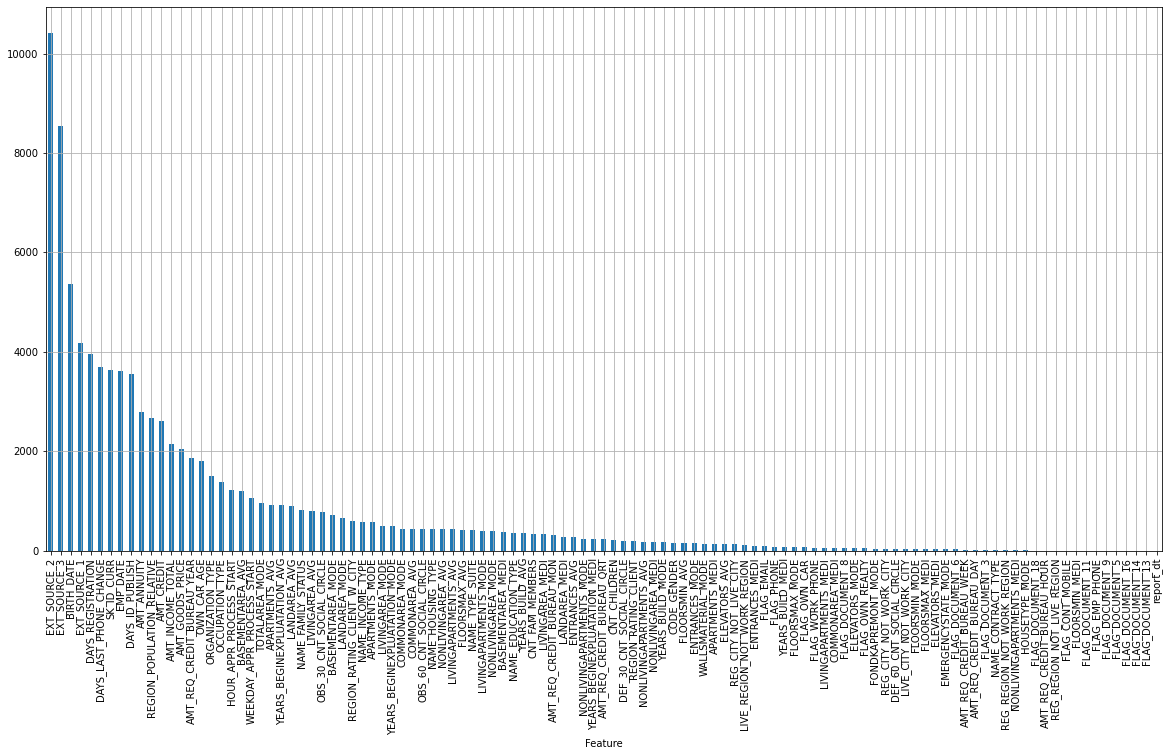

In [18]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast', silent = False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

## Step 6. Predict to test data and check scores for utilized automl

In [19]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-07-06 11:41:57,700] (INFO): Prediction for test data:
array([[0.05361386],
       [0.08067565],
       [0.03236486],
       ...,
       [0.05520236],
       [0.04802004],
       [0.19600457]], dtype=float32)
Shape = (2000, 1)
[2021-07-06 11:41:57,701] (INFO): Check scores...
[2021-07-06 11:41:57,704] (INFO): OOF score: 0.7598311874598584
[2021-07-06 11:41:57,706] (INFO): TEST score: 0.7348148777173913


CPU times: user 3.39 s, sys: 294 ms, total: 3.68 s
Wall time: 1.36 s
